# Libraries

In [1]:
# Prior libraries
import pandas as pd
import numpy as np
import os
import string

# To Get Combinatiobs
import itertools

# Datetime Libraries
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
import time

# Trend Seasonality
from statsmodels.tsa.seasonal import STL

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SAS Connection Library
import swat

# In Order To Read Config File
import json

# Model Preprocess Librarires
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Machine Learning Algorithm Libraries
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Other Libraries
import math
import logging

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max.columns", 100)
pd.set_option("display.max.rows", 100)

C:\Users\tunahan.aktas\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\__init__.py:1: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from .axes3d import Axes3D


In [2]:
f = open("../config.json", "r")
params_ = json.loads(f.read())

---

# Read Files

In [3]:
start_all_process = datetime.now()

In [4]:
start_time = datetime.now()

In [5]:
# List of Excel Files
pas_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["pasifik_satis_path"]) if doc_.startswith("Siparişe_göre_Sales_History")])
hor_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["horizon_satis_path"]) if doc_.startswith("Horizon_Saha_")])
btt_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["btt_satis_path"]) if doc_.startswith("Demand Sensing Sales History") or doc_.startswith("Demand_Sensing_Sales_")])

saha_aktivite_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["horizon_aktivite_path"]) if doc_.startswith("Demand_Sensing_Saha_Aktivit") or doc_.startswith("Demand Sensing Saha Aktivit")])
pasifik_aktivite_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["pasifik_aktivite_path"]) if doc_.startswith("Pasifik Aktivite Datası")])

portfoy_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["portfoy_path"]) if doc_.startswith("Portföy")])
eslenik_kod_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["eslenik_kod_path"]) if doc_.startswith("Ürün Eşlenik kodlar")])
kapsam_listeli = sorted([doc_ for doc_ in os.listdir(params_["path"]["kapsam_path"]) if doc_.startswith("Listeli Ürün")])
pas_siparis_lst = sorted([doc_ for doc_ in os.listdir(params_["path"]["pasifik_siparis_path"]) if doc_.startswith("Siparişe_göre_Sales_History")])

In [6]:
end_time = datetime.now()
print('Dosya Listelerini Okuma İşlemi: {}'.format(end_time - start_time))

Dosya Listelerini Okuma İşlemi: 0:00:00.043001


---
# Read Data
---

In [7]:
start_time = datetime.now()

# Historik data ve koli içi adetlerini okuyoruz

In [8]:
# Read Sales Data
pasifik_df_all = []
btt_df_all = []
horizon_saha_df_all = []
chng_cols_beginning = {'Year': 'Yıl', 'Quarter': 'Çeyrek', 'Month': 'Ay', 
                       'Company Code': 'Şirket Kodu', 'Main Category Name': 'Ana Kategori Adı', 
                       'Category Name': 'Kategori Adı', 'Brand Name': 'Marka Adı', 'Product Code': 'Ürün Kodu', 
                       'Product Name': 'Ürün Adı', "Ürün Adı (Mobis)": 'Ürün Adı'}
for docs_ in btt_lst:
    btt_df_all.append(pd.read_excel(params_["path"]["btt_satis_path"]+docs_, skiprows=1, sheet_name="BTT SAP Satış", usecols="B:N").rename(columns=chng_cols_beginning))

for docs_ in hor_lst:
    horizon_saha_df_all.append(pd.read_excel(params_["path"]["horizon_satis_path"]+docs_, skiprows=1, sheet_name="Horizon Saha Satış", usecols="B:L").rename(columns=chng_cols_beginning))

for docs_ in pas_lst:
    pasifik_df_all.append(pd.read_excel(params_["path"]["pasifik_satis_path"]+docs_, sheet_name="Ürün Bazlı", usecols="B:O").rename(columns=chng_cols_beginning))

# Pasifik ve Horizon historic datasında koli içi adetini bir önceki versiyon olan excelin içerisinden okuyoruz. Bu yüzden siparis klasörünün içindeki dosyalarda gezeceğiz.
pasifik_df_koli_ici_adet = [] 
for docs_ in pas_siparis_lst:
    pasifik_df_koli_ici_adet.append(pd.read_excel(params_["path"]["pasifik_koli_path"]+docs_, skiprows=1, sheet_name="Koli içi adet", usecols="B:D").rename(columns=chng_cols_beginning))

horizon_df_eski = [] 
for docs_ in btt_lst:
    horizon_df_eski.append(pd.read_excel(params_["path"]["horizon_koli_path"]+docs_, skiprows=1, sheet_name="Horizon Saha Satış", usecols="B:N").rename(columns=chng_cols_beginning))

pasifik_df_all = pd.concat(pasifik_df_all)
btt_df_all = pd.concat(btt_df_all)
horizon_saha_df_all = pd.concat(horizon_saha_df_all)

pasifik_df_koli_ici_adet = pd.concat(pasifik_df_koli_ici_adet)
horizon_df_eski = pd.concat(horizon_df_eski)

In [9]:
end_time = datetime.now()
print('Historik datanın Jupytere yüklenme süresi: {}'.format(end_time - start_time))

Historik datanın Jupytere yüklenme süresi: 0:08:44.131058


# Sadece Gerekli Sütunlar Tutuluyor

In [10]:
pasifik_df_all.drop(columns=["Organizasyon Kodu", "Grup Kodu.", "Pladis-Non Pladis"], axis=1, inplace=True)
horizon_saha_df_all.drop(columns=["Çeyrek"], axis=1, inplace=True)
btt_df_all.drop(columns=["Çeyrek", "Şirket Kodu"], axis=1, inplace=True)

btt_df_all["Grup Adı"] = "BTT"
pasifik_df_all.rename(columns={"Ana Kategori": "Ana Kategori Adı", "Kategori": "Kategori Adı", "Ürün Adı (Orjinal)": "Ürün Adı", "Sipariş Miktarı(Dönüş. Koli)": "Koli", 
                               "Sipariş Brüt Tutar": "KG", "Sipariş Brüt KG": "TL"}, inplace=True)

horizon_saha_df_all.rename(columns={"Horizon müşteri grup": "Grup Adı", "Ürün Adı (Orjinal)": "Ürün Adı"}, inplace=True)

# Pasifik için koli içi adetler "Koli içi adet" sheetinde tutuluyor. Buradan alıyoruz fakat historik datada bulunmayan ürün kodları da var. Bu ürün kodlarından bazıları alfabetik harfler içeriyor. Bu durumu ortadan kaldırmak için aşağıdaki işlemi uyguluyoruz. 

## Pasifik Kısmı

In [11]:
col_order = ['Yıl', 'Ay', 'Grup Adı', 'Ana Kategori Adı', 'Kategori Adı', 'Marka Adı', 'Ürün Kodu', 'Ürün Adı', 'Koli İçi Adet', 'Koli', 'KG', 'TL']
ltrs = list(string.ascii_letters) # Alfabede bulunan tüm harfleri tutan liste. Bunu, koli içi adet dataframe'deki harf içeren ürün kodlarını elemek için tutuyoruz.

In [12]:
pasifik_df_koli_ici_adet.drop_duplicates(subset=pasifik_df_koli_ici_adet.columns.to_list(), keep="first", ignore_index=True, inplace=True) # Her dosyada 300k'ya yakın satır var. Yaklaşık 2M kadar satır geliyor çünkü 5-6 yıllık data okuyoruz. Bu yüzden drop duplicates ile satır sayısını azaltıyoruz.
pasifik_df_koli_ici_adet = pasifik_df_koli_ici_adet[~(pasifik_df_koli_ici_adet["Ürün Kodu"].str.contains("|".join(ltrs), regex=True))] # Alfabetik harflerle başlayan ürün kodlarını elemine ediyoruz.

pasifik_df_koli_ici_adet["Ürün Kodu"] = pasifik_df_koli_ici_adet["Ürün Kodu"].str.replace(" ", "") # Bazı ürün kodları 0015 01 şeklinde gelmiş. Yani nümerik gözükse de arada boşluk var. O yüzden boşlukları kaldırıyoruz.
pasifik_df_koli_ici_adet["Ürün Kodu"] = pasifik_df_koli_ici_adet["Ürün Kodu"].astype("int64") # Bir üst satırda boşlukları kaldırdıktan sonra integer hale getiriyoruz.
pasifik_df_koli_ici_adet = pasifik_df_koli_ici_adet[["Ürün Kodu", "Koli İçi Adet"]] # Bu iki satır kalabilir. Left join ile historik dataya ekleyeceğiz.

In [13]:
pasifik_df_all = pasifik_df_all.merge(pasifik_df_koli_ici_adet, on="Ürün Kodu", how="left")

## Horizon Kısmı

In [14]:
# Her dosyada; Ürün Adı sütununda "sum:" diye bir gözlem bulunuyor. Dip toplam yapıp datayı atmışlar. Bu satırları sildim.
horizon_saha_df_all = horizon_saha_df_all[~(horizon_saha_df_all["Ürün Adı"].str.contains("Sum:|sum:"))].reset_index(drop=True)

In [15]:
horizon_kategori = horizon_df_eski[['Ürün Kodu','Kategori Adı']]
horizon_kategori.drop_duplicates(inplace=True, ignore_index=True)

horizon_df_koli_ici_adet = horizon_df_eski[['Yıl','Ay','Ürün Kodu','Koli İçi Adet']]
horizon_df_koli_ici_adet.drop_duplicates(inplace=True, ignore_index=True)

In [16]:
horizon_saha_df_all = horizon_saha_df_all.merge(horizon_kategori, how='left', on='Ürün Kodu')
horizon_saha_df_all = horizon_saha_df_all.merge(horizon_df_koli_ici_adet, how='left')

In [17]:
pasifik_df_all = pasifik_df_all[col_order]
horizon_saha_df_all = horizon_saha_df_all[col_order]
btt_df_all = btt_df_all[col_order]

In [18]:
start_time = datetime.now()

In [19]:
# Read Saha Aktiviteleri
saha_aktivite_detay = []
saha_aktivite_cat = []

for docs_ in saha_aktivite_lst:
    saha_aktivite_detay.append(pd.read_excel(params_["path"]["horizon_aktivite_path"]+docs_, skiprows=1, sheet_name="Ürün Detay", usecols="B:M"))
    saha_aktivite_cat.append(pd.read_excel(params_["path"]["horizon_aktivite_path"]+docs_, skiprows=1, sheet_name="Kategori", usecols="B:I"))
saha_aktivite_detay = pd.concat(saha_aktivite_detay)
saha_aktivite_cat = pd.concat(saha_aktivite_cat)

saha_aktivite_detay.drop_duplicates(subset=["Yıl", "Ay", "Saha Müşteri Grup", "Ürün Kodu"], keep="first", ignore_index=True, inplace=True)

In [20]:
# Read Pasifik Aktiviteleri
pasifik_aktivite_df = pd.read_excel(params_["path"]["pasifik_aktivite_path"]+pasifik_aktivite_lst[0])

pasifik_aktivite_df.drop_duplicates(subset=["Yıl", "Ay", "Müşteri Grup", "Ürün Kodu"], keep="first", ignore_index=True, inplace=True)

In [21]:
# Read Fiyat Listesi
fiyat_lst_pasifik = pd.read_excel(params_["path"]["fiyat_listesi_path"]+params_["files"]["pasifik_fiyat_file"])
fiyat_lst_horizon = pd.read_excel(params_["path"]["fiyat_listesi_path"]+params_["files"]["horizon_fiyat_file"])

In [22]:
# Read Portföy
pasifik_portfoy_df = pd.read_excel(params_["path"]["portfoy_path"]+portfoy_lst[0], sheet_name="Pasifik Portföy", skiprows=3, usecols="D:H")
btt_portfoy_df = pd.read_excel(params_["path"]["portfoy_path"]+portfoy_lst[0], sheet_name="BTT Portföy", skiprows=2, usecols="D:H")
horizon_portfoy_df = pd.read_excel(params_["path"]["portfoy_path"]+portfoy_lst[0], sheet_name="Horizon Portföy", skiprows=2, usecols="E:I")

In [23]:
# Read Eşlenik Kodları
eslenik_kod_df = pd.read_excel(params_["path"]["eslenik_kod_path"]+eslenik_kod_lst[0])

In [24]:
# Read Calender
calender_df = pd.read_excel(params_["path"]["calender_path"]+params_["files"]["calender_file"])

In [25]:
# Read Plasiyer Yarışma
yarisma_df = pd.read_excel(params_["path"]["yarisma_path"]+params_["files"]["yarisma_file"], sheet_name="yarisma_historik_data")

In [26]:
eslenik_kod_df["En Güncel Kod"] = eslenik_kod_df["En Güncel Kod"].apply(lambda x: int(x) if x not in ['delist ', "delist", "Delist"] else x.replace(" ", ""))

In [27]:
a101_kapsam = pd.read_excel(params_["path"]["kapsam_path"]+kapsam_listeli[0], sheet_name="A101 Portföy")
sok_kapsam = pd.read_excel(params_["path"]["kapsam_path"]+kapsam_listeli[0], sheet_name="Şok Portföy")
bim_kapsam = pd.read_excel(params_["path"]["kapsam_path"]+kapsam_listeli[0], sheet_name="Bim Portföy")

a101_kapsam["grup_adi"] = "A101"
sok_kapsam["grup_adi"] = "ŞOK"
bim_kapsam["grup_adi"] = "BİM"

kapsam_all = pd.concat([a101_kapsam, sok_kapsam, bim_kapsam], axis=0, ignore_index=True)

In [28]:
# Read Enflasyon
enflasyon_df = pd.read_html(params_["path"]["enflasyon_path"])[0]
enflasyon_df.columns=["date", "enflasyon_etkisi", "degisim"]
enflasyon_df.drop("degisim", axis=1, inplace=True)
enflasyon_df["date"] = enflasyon_df["date"].apply(lambda x: "01-"+x)
enflasyon_df["date"] = pd.to_datetime(enflasyon_df["date"], format="%d-%m-%Y")

In [29]:
# Read Koli Birim Ağırlıkları
koli_birim_agirlik = pd.read_excel(params_["files"]["koli_agirlik_birim_file"])
koli_birim_agirlik_pas = pd.read_excel(params_["files"]["koli_agirlik_birim_file"])

In [30]:
koli_birim_agirlik.rename(columns={"Malzeme": "en_guncel_kod", 
                                   "Malzeme Açıklaması": "urun_adi", 
                                   "Ana Kategori": "ana_kategori_adi",
                                   "Kategori": "kategori_adi",
                                   "Alt Kategori": "alt_kategori_adi",
                                   "Detay Kategori": "detay_kategori_adi",
                                   "Marka": "marka_adi", "Marka Açıklaması": "marka_aciklamasi",
                                   "Net Ağırlık": "kg"}, inplace=True)

koli_birim_agirlik_pas.rename(columns={"Malzeme": "en_guncel_kod", 
                                   "Malzeme Açıklaması": "urun_adi", 
                                   "Ana Kategori": "ana_kategori_adi",
                                   "Kategori": "kategori_adi",
                                   "Alt Kategori": "alt_kategori_adi",
                                   "Detay Kategori": "detay_kategori_adi",
                                   "Marka": "marka_adi", "Marka Açıklaması": "marka_aciklamasi",
                                   "Net Ağırlık": "kg"}, inplace=True)

In [31]:
koli_birim_agirlik_pas["kanal"] = "pasifik"
koli_birim_agirlik_hor = koli_birim_agirlik.copy()
koli_birim_agirlik_btt = koli_birim_agirlik.copy()
koli_birim_agirlik_hor["kanal"] = "horizon"
koli_birim_agirlik_btt["kanal"] = "btt"

In [32]:
koli_birim_agirlik = pd.concat([koli_birim_agirlik_pas, koli_birim_agirlik_hor, koli_birim_agirlik_btt], axis=0, ignore_index=True)

In [33]:
end_time = datetime.now()
print('Diğer dataların Jupytere yüklenme süresi: {}'.format(end_time - start_time))

Diğer dataların Jupytere yüklenme süresi: 0:01:03.046544


---
# Pasifik 2016 aktivite verileri olmadığı için 2016 Sales dataları çıkartıldı.

In [34]:
pasifik_df_all = pasifik_df_all[pasifik_df_all["Yıl"] != 2016].reset_index(drop=True)

In [35]:
#pasifik_df_all = pasifik_df_all[~((pasifik_df_all["Yıl"] == 2021) & (pasifik_df_all["Ay"].isin([6, 7, 8, 9])))].reset_index(drop=True)
#horizon_saha_df_all = horizon_saha_df_all[~((horizon_saha_df_all["Yıl"] == 2021) & (horizon_saha_df_all["Ay"].isin([6, 7, 8, 9])))].reset_index(drop=True)
#btt_df_all = btt_df_all[~((btt_df_all["Yıl"] == 2021) & (btt_df_all["Ay"].isin([6, 7, 8, 9])))].reset_index(drop=True)

In [36]:
horizon_saha_df_all["Yıl"] = horizon_saha_df_all["Yıl"].astype(int)
horizon_saha_df_all["Ay"] = horizon_saha_df_all["Ay"].astype(int)

---

# Sales Datası İçin Ürün Kod Eşleme

---

---

## Join

In [37]:
kategori_adi = btt_df_all.drop_duplicates(subset=["Marka Adı", "Kategori Adı"], keep="first")[["Marka Adı", "Kategori Adı"]]
kategori_adi.sort_values(by=["Marka Adı", "Kategori Adı"], ignore_index=True, inplace=True)
kategori_adi = dict(kategori_adi.values)

In [38]:
horizon_saha_df_all["Kategori Adı"] = horizon_saha_df_all["Kategori Adı"].fillna(horizon_saha_df_all["Marka Adı"].map(kategori_adi))

In [39]:
pasifik_df_all = pd.merge(pasifik_df_all, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
horizon_saha_df_all = pd.merge(horizon_saha_df_all, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
btt_df_all = pd.merge(btt_df_all, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")

## Ürün Eşleme Kodları dosyasında yer almayan kodlar için mevcut ürün kodları verildi.

In [40]:
empty_ = pasifik_df_all[pd.isnull(pasifik_df_all["En Güncel Kod"])].reset_index(drop=True)
full_ = pasifik_df_all[~pd.isnull(pasifik_df_all["En Güncel Kod"])].reset_index(drop=True)
empty_["En Güncel Kod"] = empty_["Ürün Kodu"]
pasifik_df_all = pd.concat([empty_, full_], axis=0, ignore_index=True)
pasifik_df_all = pasifik_df_all.sort_values(pasifik_df_all.columns.to_list()).reset_index(drop=True)

empty_ = btt_df_all[pd.isnull(btt_df_all["En Güncel Kod"])].reset_index(drop=True)
full_ = btt_df_all[~pd.isnull(btt_df_all["En Güncel Kod"])].reset_index(drop=True)
empty_["En Güncel Kod"] = empty_["Ürün Kodu"]
btt_df_all = pd.concat([empty_, full_], axis=0, ignore_index=True)
btt_df_all = btt_df_all.sort_values(btt_df_all.columns.to_list()).reset_index(drop=True)

empty_ = horizon_saha_df_all[pd.isnull(horizon_saha_df_all["En Güncel Kod"])].reset_index(drop=True)
full_ = horizon_saha_df_all[~pd.isnull(horizon_saha_df_all["En Güncel Kod"])].reset_index(drop=True)
empty_["En Güncel Kod"] = empty_["Ürün Kodu"]
horizon_saha_df_all = pd.concat([empty_, full_], axis=0, ignore_index=True)
horizon_saha_df_all = horizon_saha_df_all.sort_values(horizon_saha_df_all.columns.to_list()).reset_index(drop=True)

## Adet adında yeni bir kolon oluşturuldu. Koli Sayısı 100'den az olanlara 0 yazıyoruz

In [41]:
pasifik_df_all["Adet"] = pasifik_df_all["Koli İçi Adet"] * pasifik_df_all["Koli"]
btt_df_all["Adet"] = btt_df_all["Koli İçi Adet"] * btt_df_all["Koli"]
horizon_saha_df_all["Adet"] = horizon_saha_df_all["Koli İçi Adet"] * horizon_saha_df_all["Koli"]

pasifik_df_all["Adet"] = pasifik_df_all["Adet"] = np.where(pasifik_df_all["Koli"] < 100, 1, pasifik_df_all["Adet"])
btt_df_all["Adet"] = btt_df_all["Adet"] = np.where(btt_df_all["Koli"] < 100, 1, btt_df_all["Adet"])
horizon_saha_df_all["Adet"] = horizon_saha_df_all["Adet"] = np.where(horizon_saha_df_all["Koli"] < 100, 1, horizon_saha_df_all["Adet"])

## Delist olan ürünler veriden çıkartıldı.

In [42]:
pasifik_df_all = pasifik_df_all[pasifik_df_all["En Güncel Kod"] != "delist"].reset_index(drop=True)
btt_df_all = btt_df_all[btt_df_all["En Güncel Kod"] != "delist"].reset_index(drop=True)
horizon_saha_df_all = horizon_saha_df_all[horizon_saha_df_all["En Güncel Kod"] != "delist"].reset_index(drop=True)

## Aynı yıl, ay, grup adı, ana kategori adı, kategori adı, marka adı ve SKU kodundaki ürünler için toplam alındı. Sadece Koli İçi Adet için maksimum olan alındı.

---

# Marka adı dahil değil groupby'a
---

In [43]:
dct_to_sum = {"Koli İçi Adet": "sum", "Koli": "sum", "KG": "sum", "TL": "sum", "Adet": "sum"}

pasifik_df_all2 = pasifik_df_all.groupby(["Yıl", "Ay", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "En Güncel Kod"]).agg(dct_to_sum).reset_index()
btt_df_all2 = btt_df_all.groupby(["Yıl", "Ay", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "En Güncel Kod"]).agg(dct_to_sum).reset_index()
horizon_saha_df_all2 = horizon_saha_df_all.groupby(["Yıl", "Ay", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "En Güncel Kod"]).agg(dct_to_sum).reset_index()

In [44]:
pasifik_df_all2["Date"] = pasifik_df_all2["Yıl"].astype(str) + "-" +  pasifik_df_all2["Ay"].astype(str) + "-01"
btt_df_all2["Date"] = btt_df_all2["Yıl"].astype(int).astype(str) + "-" +  btt_df_all2["Ay"].astype(int).astype(str) + "-01"
horizon_saha_df_all2["Date"] = horizon_saha_df_all2["Yıl"].astype(int).astype(str) + "-" +  horizon_saha_df_all2["Ay"].astype(int).astype(str) + "-01"

pasifik_df_all2["Date"] = pd.to_datetime(pasifik_df_all2["Date"], format="%Y-%m-%d", errors="coerce")
btt_df_all2["Date"] = pd.to_datetime(btt_df_all2["Date"], format="%Y-%m-%d", errors="coerce")
horizon_saha_df_all2["Date"] = pd.to_datetime(horizon_saha_df_all2["Date"], format="%Y-%m-%d", errors="coerce")

## Horizon ve Pasifikte bulunan "Diğer"'lerin yanlarına "_" ile Diğer_Pasifik, Diğer_Horizon yazıldı.

In [45]:
pasifik_df_all2["Grup Adı"] = pasifik_df_all2["Grup Adı"].apply(lambda x: "Diğer_Pasifik" if x == "Diğer" else x)
horizon_saha_df_all2["Grup Adı"] = horizon_saha_df_all2["Grup Adı"].apply(lambda x: "Diğer_Horizon" if x == "Diğer" else x)

In [46]:
df_all2 = pd.concat([pasifik_df_all2, horizon_saha_df_all2, btt_df_all2], ignore_index=True)

---
# Pasifik Filling Missing Values
---

In [47]:
start_time = datetime.now()

In [48]:
pasifik_urun_isimleri = pasifik_df_all[["Marka Adı", "Ürün Adı", "En Güncel Kod"]].drop_duplicates(subset=["Marka Adı", "En Güncel Kod"],ignore_index=True,keep="first")
pasifik_urun_isimleri = pasifik_urun_isimleri[~((pasifik_urun_isimleri["Marka Adı"] == "DANKEK BATON") & (pasifik_urun_isimleri["En Güncel Kod"] == 80403))]
pasifik_df_all2 = pd.merge(pasifik_df_all2, pasifik_urun_isimleri[["En Güncel Kod", "Marka Adı", "Ürün Adı"]].drop_duplicates(subset=["En Güncel Kod", "Marka Adı", "Ürün Adı"], keep="first"), on="En Güncel Kod", how="left")
pasifik_df_all2 = pasifik_df_all2[pasifik_df_all2.columns.to_list()[:5]+pasifik_df_all2.columns.to_list()[-2:]+[pasifik_df_all2.columns.to_list()[5]]+pasifik_df_all2.columns.to_list()[6:12]]



horizon_urun_isimleri = horizon_saha_df_all[["Marka Adı", "Ürün Adı", "En Güncel Kod"]].drop_duplicates(subset=["Marka Adı", "En Güncel Kod"],ignore_index=True,keep="first")
horizon_urun_isimleri = horizon_urun_isimleri[~(((horizon_urun_isimleri["Marka Adı"] == "DANKEK BATON") & (horizon_urun_isimleri["En Güncel Kod"] == 80403)) | 
                                                ((horizon_urun_isimleri["Marka Adı"] == "MAVİ YEŞİL") & (horizon_urun_isimleri["En Güncel Kod"] == 11802)) |
                                                ((horizon_urun_isimleri["Marka Adı"] == "MAVİ YEŞİL") & (horizon_urun_isimleri["En Güncel Kod"] == 74306)) |
                                                ((horizon_urun_isimleri["Marka Adı"] == "AS KRAKER") & (horizon_urun_isimleri["En Güncel Kod"] == 190502)))]
horizon_saha_df_all2 = pd.merge(horizon_saha_df_all2, horizon_urun_isimleri[["En Güncel Kod", "Marka Adı", "Ürün Adı"]], on="En Güncel Kod", how="left")
horizon_saha_df_all2 = horizon_saha_df_all2[horizon_saha_df_all2.columns.to_list()[:5]+horizon_saha_df_all2.columns.to_list()[-2:]+[horizon_saha_df_all2.columns.to_list()[5]]+horizon_saha_df_all2.columns.to_list()[6:12]]



btt_urun_isimleri = btt_df_all[["Marka Adı", "Ürün Adı", "En Güncel Kod"]].drop_duplicates(subset=["Marka Adı", "En Güncel Kod"],ignore_index=True,keep="first")
btt_urun_isimleri = btt_urun_isimleri[~((btt_urun_isimleri["Marka Adı"] == "DANKEK BATON") & (btt_urun_isimleri["En Güncel Kod"] == 80403))]
btt_df_all2 = pd.merge(btt_df_all2, btt_urun_isimleri[["En Güncel Kod", "Marka Adı", "Ürün Adı"]].drop_duplicates(subset=["En Güncel Kod", "Marka Adı", "Ürün Adı"], keep="first"), on="En Güncel Kod", how="left")
btt_df_all2 = btt_df_all2[btt_df_all2.columns.to_list()[:5]+btt_df_all2.columns.to_list()[-2:]+[btt_df_all2.columns.to_list()[5]]+btt_df_all2.columns.to_list()[6:12]]

In [49]:
pasifik_df_all_filled = []
for idx, test in pasifik_df_all2.groupby(["En Güncel Kod", "Yıl", "Grup Adı"]):
    test.reset_index(drop=True, inplace=True)
    for i in range(1, 13):
        try:
            if i == test.loc[i-1, "Ay"]:
                if i == 13:
                    break
            else:
                test.loc[-1] = test.loc[0]
                test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
                test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
                test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        except:
            test.loc[-1] = test.loc[0]
            test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
            test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
            test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d", errors="coerce")
    rows_to_drop = []
    start = test.index[0]
    length = 1
    while (test.loc[start, "Adet"] == 1) and (length < len(test)):
        rows_to_drop.append(start)
        length+=1
        start+=1
    test.drop(index=rows_to_drop, inplace=True)
    pasifik_df_all_filled.append(test)

In [50]:
pasifik_df_all2 = pd.concat(pasifik_df_all_filled, ignore_index=True)

In [51]:
end_time = datetime.now()
print('Pasifik missing value düzenlenmesi süresi: {}'.format(end_time - start_time))

Pasifik missing value düzenlenmesi süresi: 0:04:04.553430


---
# Horizon Filling Missing Values
---

In [52]:
start_time = datetime.now()

In [53]:
horizon_saha_df_all_filled = []
for idx, test in horizon_saha_df_all2.groupby(["En Güncel Kod", "Yıl", "Grup Adı"]):
    test.reset_index(drop=True, inplace=True)
    for i in range(1, 13):
        try:
            if i == test.loc[i-1, "Ay"]:
                if i == 13:
                    break
            else:
                test.loc[-1] = test.loc[0]
                test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
                test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
                test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        except:
            test.loc[-1] = test.loc[0]
            test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
            test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
            test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d", errors="coerce")
    
    rows_to_drop = []
    start = test.index[0]
    length = 1
    while (test.loc[start, "Adet"] == 1) and (length < len(test)):
        rows_to_drop.append(start)
        length+=1
        start+=1
    test.drop(index=rows_to_drop, inplace=True)
    horizon_saha_df_all_filled.append(test)

In [54]:
horizon_saha_df_all2 = pd.concat(horizon_saha_df_all_filled, ignore_index=True)

In [55]:
end_time = datetime.now()
print('Horizon missing value düzenlenmesi süresi: {}'.format(end_time - start_time))

Horizon missing value düzenlenmesi süresi: 0:12:20.034902


---
# BTT Filling Missing Values
---

In [56]:
start_time = datetime.now()

In [57]:
btt_df_all_filled = []
for idx, test in btt_df_all2.groupby(["En Güncel Kod", "Yıl", "Grup Adı"]):
    test.reset_index(drop=True, inplace=True)
    for i in range(1, 13):
        try:
            if i == test.loc[i-1, "Ay"]:
                if i == 13:
                    break
            else:
                test.loc[-1] = test.loc[0]
                test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
                test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
                test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        except:
            test.loc[-1] = test.loc[0]
            test.loc[-1, "Ay"], test.loc[-1, "Koli İçi Adet"], test.loc[-1, "Koli"],  \
            test.loc[-1, "KG"], test.loc[-1, "TL"], test.loc[-1, "Adet"], test.loc[-1, "Date"] = i, 0, 0, 0, 0, 1, str(test.loc[-1, "Yıl"])+"-"+str(i)+"-"+str("01")
            test = test.sort_values(by=["Yıl", "Ay"]).reset_index(drop=True)
        test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d", errors="coerce")

    rows_to_drop = []
    start = test.index[0]
    length = 1
    while (test.loc[start, "Adet"] == 1) and (length < len(test)):
        rows_to_drop.append(start)
        length+=1
        start+=1
    test.drop(index=rows_to_drop, inplace=True)
    btt_df_all_filled.append(test)

In [58]:
btt_df_all2 = pd.concat(btt_df_all_filled, ignore_index=True)

In [59]:
end_time = datetime.now()
print('BTT missing value düzenlenmesi süresi: {}'.format(end_time - start_time))

BTT missing value düzenlenmesi süresi: 0:01:29.922050


In [60]:
new_horizon_saha_df_all2 = horizon_saha_df_all2.copy()
new_pasifik_df_all2 = pasifik_df_all2.copy()

In [61]:
new_horizon_saha_df_all2['Yıl'] = new_horizon_saha_df_all2['Yıl'].astype(int)
new_horizon_saha_df_all2['Ay'] = new_horizon_saha_df_all2['Ay'].astype(int)
new_horizon_saha_df_all2['En Güncel Kod'] = new_horizon_saha_df_all2['En Güncel Kod'].astype(int)
new_horizon_saha_df_all2['Date'] = new_horizon_saha_df_all2['Yıl'].astype(str) + '-' + new_horizon_saha_df_all2['Ay'].astype(str) + '-01'
new_horizon_saha_df_all2["Date"] = pd.to_datetime(new_horizon_saha_df_all2["Date"], format="%Y-%m-%d", errors="coerce")

In [62]:
df_all22 = pd.concat([new_pasifik_df_all2, new_horizon_saha_df_all2, btt_df_all2], ignore_index=True)

---

# Aktivite Datası İçin Ürün Kod Eşleme

---

# Pasifik Aktivite

## Left join ile güncel kodlar getirildi. Delist olan ürünler listeden çıkartıldı. "Çeyrek" sütunu silindi. En güncel kod sütunnuda bulunamayan değerler Ürün Kodu sütunundan çekildi.

In [63]:
pasifik_aktivite_df2 = pd.merge(pasifik_aktivite_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
pasifik_aktivite_df2 = pasifik_aktivite_df2[pasifik_aktivite_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
pasifik_aktivite_df2.drop("Çeyrek", inplace=True, axis=1)
pasifik_aktivite_df2['En Güncel Kod'] = pasifik_aktivite_df2['En Güncel Kod'].fillna(pasifik_aktivite_df2['Ürün Kodu'])
pasifik_aktivite_df2.drop(columns="Ürün Kodu", axis=1, inplace=True)

---

# Pasifik Aktivite Ciro - Promosyon Tutarı ve İskonto Tekilleştirme (ORTALAMA ALARAK)

In [64]:
ort_pas = {"Raf Tavsiye Satış Fiyatı": "mean", "İndirimli Raf Satış Fiyatı": "mean", "İndirim %": "mean", "Aktivite Tipi": "first"}
pasifik_aktivite_df3 = pasifik_aktivite_df2.groupby(["En Güncel Kod", "Yıl", "Ay", "Müşteri Grup"]).agg(ort_pas).reset_index()
pasifik_aktivite_df3 = pd.merge(pasifik_aktivite_df3, pasifik_aktivite_df2[["Yıl", "Ay", "Müşteri Grup", "En Güncel Kod", 
                                                                            "Ana Kategori Adı", "Kategori Adı", "Marka Adı"]],
                                how="left", 
                                on=["En Güncel Kod", "Yıl", "Ay", "Müşteri Grup"])

pasifik_aktivite_df3.drop_duplicates(subset=pasifik_aktivite_df3.columns.to_list(), inplace=True)
pasifik_aktivite_df3.reset_index(drop=True, inplace=True)
pasifik_aktivite_df3 = pasifik_aktivite_df3[pasifik_aktivite_df2.drop("Ürün Adı", axis=1).columns.to_list()]

---

# Horizon Aktivite

In [65]:
saha_aktivite_detay2 = pd.merge(saha_aktivite_detay, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], on="Ürün Kodu", how="left")
saha_aktivite_detay2 = saha_aktivite_detay2[saha_aktivite_detay2["En Güncel Kod"] != "delist"].reset_index(drop=True)
saha_aktivite_detay2.drop("Çeyrek", inplace=True, axis=1)
saha_aktivite_detay2['En Güncel Kod'] = saha_aktivite_detay2['En Güncel Kod'].fillna(saha_aktivite_detay2['Ürün Kodu'])
saha_aktivite_detay2.drop(columns="Ürün Kodu", axis=1, inplace=True)
saha_aktivite_detay2["İskonto %"].replace("#DIV/0", np.nan,inplace=True)

# Horizon Aktivite Ciro - Promosyon Tutarı ve İskonto Tekilleştirme (ORTALAMA ALARAK)

In [66]:
ort = {"Ciro (Kull. İade Düş.)": "mean", "Promosyon Tutarı": "mean", "İskonto %": "mean"}
saha_aktivite_detay3 = saha_aktivite_detay2.groupby(["En Güncel Kod", "Yıl", "Ay", "Saha Müşteri Grup"]).agg(ort).reset_index()

saha_aktivite_detay3 = pd.merge(saha_aktivite_detay3, saha_aktivite_detay2[["Yıl", "Ay", "Saha Müşteri Grup", "En Güncel Kod", 
                                                 "Ana Kategori Adı", "Kategori Adı", "Marka Adı"]],
                           how="left", 
                           on=["En Güncel Kod", "Yıl", "Ay", "Saha Müşteri Grup"])

saha_aktivite_detay3.drop_duplicates(subset=saha_aktivite_detay3.columns.to_list(), inplace=True)

In [67]:
saha_aktivite_detay3 = saha_aktivite_detay3[saha_aktivite_detay2.drop("Ürün Adı (Mobis)", axis=1).columns.to_list()].reset_index(drop=True)

In [68]:
saha_aktivite_detay3.rename(columns={"Saha Müşteri Grup": "Grup Adı"}, inplace=True)
saha_aktivite_detay3["Grup Adı"] = saha_aktivite_detay3["Grup Adı"].apply(lambda x: "Diğer_Horizon" if x == "Diğer" else x)

---

# Fiyat Listesi

## Horizon Fiyatları
---

In [69]:
start_time = datetime.now()

In [70]:
fiyat_lst_horizon.drop_duplicates(subset=fiyat_lst_horizon.columns.to_list(), keep="first", ignore_index=True, inplace=True)

In [71]:
try:
    fiyat_lst_horizon["Malzeme"] = fiyat_lst_horizon["Malzeme"].str.replace("-", "")
    fiyat_lst_horizon["Malzeme"] = fiyat_lst_horizon["Malzeme"].astype(int)*1
except:
    fiyat_lst_horizon["Malzeme"] = fiyat_lst_horizon["Malzeme"].astype(int)*1

In [72]:
fiyat_lst_horizon_df = fiyat_lst_horizon.copy()

In [73]:
fiyat_lst_horizon_df["Baslangic_Yıl"] = fiyat_lst_horizon_df["Bşl.tarihi"].apply(lambda x: x.year)
fiyat_lst_horizon_df["Baslangic_Ay"] = fiyat_lst_horizon_df["Bşl.tarihi"].apply(lambda x: x.month)
fiyat_lst_horizon_df["Baslangic_Gun"] = fiyat_lst_horizon_df["Bşl.tarihi"].apply(lambda x: x.day)
fiyat_lst_horizon_df["Gecerlilik_Yıl"] = fiyat_lst_horizon_df["Gçrl.sonu"].apply(lambda x: x.year)
fiyat_lst_horizon_df["Gecerlilik_Ay"] = fiyat_lst_horizon_df["Gçrl.sonu"].apply(lambda x: x.month)
fiyat_lst_horizon_df["Gecerlilik_Gun"] = fiyat_lst_horizon_df["Gçrl.sonu"].apply(lambda x: x.day)

In [74]:
fiyat_lst_horizon_df["Baslangic_Yıl"] = fiyat_lst_horizon_df["Baslangic_Yıl"].apply(lambda x: (horizon_saha_df_all2["Date"].max().year)+1 if x > horizon_saha_df_all2["Date"].max().year else x)
fiyat_lst_horizon_df["Gecerlilik_Yıl"] = fiyat_lst_horizon_df["Gecerlilik_Yıl"].apply(lambda x: (horizon_saha_df_all2["Date"].max().year)+1 if x > horizon_saha_df_all2["Date"].max().year else x)

In [75]:
time_index = horizon_saha_df_all2["Date"].unique()

In [76]:
h_fiyat_unique = []

for malzeme in fiyat_lst_horizon_df["Malzeme"].unique():
    temp_time_df = pd.DataFrame({"Fiyat": [np.nan]}, index=time_index)
    temp_time_df = temp_time_df.reset_index().rename(columns={"index":"date"})    
    temp_time_df["En Güncel Kod"] = malzeme
    temp_time_df["fiyat_gecisi"] = 0
    malzeme_df = fiyat_lst_horizon_df[fiyat_lst_horizon_df["Malzeme"] == malzeme].reset_index(drop=True)
    malzeme_df.drop(columns=["KşTü", "Koşul türü", "Tanım", "Ana Kategori", "Kategori", "ÖB"], axis=1, inplace=True)
    malzeme_df.drop_duplicates(subset=malzeme_df.columns.to_list(), inplace=True, ignore_index=True)
    malzeme_df.sort_values(by=["Baslangic_Yıl", "Baslangic_Ay", "Baslangic_Gun"], ignore_index=True, inplace=True)
    check_idx1 = []
    if len(malzeme_df) > 1:
        for row1 in malzeme_df.index:
            for row2 in malzeme_df[row1+1:].index:
                if (malzeme_df.loc[row1]["Gecerlilik_Yıl"] == malzeme_df.loc[row2]["Baslangic_Yıl"]) and (malzeme_df.loc[row1]["Gecerlilik_Ay"] == malzeme_df.loc[row2]["Baslangic_Ay"]):
                    num_days = calendar.monthrange(int(malzeme_df.loc[row2]["Baslangic_Yıl"]), int(malzeme_df.loc[row2]["Baslangic_Ay"]))[1]
                    fyt=((int(malzeme_df.loc[row1]["Gecerlilik_Gun"])*malzeme_df.loc[row1]["     Tutar"]) + (num_days - int(malzeme_df.loc[row2]["Baslangic_Gun"]) + 1)*malzeme_df.loc[row2]["     Tutar"])/num_days

                    end_idx1 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx1 = temp_time_df[temp_time_df["date"] == end_idx1].index
                    temp_time_df.loc[final_idx1, "Fiyat"] = fyt
                    temp_time_df.loc[final_idx1,"fiyat_gecisi"] = 1

                elif (malzeme_df.loc[row1, "Gecerlilik_Gun"] == calendar.monthrange(int(malzeme_df.loc[row1]["Gecerlilik_Yıl"]), int(malzeme_df.loc[row1]["Gecerlilik_Ay"]))[1] \
                     and malzeme_df.loc[row2, "Baslangic_Gun"] == 1):
                    fyt5=malzeme_df.loc[row1]["     Tutar"]
                    fyt6=malzeme_df.loc[row2]["     Tutar"]
                    end_idx5 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    end_idx6 =  datetime(int(malzeme_df.loc[row2, "Baslangic_Yıl"]), int(malzeme_df.loc[row2, "Baslangic_Ay"]), 1)
                    final_idx5 = temp_time_df[temp_time_df["date"] == end_idx5].index
                    final_idx6 = temp_time_df[temp_time_df["date"] == end_idx6].index
                    temp_time_df.loc[final_idx5, "Fiyat"] = fyt5
                    temp_time_df.loc[final_idx6, "Fiyat"] = fyt6

                else:
                    fyt2=malzeme_df.loc[row1]["     Tutar"]
                    start_idx2 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                    end_idx2 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx2 = temp_time_df[(temp_time_df["date"] > start_idx2) & (temp_time_df["date"] < end_idx2)].index
                    temp_time_df.loc[final_idx2, "Fiyat"] = fyt2
            if (row1 == len(malzeme_df)-1) or (row1 == len(malzeme_df)-2):
                fyt3=malzeme_df.loc[row1]["     Tutar"]
                start_idx3 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                end_idx3 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                final_idx3 = temp_time_df[(temp_time_df["date"] > start_idx3) & (temp_time_df["date"] < end_idx3)].index
                temp_time_df.loc[final_idx3, "Fiyat"] = fyt3

    else:
        for row1 in malzeme_df.index:
            fyt4=malzeme_df.loc[row1]["     Tutar"]
            start_idx4 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
            end_idx4 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
            final_idx4 = temp_time_df[(temp_time_df["date"] >= start_idx4) & (temp_time_df["date"] <= end_idx4)].index
            temp_time_df.loc[final_idx4, "Fiyat"] = fyt4

    if (malzeme_df.loc[0, "Baslangic_Yıl"] >= min(horizon_saha_df_all2["Yıl"].unique())) and (len(malzeme_df) > 1):
        temp_time_df.loc[temp_time_df[~pd.isnull(temp_time_df["Fiyat"])].index[0]-1, "Fiyat"] = malzeme_df.loc[0, "     Tutar"]
    temp_time_df = temp_time_df.dropna().reset_index(drop=True)

    h_fiyat_unique.append(temp_time_df)

In [77]:
h_fiyat_unique = pd.concat(h_fiyat_unique)
h_fiyat_unique.reset_index(drop=True, inplace=True)

h_fiyat_unique.rename(columns={"En Güncel Kod": "Ürün Kodu", "date": "Date"}, inplace=True)
h_fiyat_unique = h_fiyat_unique.merge(eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left")
h_fiyat_unique["En Güncel Kod"].fillna(h_fiyat_unique["Ürün Kodu"], inplace=True)
h_fiyat_unique = h_fiyat_unique[h_fiyat_unique["En Güncel Kod"] != "delist"].reset_index(drop=True)
h_fiyat_unique = h_fiyat_unique.sort_values(by=["En Güncel Kod", "Date"]).reset_index(drop=True)
h_fiyat_unique = h_fiyat_unique.drop(columns="Ürün Kodu", axis=1)
# Aynı aya denk gelen ürünlerin fiyatlarının ortalaması alınıp, herhangi birinde fiyat geçişi varsa 1 alınır.
h_fiyat_unique = h_fiyat_unique.groupby(["Date", "En Güncel Kod"]).agg({"Fiyat": "mean", "fiyat_gecisi": "max"}).reset_index()

In [78]:
end_time = datetime.now()
print('Horizon fiyatların düzenlenmesi süresi: {}'.format(end_time - start_time))

Horizon fiyatların düzenlenmesi süresi: 0:02:27.367240


## Pasifik Fiyatları
---

In [79]:
start_time = datetime.now()

In [80]:
fiyat_lst_pasifik.drop_duplicates(subset=fiyat_lst_pasifik.columns.to_list(), keep="first", ignore_index=True, inplace=True)

In [81]:
fiyat_lst_pasifik["Malzeme"] = fiyat_lst_pasifik["Malzeme"].str.replace("-", "")
fiyat_lst_pasifik["Malzeme"] = fiyat_lst_pasifik["Malzeme"].astype(int)*1

In [82]:
fiyat_lst_pasifik_df = fiyat_lst_pasifik.copy()

In [83]:
fiyat_lst_pasifik_df["Baslangic_Yıl"] = fiyat_lst_pasifik_df["Bşl.tarihi"].apply(lambda x: x.year)
fiyat_lst_pasifik_df["Baslangic_Ay"] = fiyat_lst_pasifik_df["Bşl.tarihi"].apply(lambda x: x.month)
fiyat_lst_pasifik_df["Baslangic_Gun"] = fiyat_lst_pasifik_df["Bşl.tarihi"].apply(lambda x: x.day)
fiyat_lst_pasifik_df["Gecerlilik_Yıl"] = fiyat_lst_pasifik_df["Gçrl.sonu"].apply(lambda x: x.year)
fiyat_lst_pasifik_df["Gecerlilik_Ay"] = fiyat_lst_pasifik_df["Gçrl.sonu"].apply(lambda x: x.month)
fiyat_lst_pasifik_df["Gecerlilik_Gun"] = fiyat_lst_pasifik_df["Gçrl.sonu"].apply(lambda x: x.day)

In [84]:
fiyat_lst_pasifik_df["Baslangic_Yıl"] = fiyat_lst_pasifik_df["Baslangic_Yıl"].apply(lambda x: (pasifik_df_all2["Date"].max().year)+1 if x > pasifik_df_all2["Date"].max().year else x)
fiyat_lst_pasifik_df["Gecerlilik_Yıl"] = fiyat_lst_pasifik_df["Gecerlilik_Yıl"].apply(lambda x: (pasifik_df_all2["Date"].max().year)+1 if x > pasifik_df_all2["Date"].max().year else x)

In [85]:
time_index = pasifik_df_all2["Date"].unique()

In [86]:
p_fiyat_unique = []

for malzeme in fiyat_lst_pasifik_df["Malzeme"].unique():
    temp_time_df = pd.DataFrame({"Fiyat": [np.nan]}, index=time_index)
    temp_time_df = temp_time_df.reset_index().rename(columns={"index":"date"})    
    temp_time_df["En Güncel Kod"] = malzeme
    temp_time_df["fiyat_gecisi"] = 0
    malzeme_df = fiyat_lst_pasifik_df[fiyat_lst_pasifik_df["Malzeme"] == malzeme].reset_index(drop=True)
    malzeme_df.drop(columns=["KşTü", "KşTü.1", "Malzeme Tanım", "Ana Kategori", "Kategori"], axis=1, inplace=True)
    malzeme_df.drop_duplicates(subset=malzeme_df.columns.to_list(), inplace=True, ignore_index=True)
    malzeme_df.sort_values(by=["Baslangic_Yıl", "Baslangic_Ay", "Baslangic_Gun"], ignore_index=True, inplace=True)
    check_idx1 = []
    if len(malzeme_df) > 1:
        for row1 in malzeme_df.index:
            for row2 in malzeme_df[row1+1:].index:
                if (malzeme_df.loc[row1]["Gecerlilik_Yıl"] == malzeme_df.loc[row2]["Baslangic_Yıl"]) and (malzeme_df.loc[row1]["Gecerlilik_Ay"] == malzeme_df.loc[row2]["Baslangic_Ay"]):
                    num_days = calendar.monthrange(int(malzeme_df.loc[row2]["Baslangic_Yıl"]), int(malzeme_df.loc[row2]["Baslangic_Ay"]))[1]
                    fyt=((int(malzeme_df.loc[row1]["Gecerlilik_Gun"])*malzeme_df.loc[row1]["Koli TL"]) + (num_days - int(malzeme_df.loc[row2]["Baslangic_Gun"])+1)*malzeme_df.loc[row2]["Koli TL"])/num_days

                    end_idx1 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx1 = temp_time_df[temp_time_df["date"] == end_idx1].index
                    temp_time_df.loc[final_idx1, "Fiyat"] = fyt
                    temp_time_df.loc[final_idx1,"fiyat_gecisi"] = 1

                elif (malzeme_df.loc[row1, "Gecerlilik_Gun"] == calendar.monthrange(int(malzeme_df.loc[row1]["Gecerlilik_Yıl"]), int(malzeme_df.loc[row1]["Gecerlilik_Ay"]))[1] \
                     and malzeme_df.loc[row2, "Baslangic_Gun"] == 1):
                    fyt5=malzeme_df.loc[row1]["Koli TL"]
                    fyt6=malzeme_df.loc[row2]["Koli TL"]
                    end_idx5 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    end_idx6 =  datetime(int(malzeme_df.loc[row2, "Baslangic_Yıl"]), int(malzeme_df.loc[row2, "Baslangic_Ay"]), 1)
                    final_idx5 = temp_time_df[temp_time_df["date"] == end_idx5].index
                    final_idx6 = temp_time_df[temp_time_df["date"] == end_idx6].index
                    temp_time_df.loc[final_idx5, "Fiyat"] = fyt5
                    temp_time_df.loc[final_idx6, "Fiyat"] = fyt6


                else:
                    if malzeme_df.loc[row1, "Baslangic_Gun"] != 1:
                        fyt2=malzeme_df.loc[row1]["Koli TL"]
                        start_idx2 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                        end_idx2 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                        final_idx2 = temp_time_df[(temp_time_df["date"] > start_idx2) & (temp_time_df["date"] < end_idx2)].index
                        temp_time_df.loc[final_idx2, "Fiyat"] = fyt2
                    else:
                        fyt2=malzeme_df.loc[row1]["Koli TL"]
                        start_idx2 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                        end_idx2 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                        final_idx2 = temp_time_df[(temp_time_df["date"] >= start_idx2) & (temp_time_df["date"] < end_idx2)].index
                        temp_time_df.loc[final_idx2, "Fiyat"] = fyt2
                        
            if (row1 == len(malzeme_df)-1) or (row1 == len(malzeme_df)-2):
                if malzeme_df.loc[row1, "Baslangic_Gun"] != 1:
                    fyt3=malzeme_df.loc[row1]["Koli TL"]
                    start_idx3 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                    end_idx3 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx3 = temp_time_df[(temp_time_df["date"] > start_idx3) & (temp_time_df["date"] < end_idx3)].index
                    temp_time_df.loc[final_idx3, "Fiyat"] = fyt3
                else:
                    fyt3=malzeme_df.loc[row1]["Koli TL"]
                    start_idx3 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
                    end_idx3 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
                    final_idx3 = temp_time_df[(temp_time_df["date"] >= start_idx3) & (temp_time_df["date"] < end_idx3)].index
                    temp_time_df.loc[final_idx3, "Fiyat"] = fyt3
    else:
        for row1 in malzeme_df.index:
            fyt4=malzeme_df.loc[row1]["Koli TL"]
            start_idx4 = datetime(int(malzeme_df.loc[row1, "Baslangic_Yıl"]), int(malzeme_df.loc[row1, "Baslangic_Ay"]), 1)
            end_idx4 =  datetime(int(malzeme_df.loc[row1, "Gecerlilik_Yıl"]), int(malzeme_df.loc[row1, "Gecerlilik_Ay"]), 1)
            final_idx4 = temp_time_df[(temp_time_df["date"] >= start_idx4) & (temp_time_df["date"] <= end_idx4)].index
            temp_time_df.loc[final_idx4, "Fiyat"] = fyt4
    
    if (malzeme_df.loc[0, "Baslangic_Yıl"] >= min(pasifik_df_all2["Yıl"].unique())) and (len(malzeme_df) > 1):
        temp_time_df.loc[temp_time_df[~pd.isnull(temp_time_df["Fiyat"])].index[0]-1, "Fiyat"] = malzeme_df.loc[0, "Koli TL"]
    temp_time_df = temp_time_df.dropna().reset_index(drop=True)
        
    p_fiyat_unique.append(temp_time_df)

In [87]:
p_fiyat_unique = pd.concat(p_fiyat_unique)
p_fiyat_unique.reset_index(drop=True, inplace=True)

p_fiyat_unique.rename(columns={"En Güncel Kod": "Ürün Kodu", "date": "Date"}, inplace=True)
p_fiyat_unique = p_fiyat_unique.merge(eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left")
p_fiyat_unique["En Güncel Kod"].fillna(p_fiyat_unique["Ürün Kodu"], inplace=True)
p_fiyat_unique = p_fiyat_unique[p_fiyat_unique["En Güncel Kod"] != "delist"].reset_index(drop=True)
p_fiyat_unique = p_fiyat_unique.sort_values(by=["En Güncel Kod", "Date"]).reset_index(drop=True)
p_fiyat_unique = p_fiyat_unique.drop(columns="Ürün Kodu", axis=1)
# Aynı aya denk gelen ürünlerin fiyatlarının ortalaması alınıp, herhangi birinde fiyat geçişi varsa 1 alınır.
p_fiyat_unique = p_fiyat_unique.groupby(["Date", "En Güncel Kod"]).agg({"Fiyat": "mean", "fiyat_gecisi": "max"}).reset_index()

In [88]:
end_time = datetime.now()
print('Pasifik fiyatların düzenlenmesi süresi: {}'.format(end_time - start_time))

Pasifik fiyatların düzenlenmesi süresi: 0:03:15.952545


---
# 0'ları doldururken en son yıl ve ayın ötesi de 0 ile dolduruyor. (Örn: Sales datasında 2021'in 3. ayına kadar data olduğu durumda 0'lar ile doldururken 2021 12. aya kadar 0 atıyor.
# Bu durumun önüne geçmek için aşağıdaki işlemler yapılmaktadır.
---

In [89]:
pas_max_year = pasifik_df_all["Yıl"].max()
pas_max_month = pasifik_df_all[pasifik_df_all["Yıl"] == pasifik_df_all["Yıl"].max()]["Ay"].max()
hor_max_year = horizon_saha_df_all["Yıl"].max()
hor_max_month = horizon_saha_df_all[horizon_saha_df_all["Yıl"] == horizon_saha_df_all["Yıl"].max()]["Ay"].max()
btt_max_year = btt_df_all["Yıl"].max()
btt_max_month = btt_df_all[btt_df_all["Yıl"] == btt_df_all["Yıl"].max()]["Ay"].max()

In [90]:
pasifik_df_all2 = pasifik_df_all2[~((pasifik_df_all2["Yıl"] == pas_max_year) & (pasifik_df_all2["Ay"] > pas_max_month))].reset_index(drop=True)
horizon_saha_df_all2 = horizon_saha_df_all2[~((horizon_saha_df_all2["Yıl"] == hor_max_year) & 
                                            (horizon_saha_df_all2["Ay"] > hor_max_month))].reset_index(drop=True)
btt_df_all2 = btt_df_all2[~((btt_df_all2["Yıl"] == btt_max_year) & (btt_df_all2["Ay"] > btt_max_month))].reset_index(drop=True)

---

# Portföy

---

## Pasifik Portföy

In [91]:
pasifik_portfoy_df2 = pd.merge(pasifik_portfoy_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left", left_on="Kod", right_on="Ürün Kodu")
pasifik_portfoy_df2["En Güncel Kod"] = pasifik_portfoy_df2["En Güncel Kod"].fillna(pasifik_portfoy_df2["Kod"])
pasifik_portfoy_df2.drop("Ürün Kodu", axis=1, inplace=True)
pasifik_portfoy_df2 = pasifik_portfoy_df2[pasifik_portfoy_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
pasifik_portfoy_df2["Portfoy"] = 1

## Horizon Portföy

In [92]:
horizon_portfoy_df2 = pd.merge(horizon_portfoy_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left", left_on="Kod", right_on="Ürün Kodu")
horizon_portfoy_df2["En Güncel Kod"] = horizon_portfoy_df2["En Güncel Kod"].fillna(horizon_portfoy_df2["Kod"])
horizon_portfoy_df2.drop("Ürün Kodu", axis=1, inplace=True)
horizon_portfoy_df2 = horizon_portfoy_df2[horizon_portfoy_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
horizon_portfoy_df2["Portfoy"] = 1
horizon_portfoy_df2 = horizon_portfoy_df2[~((horizon_portfoy_df2["Kod"] == 135901))]

## BTT Portföy

In [93]:
btt_portfoy_df2 = pd.merge(btt_portfoy_df, eslenik_kod_df[["Ürün Kodu", "En Güncel Kod"]], how="left", left_on="Kod", right_on="Ürün Kodu")
btt_portfoy_df2["En Güncel Kod"] = btt_portfoy_df2["En Güncel Kod"].fillna(btt_portfoy_df2["Kod"])
btt_portfoy_df2.drop("Ürün Kodu", axis=1, inplace=True)
btt_portfoy_df2 = btt_portfoy_df2[btt_portfoy_df2["En Güncel Kod"] != "delist"].reset_index(drop=True)
btt_portfoy_df2["Portfoy"] = 1
btt_portfoy_df2 = btt_portfoy_df2[~((btt_portfoy_df2["Kod"] == 135901))]

---

# Portföy Kapsamındaki Sales Dataları

---

In [94]:
pasifik_df_all3 = pd.merge(pasifik_df_all2,pasifik_portfoy_df2[["En Güncel Kod", "Portfoy"]], on="En Güncel Kod", how="left")
btt_df_all3 = pd.merge(btt_df_all2,btt_portfoy_df2[["En Güncel Kod", "Portfoy"]], on="En Güncel Kod", how="left")
horizon_saha_df_all3 = pd.merge(horizon_saha_df_all2,horizon_portfoy_df2[["En Güncel Kod", "Portfoy"]], on="En Güncel Kod", how="left")
pasifik_df_all3["Portfoy"].fillna(0, inplace=True)
btt_df_all3["Portfoy"].fillna(0, inplace=True)
horizon_saha_df_all3["Portfoy"].fillna(0, inplace=True)

---
# Datalara Calender Eklenmesi
---

In [95]:
calender_df.pop("DATE")

0     Jan 2016
1     Feb 2016
2     Mar 2016
3     Apr 2016
4     May 2016
5     Jun 2016
6     Jul 2016
7     Aug 2016
8     Sep 2016
9     Oct 2016
10    Nov 2016
11    Dec 2016
12    Jan 2017
13    Feb 2017
14    Mar 2017
15    Apr 2017
16    May 2017
17    Jun 2017
18    Jul 2017
19    Aug 2017
20    Sep 2017
21    Oct 2017
22    Nov 2017
23    Dec 2017
24    Jan 2018
25    Feb 2018
26    Mar 2018
27    Apr 2018
28    May 2018
29    Jun 2018
30    Jul 2018
31    Aug 2018
32    Sep 2018
33    Oct 2018
34    Nov 2018
35    Dec 2018
36    Jan 2019
37    Feb 2019
38    Mar 2019
39    Apr 2019
40    May 2019
41    Jun 2019
42    Jul 2019
43    Aug 2019
44    Sep 2019
45    Oct 2019
46    Nov 2019
47    Dec 2019
48    Jan 2020
49    Feb 2020
50    Mar 2020
51    Apr 2020
52    May 2020
53    Jun 2020
54    Jul 2020
55    Aug 2020
56    Sep 2020
57    Oct 2020
58    Nov 2020
59    Dec 2020
60    Jan 2021
61    Feb 2021
62    Mar 2021
63    Apr 2021
64    May 2021
65    Jun 2021
66    Jul 

In [96]:
pasifik_df_all3 = pd.merge(pasifik_df_all3, calender_df, on=["Yıl", "Ay"], how="left")
btt_df_all3 = pd.merge(btt_df_all3, calender_df, on=["Yıl", "Ay"], how="left")
horizon_saha_df_all3 = pd.merge(horizon_saha_df_all3, calender_df, on=["Yıl", "Ay"], how="left")

---
# Dataların Fiyat Ve Aktiviteler İle Birleştirilmesi
---

# Not:
---
### 1) BTT aktivite verisi için Horizon kısmındaki "Geleneksel Kanal" kullanılması istendi.
### 2) BTT fiyat geçişleri için Horizon fiyat geçişleri baz alındı.

In [97]:
pasifik_df_all3 = pasifik_df_all3.merge(p_fiyat_unique, how="left", on=["Date", "En Güncel Kod"])
pasifik_aktivite_df3.rename(columns={"Müşteri Grup": "Grup Adı", "Grup adı": "Grup Adı"}, inplace=True)
pasifik_df_all3 = pd.merge(pasifik_df_all3, pasifik_aktivite_df3[["Yıl", "Ay", "Grup Adı", "En Güncel Kod", 
                                                                  "Raf Tavsiye Satış Fiyatı", "İndirimli Raf Satış Fiyatı", "İndirim %",
                                                                  "Aktivite Tipi"]], 
                           left_on=["Yıl", "Ay", "Grup Adı", "En Güncel Kod"], 
                           right_on=["Yıl", "Ay", "Grup Adı", "En Güncel Kod"], how="left")

In [98]:
saha_aktivite_detay3.rename(columns={"Grup adı": "Grup Adı"}, inplace=True)

In [99]:
horizon_saha_df_all3 = horizon_saha_df_all3.merge(h_fiyat_unique, how="left", on=["Date", "En Güncel Kod"])
horizon_saha_df_all3 = horizon_saha_df_all3.merge(saha_aktivite_detay3[['Ciro (Kull. İade Düş.)', 'Promosyon Tutarı', 
                                                                        'İskonto %', 'En Güncel Kod', "Yıl", "Ay", "Grup Adı"]],
                                                  on=["En Güncel Kod", "Yıl", "Ay", "Grup Adı"], how="left")
btt_df_all3 = btt_df_all3.merge(h_fiyat_unique, how="left", on=["Date", "En Güncel Kod"])
btt_aktivite = saha_aktivite_detay3[saha_aktivite_detay3["Grup Adı"] == "GELENEKSEL KANAL"].reset_index(drop=True)

btt_df_all3 = btt_df_all3.merge(btt_aktivite[['Ciro (Kull. İade Düş.)', 'Promosyon Tutarı', 
                                              'İskonto %', 'En Güncel Kod', "Yıl", "Ay"]],
                                on=["En Güncel Kod", "Yıl", "Ay"], how="left")

# Sütun İsimlerini İngilizce Karaktere Çevirme

In [100]:
def change_col_name(dff_):
    """
    Parameters:
    ----------
    
    dff_: dataframe
    Sütun ismini değiştirmek istediğiniz dataframe'i yazınız.
    
    Returns: Liste
    """
    
    
    chng_letters = list(zip(["ç", "ğ", "ı", "ö", "ş", "ü", " ", "%", ".", "(", ")", "-"], 
                            ["c", "g", "i", "o", "s", "u", "_", "", "", "", "", "_"]))
    new_cols = []
    for col in dff_.columns.str.lower():
        for letter in range(len(chng_letters)):
            col = col.replace(chng_letters[letter][0], chng_letters[letter][1])
            if letter == len(chng_letters) - 1:
                new_cols.append(col)
            else:
                pass
    return new_cols

In [101]:
pasifik_df_all3.columns = change_col_name(pasifik_df_all3)
horizon_saha_df_all3.columns = change_col_name(horizon_saha_df_all3)
btt_df_all3.columns = change_col_name(btt_df_all3)
enflasyon_df.columns = change_col_name(enflasyon_df)

---
# Pasifikte Aktivite Tipi Verisi Eksik Olan Verilere "Yok" yazıldı
---

In [102]:
pasifik_df_all3["aktivite_tipi"].fillna("Yok", inplace=True)

---
# Enflasyon Verilerinin Eklenmesi
---

In [103]:
pasifik_df_all3 = pasifik_df_all3.merge(enflasyon_df, on=["date"], how="left")
horizon_saha_df_all3 = horizon_saha_df_all3.merge(enflasyon_df, on=["date"], how="left")
btt_df_all3 = btt_df_all3.merge(enflasyon_df, on=["date"], how="left")

In [104]:
pasifik_df_sorted = pasifik_df_all3.copy()
horizon_saha_df_sorted = horizon_saha_df_all3.copy()
btt_df_sorted = btt_df_all3.copy()

---
## Satış Olmayan Aylar Flaglendi
---

In [105]:
pasifik_df_sorted["satis_var"] = [0 if adet <= 1 else 1 for adet in pasifik_df_sorted["adet"]]
horizon_saha_df_sorted["satis_var"] = [0 if adet <= 1 else 1 for adet in horizon_saha_df_sorted["adet"]]
btt_df_sorted["satis_var"] = [0 if adet <= 1 else 1 for adet in btt_df_sorted["adet"]]

df_pasifik = pasifik_df_sorted.copy()
df_btt = btt_df_sorted.copy()
df_horizon = horizon_saha_df_sorted.copy()

---
# Sütun isim uzunluğunun 32'yi geçmemesi için
---

In [106]:
df_pasifik.columns = [i[:32] if len(i) > 32 else i for i in df_pasifik.columns]
df_horizon.columns = [i[:32] if len(i) > 32 else i for i in df_horizon.columns]
df_btt.columns = [i[:32] if len(i) > 32 else i for i in df_btt.columns]

---
# Sales datasındaki son yıl ve aya kadar ulaşmayan, yarıda kesilen verilerin, son tarihe kadar NaN ile doldurulması
## Sales verisindeki en son tarih Haziran 2021 ise, herhangi bir SKU'nun son gözlemi Şubat 2019'da olsa dahi Haizran 2021'e kadar devam ettiriliyor
---

In [107]:
btt_and_horizon_cols_to_drop = ["grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi",
                                "urun_adi", "en_guncel_kod", "portfoy", "koli_i̇ci_adet", "koli", "kg", "tl", "adet", 
                                "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari",
                                "i̇skonto_", "satis_var"]

pasifik_cols_to_drop = ["grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi",
                        "urun_adi", "en_guncel_kod", "portfoy", "koli_i̇ci_adet", "koli", "kg", "tl", "adet",
                        "fiyat", "fiyat_gecisi", "raf_tavsiye_satis_fiyati", "i̇ndirimli_raf_satis_fiyati",
                        "aktivite_tipi", "i̇ndirim_", "satis_var"]

# Bu kısmı düzenle

In [108]:
#year_ = datetime.now().year
#month_ = datetime.now().month

month_ = params_["time_info_for_debugging"]["ay"]
year_ = params_["time_info_for_debugging"]["yil"]
if month_ == 12:
    month_ = 1
    year_+=1
else:
    month_+=1

df_pasifik = df_pasifik[df_pasifik["date"] < datetime(year_,
                                                      month_,
                                                      1)]
df_horizon = df_horizon[df_horizon["date"] < datetime(year_,
                                                      month_,
                                                      1)]
df_btt = df_btt[df_btt["date"] < datetime(year_,
                                          month_,
                                          1)]

#df_pasifik = df_pasifik[df_pasifik["date"] < datetime.now()]
#df_horizon = df_horizon[df_horizon["date"] < datetime.now()]
#df_btt = df_btt[df_btt["date"] < datetime.now()]

In [109]:
hor_backup_for_null_date = df_horizon.copy()

In [110]:
pasifik_template = df_pasifik.drop(columns=pasifik_cols_to_drop, axis=1)
pasifik_template = pasifik_template.drop_duplicates(subset=pasifik_template.columns.to_list()).sort_values(by=["yil", "ay"])

btt_template = df_btt.drop(columns=btt_and_horizon_cols_to_drop, axis=1)
btt_template = btt_template.drop_duplicates(subset=btt_template.columns.to_list()).sort_values(by=["yil", "ay"])

horizon_template = df_horizon.drop(columns=btt_and_horizon_cols_to_drop, axis=1)
horizon_template = horizon_template.drop_duplicates(subset=horizon_template.columns.to_list()).sort_values(by=["yil", "ay"])

pas_date = pasifik_df_sorted.date.drop_duplicates().sort_values().reset_index(drop=True)
hor_date = horizon_saha_df_sorted.date.drop_duplicates().sort_values().reset_index(drop=True)
btt_date = btt_df_sorted.date.drop_duplicates().sort_values().reset_index(drop=True)

In [111]:
start_time = datetime.now()

In [112]:
pasifik_sku_fill = []
pasifik_grup_fill = []
for sku in df_pasifik["en_guncel_kod"].unique():
    for grup in df_pasifik["grup_adi"].unique():
        temp = df_pasifik[(df_pasifik["en_guncel_kod"] == sku) & (df_pasifik["grup_adi"] == grup)].reset_index(drop=True)
        if temp["date"].max() < pasifik_template["date"].max():
            pasifik_sku_fill.append(sku)
            pasifik_grup_fill.append(grup)
        else:
            pass
        
        temp_date = pd.DataFrame(pas_date)[pd.DataFrame(pas_date)["date"] >= temp["date"].min()]
        
        if len(temp_date) == 0:
            pass
        else:
            pasifik_sku_fill.append(sku)
            pasifik_grup_fill.append(grup)

In [113]:
end_time = datetime.now()
print('Pasifik missing imputation düzenlenmesi süresi: {}'.format(end_time - start_time))

Pasifik missing imputation düzenlenmesi süresi: 0:00:50.198656


In [114]:
start_time = datetime.now()

In [115]:
btt_sku_fill = []
btt_grup_fill = []
for sku in df_btt["en_guncel_kod"].unique():
    for grup in df_btt["grup_adi"].unique():
        temp = df_btt[(df_btt["en_guncel_kod"] == sku) & (df_btt["grup_adi"] == grup)].reset_index(drop=True)
        if temp["date"].max() < btt_template["date"].max():
            btt_sku_fill.append(sku)
            btt_grup_fill.append(grup)
        else:
            pass

        temp_date = pd.DataFrame(btt_date)[pd.DataFrame(btt_date)["date"] >= temp["date"].min()]
        
        if len(temp_date) == 0:
            pass
        else:
            btt_sku_fill.append(sku)
            btt_grup_fill.append(grup)

In [116]:
end_time = datetime.now()
print('BTT missing imputation süresi: {}'.format(end_time - start_time))

BTT missing imputation süresi: 0:00:04.616899


In [117]:
start_time = datetime.now()

In [118]:
horizon_sku_fill = []
horizon_grup_fill = []
for sku in df_horizon["en_guncel_kod"].unique():
    for grup in df_horizon["grup_adi"].unique():
        temp = df_horizon[(df_horizon["en_guncel_kod"] == sku) & (df_horizon["grup_adi"] == grup)].reset_index(drop=True)
        if temp["date"].max() < horizon_template["date"].max():
            horizon_sku_fill.append(sku)
            horizon_grup_fill.append(grup)
        else:
            pass

        temp_date = pd.DataFrame(hor_date)[pd.DataFrame(hor_date)["date"] >= temp["date"].min()]
        
        if len(temp_date) == 0:
            pass
        else:
            horizon_sku_fill.append(sku)
            horizon_grup_fill.append(grup)

In [119]:
end_time = datetime.now()
print('Horizon missing imputation düzenlenmesi süresi: {}'.format(end_time - start_time))

Horizon missing imputation düzenlenmesi süresi: 0:02:14.517903


In [120]:
start_time = datetime.now()

In [121]:
dfs_pasifik_to_append = []

ffill_cols = ['grup_adi', 'ana_kategori_adi', 'kategori_adi',
             'marka_adi', 'urun_adi', 'en_guncel_kod', "portfoy"]

zero_fill_cols = ['koli_i̇ci_adet', 'koli', 'kg', 'tl', 'satis_var']

one_fill_cols = ["adet"]

for row in range(len(pasifik_sku_fill)):
    temp = df_pasifik[(df_pasifik["en_guncel_kod"] == pasifik_sku_fill[row]) & 
                      (df_pasifik["grup_adi"] == pasifik_grup_fill[row])].reset_index(drop=True)
    
    pasifik_template2 = pasifik_template[pasifik_template["date"] > temp.date.max()].reset_index(drop=True)    
    df_to_append = temp.merge(pasifik_template2, how="outer", on=list(set(temp).intersection(set(pasifik_template2))))
    
    temp_date = pd.DataFrame(pas_date)[pd.DataFrame(pas_date)["date"] >= df_to_append["date"].min()]["date"]
    date_df = pd.DataFrame(list(set(temp_date) - set(df_to_append["date"])), columns=["date"])
    
    if len(date_df) == 0:
        pass
    else:
        df_to_append = df_to_append.merge(date_df, how="outer", on="date")
        df_to_append["yil"] = df_to_append["date"].apply(lambda x: x.date().year)
        df_to_append["ay"] = df_to_append["date"].apply(lambda x: x.date().month)
        df_to_append = df_to_append.merge(pasifik_template2, how="outer", on=list(set(df_to_append).intersection(set(pasifik_template2))))

    for f in ffill_cols:
        df_to_append[f].fillna(method="ffill", inplace=True)
    
    for z in zero_fill_cols:
        df_to_append[z].fillna(0, inplace=True)
    
    for o in one_fill_cols:
        df_to_append[o].fillna(1, inplace=True)
    dfs_pasifik_to_append.append(df_to_append)

In [122]:
end_time = datetime.now()
print('Pasifik missing append süresi: {}'.format(end_time - start_time))

Pasifik missing append süresi: 0:02:55.508148


In [123]:
start_time = datetime.now()

In [124]:
dfs_horizon_to_append = []

ffill_cols = ['grup_adi', 'ana_kategori_adi', 'kategori_adi',
             'marka_adi', 'urun_adi', 'en_guncel_kod', "portfoy"]

zero_fill_cols = ['koli_i̇ci_adet', 'koli', 'kg', 'tl', 'satis_var']

one_fill_cols = ["adet"]

for row in range(len(horizon_sku_fill)):
    temp = df_horizon[(df_horizon["en_guncel_kod"] == horizon_sku_fill[row]) & 
                      (df_horizon["grup_adi"] == horizon_grup_fill[row])].reset_index(drop=True)
    
    horizon_template2 = horizon_template[horizon_template["date"] > temp.date.max()].reset_index(drop=True)
    df_to_append = temp.merge(horizon_template2, how="outer", on=list(set(temp).intersection(set(horizon_template2))))
    
    temp_date = pd.DataFrame(hor_date)[pd.DataFrame(hor_date)["date"] >= df_to_append["date"].min()]["date"]
    date_df = pd.DataFrame(list(set(temp_date) - set(df_to_append["date"])), columns=["date"])
    
    if len(date_df) == 0:
        pass
    else:
        df_to_append = df_to_append.merge(date_df, how="outer", on="date")
        df_to_append["yil"] = df_to_append["date"].apply(lambda x: x.date().year)
        df_to_append["ay"] = df_to_append["date"].apply(lambda x: x.date().month)
        df_to_append = df_to_append.merge(horizon_template2, how="outer", on=list(set(df_to_append).intersection(set(horizon_template2))))

    for f in ffill_cols:
        df_to_append[f].fillna(method="ffill", inplace=True)
    
    for z in zero_fill_cols:
        df_to_append[z].fillna(0, inplace=True)
    
    for o in one_fill_cols:
        df_to_append[o].fillna(1, inplace=True)
    dfs_horizon_to_append.append(df_to_append)

In [125]:
end_time = datetime.now()
print('Horizon missing append süresi: {}'.format(end_time - start_time))

Horizon missing append süresi: 0:05:40.285531


In [126]:
start_time = datetime.now()

In [127]:
dfs_btt_to_append = []

ffill_cols = ['grup_adi', 'ana_kategori_adi', 'kategori_adi',
             'marka_adi', 'urun_adi', 'en_guncel_kod', "portfoy"]

zero_fill_cols = ['koli_i̇ci_adet', 'koli', 'kg', 'tl', 'satis_var']

one_fill_cols = ["adet"]

for row in range(len(btt_sku_fill)):
    temp = df_btt[(df_btt["en_guncel_kod"] == btt_sku_fill[row]) & 
                  (df_btt["grup_adi"] == btt_grup_fill[row])].reset_index(drop=True)
    
    btt_template2 = btt_template[btt_template["date"] > temp.date.max()].reset_index(drop=True)

    df_to_append = temp.merge(btt_template2, how="outer", on=list(set(temp).intersection(set(btt_template2))))
    
    temp_date = pd.DataFrame(btt_date)[pd.DataFrame(btt_date)["date"] >= df_to_append["date"].min()]["date"]
    date_df = pd.DataFrame(list(set(temp_date) - set(df_to_append["date"])), columns=["date"])
    
    if len(date_df) == 0:
        pass
    else:
        df_to_append = df_to_append.merge(date_df, how="outer", on="date")
        df_to_append["yil"] = df_to_append["date"].apply(lambda x: x.date().year)
        df_to_append["ay"] = df_to_append["date"].apply(lambda x: x.date().month)
        df_to_append = df_to_append.merge(btt_template2, how="outer", on=list(set(df_to_append).intersection(set(btt_template2))))

    for f in ffill_cols:
        df_to_append[f].fillna(method="ffill", inplace=True)
    
    for z in zero_fill_cols:
        df_to_append[z].fillna(0, inplace=True)
    
    for o in one_fill_cols:
        df_to_append[o].fillna(1, inplace=True)
    dfs_btt_to_append.append(df_to_append)

In [128]:
end_time = datetime.now()
print('BTT missing append süresi: {}'.format(end_time - start_time))

BTT missing append süresi: 0:00:15.806412


In [129]:
df_pasifik2 = df_pasifik.copy()
df_horizon2 = df_horizon.copy()
df_btt2 = df_btt.copy()

dfs_pasifik_to_append = pd.concat(dfs_pasifik_to_append)
dfs_horizon_to_append = pd.concat(dfs_horizon_to_append)
dfs_btt_to_append = pd.concat(dfs_btt_to_append)

df_pasifik3 = pd.concat([df_pasifik2, dfs_pasifik_to_append], axis=0, ignore_index=True)
df_pasifik3.drop_duplicates(subset=df_pasifik3.columns.to_list(), ignore_index=True, inplace=True)

df_horizon3 = pd.concat([df_horizon2, dfs_horizon_to_append], axis=0, ignore_index=True)
df_horizon3.drop_duplicates(subset=df_horizon3.columns.to_list(), ignore_index=True, inplace=True)

df_btt3 = pd.concat([df_btt2, dfs_btt_to_append], axis=0, ignore_index=True)
df_btt3.drop_duplicates(subset=df_btt3.columns.to_list(), ignore_index=True, inplace=True)

In [130]:
p_fiyat_unique.rename(columns={"Date": "date", "En Güncel Kod": "en_guncel_kod", "Fiyat": "fiyat"}, inplace=True)
h_fiyat_unique.rename(columns={"Date": "date", "En Güncel Kod": "en_guncel_kod", "Fiyat": "fiyat"}, inplace=True)

In [131]:
p_fiyat_unique["kanal"] = "pasifik"
h_fiyat_unique["kanal"] = "horizon"
fiyat_unique = pd.concat([p_fiyat_unique, h_fiyat_unique], axis=0, ignore_index=True)
#fiyat_unique.to_csv("../data/fiyat_list.csv", index=False)

In [132]:
df_pasifik4 = df_pasifik3.drop(columns=['fiyat', 'fiyat_gecisi'], axis=1)
df_pasifik4 = df_pasifik4.merge(p_fiyat_unique, how="left", on=["date", "en_guncel_kod"])

df_horizon4 = df_horizon3.drop(columns=['fiyat', 'fiyat_gecisi'], axis=1)
df_horizon4 = df_horizon4.merge(h_fiyat_unique, how="left", on=["date", "en_guncel_kod"])

df_btt4 = df_btt3.drop(columns=['fiyat', 'fiyat_gecisi'], axis=1)
df_btt4 = df_btt4.merge(h_fiyat_unique, how="left", on=["date", "en_guncel_kod"])

In [133]:
pasifik_aktivite_df3.columns = change_col_name(pasifik_aktivite_df3)
saha_aktivite_detay3.columns = change_col_name(saha_aktivite_detay3)
pasifik_aktivite_df3.rename(columns={"i̇ndirim_": "indirim_"}, inplace=True)
saha_aktivite_detay3.rename(columns={"i̇i̇skonto_": "iskonto_"}, inplace=True)

In [134]:
df_pasifik4 = df_pasifik4.drop(columns=['raf_tavsiye_satis_fiyati', 'i̇ndirimli_raf_satis_fiyati', 
                                        'i̇ndirim_', 'aktivite_tipi'], axis=1)

df_horizon4 = df_horizon4.drop(columns=['ciro_kull_i̇ade_dus', 'promosyon_tutari', 'i̇skonto_'], axis=1)
df_btt4 = df_btt4.drop(columns=['ciro_kull_i̇ade_dus', 'promosyon_tutari', 'i̇skonto_'], axis=1)

pasifik_aktivite_df3.rename(columns={"Müşteri Grup": "Grup adı"}, inplace=True)
df_pasifik5 = pd.merge(df_pasifik4, pasifik_aktivite_df3[['yil', 'ay', 'grup_adi', 'en_guncel_kod', 
                                                          'raf_tavsiye_satis_fiyati', 'i̇ndirimli_raf_satis_fiyati', 'indirim_', 
                                                          'aktivite_tipi']], 
                           left_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], 
                           right_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], how="left")

df_horizon5 = df_horizon4.merge(saha_aktivite_detay3[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                                      'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                                on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], how="left")

btt_aktivite = saha_aktivite_detay3[saha_aktivite_detay3["grup_adi"] == "GELENEKSEL KANAL"].reset_index(drop=True)
btt_aktivite["grup_adi"] = "BTT"

df_btt5 = df_btt4.merge(btt_aktivite[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                      'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                        on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], how="left")

In [135]:
pasifik_df_sorted = df_pasifik5.copy()
horizon_saha_df_sorted = df_horizon5.copy()
btt_df_sorted = df_btt5.copy()

---
# Yarışma ve Enflasyon Verisinin Eklenmesi
---

In [136]:
pasifik_df_sorted.drop(columns="enflasyon_etkisi", axis=1, inplace=True)
horizon_saha_df_sorted.drop(columns="enflasyon_etkisi", axis=1, inplace=True)
btt_df_sorted.drop(columns="enflasyon_etkisi", axis=1, inplace=True)

pasifik_df_sorted = pasifik_df_sorted.merge(enflasyon_df, how="left", on="date")
horizon_saha_df_sorted = horizon_saha_df_sorted.merge(enflasyon_df, how="left", on="date")
btt_df_sorted = btt_df_sorted.merge(enflasyon_df, how="left", on="date")

In [137]:
yarisma_df["date"] = pd.to_datetime(yarisma_df["date"], errors="coerce", format="%d.%m.%Y")
yarisma_df = yarisma_df.dropna().reset_index(drop=True)

pasifik_df_sorted["yarisma"] = 0
horizon_saha_df_sorted["yarisma"] = 0
btt_df_sorted["yarisma"] = 0

In [138]:
start_time = datetime.now()

In [139]:
for idx in range(len(yarisma_df)):
    yarisma_df["type"].fillna(0, inplace=True)
    if yarisma_df.loc[idx, "type"] == 0:
        pass
    else:
        temp_df = horizon_saha_df_sorted[(horizon_saha_df_sorted["date"] == yarisma_df.loc[idx, "date"]) & 
                                         (horizon_saha_df_sorted["grup_adi"] == yarisma_df.loc[idx, "grup_adi"]) & 
                                         (horizon_saha_df_sorted[yarisma_df.loc[idx, "type"]] == yarisma_df.loc[idx, "col1"])]
        idx_to_replace = temp_df.index
        horizon_saha_df_sorted.loc[idx_to_replace, "yarisma"] = 1

In [140]:
end_time = datetime.now()
print('Yarışam verisinin eklenme süresi: {}'.format(end_time - start_time))

Yarışam verisinin eklenme süresi: 0:00:12.856033


---
# Arada tarih verisi olmayan gözlemler
---

In [141]:
pas_backup = pasifik_df_sorted.copy()
hor_backup = horizon_saha_df_sorted.copy()
btt_backup = btt_df_sorted.copy()

---
# SKU Sayıları
---

In [142]:
start_time = datetime.now()

In [143]:
# month_ = datetime.now().month
# year_ = datetime.now().year
month_ = params_["time_info_for_debugging"]["ay"]
year_ = params_["time_info_for_debugging"]["yil"]

date__ = datetime(year_, month_, 1)

pas_df_all2 = pas_backup.copy()
hor_df_all2 = hor_backup.copy()
btt_df_all2_ = btt_backup.copy()

pas_df_all2 = pas_df_all2[pas_df_all2["date"] <= date__]
hor_df_all2 = hor_df_all2[hor_df_all2["date"] <= date__]
btt_df_all2_ = btt_df_all2_[btt_df_all2_["date"] <= date__]

pas_df_all2.rename(columns={"Date": "date"}, inplace=True)
hor_df_all2.rename(columns={"Date": "date"}, inplace=True)
btt_df_all2_.rename(columns={"Date": "date"}, inplace=True)

In [144]:
sku = []
grup_adi = []
portfoy = []
oran = []
gozlem_sayisi = []
toplam_satir = []
baslangic_tarih = []
bitis_tarih = []
son_kac_ay_eksik = []
kanal = []
repeat_num = [] # 1'lerin kaç aralıkla geldiği
for idx, temp_df in pas_df_all2[["grup_adi", "en_guncel_kod", "portfoy", "adet", "date"]].groupby(["grup_adi", "en_guncel_kod", "portfoy"]):
    sku.append(temp_df["en_guncel_kod"].iloc[0])
    grup_adi.append(temp_df["grup_adi"].iloc[0])
    portfoy.append(temp_df["portfoy"].iloc[0])
    oran.append(len(temp_df[temp_df["adet"] != 1]) / len(temp_df))
    gozlem_sayisi.append(len(temp_df[temp_df["adet"] != 1]))
    baslangic_tarih.append(temp_df[temp_df["adet"] != 1]["date"].min())
    bitis_tarih.append(temp_df[temp_df["adet"] != 1]["date"].max())
    toplam_satir.append(len(temp_df))
    son_kac_ay_eksik.append(round((pas_df_all2.date.max() - temp_df[temp_df["adet"] != 1].date.max())/np.timedelta64(1, 'M'),1))
    kanal.append("Pasifik")

    
    lst = temp_df[temp_df["adet"] == 1].index
    lst = sorted(lst, reverse=True)
    counter = 0
    for idx_ in range(len(lst) - 1):
        if lst[idx_] - lst[idx_+1] != 1:
            counter+=1
        else: 
            pass
    if counter != 0:
        counter+=1
    repeat_num.append(counter)

for idx, temp_df in hor_df_all2[["grup_adi", "en_guncel_kod", "portfoy", "adet", "date"]].groupby(["grup_adi", "en_guncel_kod", "portfoy"]):
    sku.append(temp_df["en_guncel_kod"].iloc[0])
    grup_adi.append(temp_df["grup_adi"].iloc[0])
    portfoy.append(temp_df["portfoy"].iloc[0])
    oran.append(len(temp_df[temp_df["adet"] != 1]) / len(temp_df))
    gozlem_sayisi.append(len(temp_df[temp_df["adet"] != 1]))
    baslangic_tarih.append(temp_df[temp_df["adet"] != 1]["date"].min())
    bitis_tarih.append(temp_df[temp_df["adet"] != 1]["date"].max())
    toplam_satir.append(len(temp_df))
    son_kac_ay_eksik.append(round((hor_df_all2.date.max() - temp_df[temp_df["adet"] != 1].date.max())/np.timedelta64(1, 'M'),1))
    kanal.append("Horizon")


    lst = temp_df[temp_df["adet"] == 1].index
    lst = sorted(lst, reverse=True)
    counter = 0
    for idx_ in range(len(lst) - 1):
        if lst[idx_] - lst[idx_+1] != 1:
            counter+=1
        else: 
            pass
    if counter != 0:
        counter+=1
    repeat_num.append(counter)

for idx, temp_df in btt_df_all2_[["grup_adi", "en_guncel_kod", "portfoy", "adet", "date"]].groupby(["grup_adi", "en_guncel_kod", "portfoy"]):
    sku.append(temp_df["en_guncel_kod"].iloc[0])
    grup_adi.append(temp_df["grup_adi"].iloc[0])
    portfoy.append(temp_df["portfoy"].iloc[0])
    oran.append(len(temp_df[temp_df["adet"] != 1]) / len(temp_df))
    gozlem_sayisi.append(len(temp_df[temp_df["adet"] != 1]))
    baslangic_tarih.append(temp_df[temp_df["adet"] != 1]["date"].min())
    bitis_tarih.append(temp_df[temp_df["adet"] != 1]["date"].max())
    toplam_satir.append(len(temp_df))
    son_kac_ay_eksik.append(round((btt_df_all2_.date.max() - temp_df[temp_df["adet"] != 1].date.max())/np.timedelta64(1, 'M'),1))
    kanal.append("BTT")


    lst = temp_df[temp_df["adet"] == 1].index
    lst = sorted(lst, reverse=True)
    counter = 0
    for idx_ in range(len(lst) - 1):
        if lst[idx_] - lst[idx_+1] != 1:
            counter+=1
        else: 
            pass
    if counter != 0:
        counter+=1
    repeat_num.append(counter)

In [145]:
sku_sayilari = pd.DataFrame({"sku": sku,
                             "grup_adi": grup_adi,
                             "portfoy": portfoy,
                             "gozlem_sayisi": gozlem_sayisi,
                             "toplam_satir": toplam_satir,
                             "oran": oran,
                             "baslangic_tarih": baslangic_tarih,
                             "bitis_tarih": bitis_tarih,
                             "son_kac_ay_eksik": son_kac_ay_eksik,
                             "eksik_repeat_sayisi": repeat_num,
                             "kanal": kanal})

In [146]:
sku_sayilari.sort_values(by=["sku", "grup_adi", "oran"], ignore_index=True, inplace=True)

In [147]:
end_time = datetime.now()
print('SKU gözlem sayılarının elde edilme süresi: {}'.format(end_time - start_time))

SKU gözlem sayılarının elde edilme süresi: 0:00:47.363114


---
# Adetteki düzenlemeleri new_adet üzerinden devam ettiriyoruz
---

In [148]:
pasifik_df_sorted["new_adet"] = pasifik_df_sorted["adet"]
horizon_saha_df_sorted["new_adet"] = horizon_saha_df_sorted["adet"]
btt_df_sorted["new_adet"] = btt_df_sorted["adet"]

---
# SKU Sayıları Dataya Ekleme, Scope Belirlenmesi İçin Gerekli
---

In [149]:
sku_insights = sku_sayilari.copy()
sku_insights.drop(columns=["portfoy", "kanal"], axis=1, inplace=True)
sku_insights.rename(columns={"sku": "en_guncel_kod"}, inplace=True)

In [150]:
try:
    sku_sayilari = sku_sayilari[["sku"] + sku_insights.columns.to_list()[1:]]
    sku_sayilari.columns = sku_insights.columns
except:
    sku_sayilari.columns = sku_insights.columns    

pasifik_df_sorted = pasifik_df_sorted.merge(sku_sayilari, on=["en_guncel_kod", "grup_adi"], how="left")
horizon_saha_df_sorted = horizon_saha_df_sorted.merge(sku_sayilari, on=["en_guncel_kod", "grup_adi"], how="left")
btt_df_sorted = btt_df_sorted.merge(sku_sayilari, on=["en_guncel_kod", "grup_adi"], how="left")

---
# SKU Labellama
---

In [151]:
pasifik_df_sorted["scope"] = 0
horizon_saha_df_sorted["scope"] = 0
btt_df_sorted["scope"] = 0

In [152]:
def scope(data, obs_threshold, obs_mean_threshold, obs_ratio, latest_obs_date):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    obs_threshold:        int
    obs_mean_threshold:   int
    obs_ratio:            float
    latest_obs_date:      datetime
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    obs_threshold:        Toplam kaç adet gözlemi olsun?
    obs_mean_threshold:   Kaç gözlem altında ortalama basılıp geçilsin?
    obs_ratio:            Gözlem oranı yüzde kaç olmalı? %50'nin altında ise alınmasın vb.
    latest_obs_date:      En son hangi tarihte gözlemi olursa analize dahil edilsin?
    
    """
    all_data = []
    data["scope"] = 0
    for sku in data["en_guncel_kod"].unique():
        for grup in data["grup_adi"].unique():
            
            temp_df = data[(data["en_guncel_kod"] == sku) & 
                           (data["grup_adi"] == grup)].reset_index(drop=True)
            
            
            if len(temp_df) > 1:
                gozlem_sayisi = temp_df["gozlem_sayisi"][0]
                oran = temp_df["oran"][0]
                bitis_tarihi = temp_df["bitis_tarih"][0]
                
                if (gozlem_sayisi < obs_threshold) and (oran < obs_ratio) and (bitis_tarihi <= latest_obs_date):
                    temp_df["scope"] = 0 # Kapsam Dışı
                else:
                    if (gozlem_sayisi < obs_mean_threshold) and (bitis_tarihi > latest_obs_date):
                        temp_df["scope"] = 1 # Ortalama basılacak olan
                    elif (gozlem_sayisi >= obs_threshold) and (oran >= obs_ratio) and (bitis_tarihi > latest_obs_date):
                        temp_df["scope"] = 2 # Time Series
                    elif (gozlem_sayisi >= obs_mean_threshold) and (bitis_tarihi > latest_obs_date):
                        temp_df["scope"] = 3 # Regresyon
            else:
                pass
            all_data.append(temp_df)
    all_data = pd.concat(all_data)
    all_data.reset_index(drop=True, inplace=True)
    return all_data

In [153]:
start_time = datetime.now()

In [154]:
pasifik_df_sorted = scope(pasifik_df_sorted, 
                          params_["scope_parameters"]["ts_threshold"], 
                          params_["scope_parameters"]["mean_threshold"], 
                          params_["scope_parameters"]["full_rate"], 
                          datetime(params_["scope_parameters"]["time_threshold_year"], params_["scope_parameters"]["time_threshold_month"], 1))

horizon_saha_df_sorted = scope(horizon_saha_df_sorted, 
                               params_["scope_parameters"]["ts_threshold"], 
                               params_["scope_parameters"]["mean_threshold"], 
                               params_["scope_parameters"]["full_rate"], 
                               datetime(params_["scope_parameters"]["time_threshold_year"], params_["scope_parameters"]["time_threshold_month"], 1))

btt_df_sorted = scope(btt_df_sorted,
                      params_["scope_parameters"]["ts_threshold"], 
                      params_["scope_parameters"]["mean_threshold"], 
                      params_["scope_parameters"]["full_rate"], 
                      datetime(params_["scope_parameters"]["time_threshold_year"], params_["scope_parameters"]["time_threshold_month"], 1))

In [155]:
end_time = datetime.now()
print('Kapsam labellaması süresi: {}'.format(end_time - start_time))

Kapsam labellaması süresi: 0:02:56.561380


---
# Kapsamı yeniden düzenleme
---

In [156]:
kapsam_all.columns = change_col_name(kapsam_all)
eslenik_kod_df.columns = change_col_name(eslenik_kod_df)

In [157]:
kapsam_all["urun_kodu"] = kapsam_all["urun_kodu"].apply(lambda x: int(x.split("-")[0]+x.split("-")[1]))
kapsam_all = kapsam_all.merge(eslenik_kod_df[["urun_kodu", "en_guncel_kod"]], how="left", on="urun_kodu")
kapsam_all["en_guncel_kod"].fillna(kapsam_all["urun_kodu"], inplace=True)
kapsam_all.drop_duplicates(subset=["en_guncel_kod", "grup_adi"], inplace=True, ignore_index=True)
kapsam_all = kapsam_all[kapsam_all["en_guncel_kod"] != "delist"].reset_index(drop=True)

In [158]:
pasifik_df_sorted = pasifik_df_sorted.merge(kapsam_all[["en_guncel_kod", "grup_adi", "durum"]], how="left", on=["en_guncel_kod", "grup_adi"])

In [159]:
idx_to_write_deneme = list(pasifik_df_sorted[(pasifik_df_sorted["durum"].isna()) & (pasifik_df_sorted["grup_adi"].isin(["A101", "ŞOK", "BİM"]))].index)
check = pasifik_df_sorted[(pasifik_df_sorted["grup_adi"] == "BİM") & (pasifik_df_sorted["portfoy"] == 1)]
check = check[["en_guncel_kod", "grup_adi", "portfoy", "durum"]].reset_index(drop=True)

In [160]:
pasifik_df_sorted.loc[idx_to_write_deneme, "durum"] = "DENEME"
horizon_saha_df_sorted["durum"] = np.nan
btt_df_sorted["durum"] = np.nan
pasifik_df_sorted["Kanal"] = "pasifik"

In [161]:
pasifik_df_backup_kapsam = pasifik_df_sorted.copy()

In [162]:
change_scope_index = pasifik_df_sorted[(pasifik_df_sorted["portfoy"] == 1) & 
                                       (pasifik_df_sorted["Kanal"] == "pasifik") & 
                                       (pasifik_df_sorted["durum"].isin(['DENEME+BÖLGESEL SATIŞ', 'DENEME'])) & 
                                       (~pasifik_df_sorted["grup_adi"].isin(["Diğer_Pasifik", "MİGROS"]))].index

pasifik_df_sorted.loc[change_scope_index, "scope"] = 0
pasifik_df_sorted.loc[change_scope_index, "scope_type"] = "kapsam_disi"
pasifik_df_sorted.drop("Kanal", axis=1, inplace=True)

---
# Peak ve Dip Noktalarını Belirleme
---

In [163]:
def peak_detection(data___, sigma):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    sigma:                float
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    sigma:                Standart sapma ile çarpılacak olan sayı. Verinin yüzdelik olarak hangi kısmının threshold olarak alınacağına bu değer ile karar verilir. Örn: 1.96 verilmesi durumunda %95'e tekabul eder. 
                          (https://www.socscistatistics.com/pvalues/normaldistribution.aspx)
    
    """

    demand = data___.copy()
    demand["peak"] = 0
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df___ = demand[(demand['en_guncel_kod']==sku) & 
                           (demand["grup_adi"] == grp)]
            points = df___['adet']

            mean = points.mean()
            std = points.std()

            peaks=[]
            index=[]
            for idx in points.index:
                if points[idx]>=(sigma*std+mean):
                    index.append(idx)

            for idx_ in index:
                demand.loc[idx_, "peak"] = 1
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [164]:
def deep_detection(data___, sigma):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    sigma:                float
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    sigma:                Standart sapma ile çarpılacak olan sayı. Verinin yüzdelik olarak hangi kısmının threshold olarak alınacağına bu değer ile karar verilir. Örn: 1.96 verilmesi durumunda %95'e tekabul eder. 
                          (https://www.socscistatistics.com/pvalues/normaldistribution.aspx)
    
    """

    demand = data___.copy()
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df___ = demand[(demand['en_guncel_kod']==sku) & 
                           (demand["grup_adi"] == grp)]
            points = df___['adet']

            mean = points.mean()
            std = points.std()

            peaks=[]
            index=[]
            if mean <= 100000:
                for idx in points.index:
                    if (points[idx]<=(mean-sigma*std)):
                        index.append(idx)


                for idx_ in sorted(index, reverse=True):
                    try:
                        demand.loc[idx_-1, "new_adet"] += demand.loc[idx_, "new_adet"] 
                        demand.loc[idx_, "new_adet"] = 1
                    except KeyError:
                        index.remove(idx_)
            else:
                for idx in points.index:
                    if (points[idx]<=(mean-2*std)):
                        index.append(idx)


                for idx_ in sorted(index, reverse=True):
                    try:
                        demand.loc[idx_-1, "new_adet"] += demand.loc[idx_, "new_adet"] 
                        demand.loc[idx_, "new_adet"] = 1
                    except KeyError:
                        index.remove(idx_)
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [165]:
def peak_distribution(data___, sigma):
    
    """
    
    Parameters
    ----------
    
    data:                 dataFrame
    sigma:                float
    
    Description
    ----------
    
    data:                 Düzenlemenin yapılacağı veri seti.
    sigma:                Standart sapma ile çarpılacak olan sayı. Verinin yüzdelik olarak hangi kısmının threshold olarak alınacağına bu değer ile karar verilir. Örn: 1.96 verilmesi durumunda %95'e tekabul eder. 
                          (https://www.socscistatistics.com/pvalues/normaldistribution.aspx)
    
    """
    
    demand = data___.copy()
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df___= demand[(demand['en_guncel_kod']==sku) & 
                          (demand["grup_adi"] == grp)]
            points = df___['adet']
            
            mean = points.mean()
            std = points.std()
            peak_index = df___[df___["peak"] == 1].index
            idx_to_add = list(df___[(df___["peak"] != 1) & (df___["adet"] != 1)].index)
            for idx in peak_index:
                peak_value = demand.loc[idx, "adet"]
                will_add = (peak_value - (mean+std*sigma)) / len(idx_to_add)
                demand.loc[idx_to_add, "new_adet"] += will_add
                demand.loc[idx, "new_adet"] = mean+std*sigma
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [166]:
pas_backup = pasifik_df_sorted.copy()
hor_backup = horizon_saha_df_sorted.copy()
btt_backup = btt_df_sorted.copy()

In [167]:
start_time = datetime.now()

In [168]:
pasifik_df_sorted = peak_detection(pasifik_df_sorted, params_["sigma_parameters"]["sigma_value"])
horizon_saha_df_sorted = peak_detection(horizon_saha_df_sorted, params_["sigma_parameters"]["sigma_value"])
btt_df_sorted = peak_detection(btt_df_sorted, params_["sigma_parameters"]["sigma_value"])

In [169]:
end_time = datetime.now()
print('Peak Detection süresi: {}'.format(end_time - start_time))

Peak Detection süresi: 0:00:13.339807


In [170]:
start_time = datetime.now()

In [171]:
pasifik_df_sorted = peak_distribution(pasifik_df_sorted, params_["sigma_parameters"]["sigma_value"])

In [172]:
btt_df_sorted = peak_distribution(btt_df_sorted, params_["sigma_parameters"]["sigma_value"])
horizon_saha_df_sorted = peak_distribution(horizon_saha_df_sorted, params_["sigma_parameters"]["sigma_value"])

In [173]:
end_time = datetime.now()
print('Peak Distribution süresi: {}'.format(end_time - start_time))

Peak Distribution süresi: 0:00:23.618553


In [174]:
start_time = datetime.now()

In [175]:
pasifik_df_sorted = deep_detection(pasifik_df_sorted, params_["sigma_parameters"]["sigma_value"])
horizon_saha_df_sorted = deep_detection(horizon_saha_df_sorted, params_["sigma_parameters"]["sigma_value"])
btt_df_sorted = deep_detection(btt_df_sorted, params_["sigma_parameters"]["sigma_value"])

In [176]:
end_time = datetime.now()
print('Deep Detection süresi: {}'.format(end_time - start_time))

Deep Detection süresi: 0:00:11.986289


In [177]:
try:
    pas_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "raf_tavsiye_satis_fiyati", "i̇ndirimli_raf_satis_fiyati", 
                        "aktivite_tipi", "indirim_"]

    btt_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "i̇skonto_"]

    hor_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "i̇skonto_"]

    pasifik_df_sorted.drop(columns=pas_cols_to_drop, inplace=True)
    horizon_saha_df_sorted.drop(columns=hor_cols_to_drop, inplace=True)
    btt_df_sorted.drop(columns=btt_cols_to_drop, inplace=True)
except:
    pas_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "raf_tavsiye_satis_fiyati", "i̇ndirimli_raf_satis_fiyati", 
                        "aktivite_tipi", "indirim_"]

    btt_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "iskonto_"]

    hor_cols_to_drop = ["no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                        "total_holiday_n", "total_holiday_ratio", "school_day_n", "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                        "ramadan_n", "ramadan_ratio", "pandemic", "lockdown", "fiyat", "fiyat_gecisi", "ciro_kull_i̇ade_dus", "promosyon_tutari", 
                        "iskonto_"]

    pasifik_df_sorted.drop(columns=pas_cols_to_drop, inplace=True)
    horizon_saha_df_sorted.drop(columns=hor_cols_to_drop, inplace=True)
    btt_df_sorted.drop(columns=btt_cols_to_drop, inplace=True)

In [178]:
pasifik_df_sorted = pd.merge(pasifik_df_sorted, pasifik_aktivite_df3[['yil', 'ay', 'grup_adi', 'en_guncel_kod', 
                                                                      'raf_tavsiye_satis_fiyati', 'i̇ndirimli_raf_satis_fiyati', 'indirim_', 
                                                                      'aktivite_tipi']], 
                             left_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], 
                             right_on=['yil', 'ay', 'grup_adi', 'en_guncel_kod'], 
                             how="left")

In [179]:
horizon_saha_df_sorted = horizon_saha_df_sorted.merge(saha_aktivite_detay3[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                                                            'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                                                      on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], 
                                                      how="left")

In [180]:
btt_df_sorted = btt_df_sorted.merge(btt_aktivite[['yil', 'ay', 'grup_adi', 'ciro_kull_i̇ade_dus', 
                                                  'promosyon_tutari', 'i̇skonto_', 'en_guncel_kod']],
                                    on=['en_guncel_kod', 'yil', 'ay', 'grup_adi'], 
                                    how="left")

In [181]:
pasifik_df_sorted["indirim__"] = [0 if akt < 0 else akt for akt in pasifik_df_sorted["indirim_"]]
pasifik_df_sorted.drop("indirim_", axis=1, inplace=True)

horizon_saha_df_sorted["i̇skonto__"] = [0 if ((akt >= 0.35) or (akt <=0.01)) else akt for akt in horizon_saha_df_sorted["i̇skonto_"]]
horizon_saha_df_sorted.drop("i̇skonto_", axis=1, inplace=True)

btt_df_sorted["i̇skonto__"] = [0 if ((akt >= 0.35) or (akt <=0.01)) else akt for akt in btt_df_sorted["i̇skonto_"]]
btt_df_sorted.drop("i̇skonto_", axis=1, inplace=True)

In [182]:
chng_cols = dict(zip(['Yıl', 'Ay', 'No_of_days', 'Weekdays_n', 'Weekdays_Ratio', 'Weekend_n',
                      'Weekend_Ratio', 'Actual_Holiday_n', 'Actual_Holiday_Ratio',
                      'Total_Holiday_n', 'Total_Holiday_Ratio', 'School_Day_n',
                      'School_Day_Ratio', 'School_Day_brdg_n', 'School_Day_brdg_Ratio',
                      'Ramadan_n', 'Ramadan_Ratio', 'Pandemic', 'Lockdown'],
                     
                     ["yil", "ay", "no_of_days", "weekdays_n", "weekdays_ratio", "weekend_n", 
                      "weekend_ratio", "actual_holiday_n", "actual_holiday_ratio",
                      "total_holiday_n", "total_holiday_ratio", "school_day_n", 
                      "school_day_ratio", "school_day_brdg_n", "school_day_brdg_ratio",
                      "ramadan_n", "ramadan_ratio", "pandemic", "lockdown"]))

In [183]:
calender_df.rename(columns=chng_cols, inplace=True)

In [184]:
pasifik_df_sorted = pd.merge(pasifik_df_sorted, calender_df, on=["yil", "ay"], how="left")
btt_df_sorted = pd.merge(btt_df_sorted, calender_df, on=["yil", "ay"], how="left")
horizon_saha_df_sorted = pd.merge(horizon_saha_df_sorted, calender_df, on=["yil", "ay"], how="left")

In [185]:
pasifik_df_sorted["indirim__"].fillna(0, inplace=True)
horizon_saha_df_sorted["i̇skonto__"].fillna(0, inplace=True)
btt_df_sorted["i̇skonto__"].fillna(0, inplace=True)

In [186]:
horizon_saha_df_sorted.rename(columns={"i̇skonto__": "indirim__"}, inplace=True)
btt_df_sorted.rename(columns={"i̇skonto__": "indirim__"}, inplace=True)

---
# Bir önceki aya yansımış aktiviteleri düzenleme
---

In [187]:
def aktivite_regulation(df):
    df_all = []
    for sku in df["en_guncel_kod"].unique():
        for grup in df["grup_adi"].unique():
            test = df[(df["en_guncel_kod"] == sku) & (df["grup_adi"] == grup)]
            for idx in test.index:
                if (idx-2 not in test.index) and (idx-1 in test.index): # bir öncekine bakacak. ilk ve sonraki satıra bakacak. -1 götür
                    if test.loc[idx-1, "adet"] > test.loc[idx, "adet"]:
                        test.loc[idx-1, "indirim__"] += test.loc[idx, "indirim__"]
                        test.loc[idx, "indirim__"] = 0
                elif (idx-1 not in test.index): # ilk satırdayız. pass
                    pass
                else:
                    dic = {}
                    dic.update({idx-2: test.loc[idx-2, "adet"], 
                                idx-1: test.loc[idx-1, "adet"],
                                idx: test.loc[idx, "adet"]})
                    max_idx = max(dic, key=dic.get)
                    if max_idx == idx:
                        pass
                    else:
                        test.loc[max_idx, "indirim__"] += test.loc[idx, "indirim__"]
                        test.loc[idx, "indirim__"] = 0
            df_all.append(test)
    df_all = pd.concat(df_all)
    return df_all

In [188]:
start_time = datetime.now()

In [189]:
#pasifik_df_sorted, horizon_saha_df_sorted, btt_df_sorted = aktivite_regulation(pasifik_df_sorted), aktivite_regulation(horizon_saha_df_sorted), aktivite_regulation(btt_df_sorted)
#PASİFİK İÇİN İPTAL
horizon_saha_df_sorted, btt_df_sorted = aktivite_regulation(horizon_saha_df_sorted), aktivite_regulation(btt_df_sorted)

In [190]:
end_time = datetime.now()
print('Aktivite Regulation süresi: {}'.format(end_time - start_time))

Aktivite Regulation süresi: 0:04:19.175964


In [191]:
def pasifik_aktivite_regulation(df):
    df_all = []
    for sku in df["en_guncel_kod"].unique():
        for grup in df["grup_adi"].unique():
            test = df[(df["en_guncel_kod"] == sku) & (df["grup_adi"] == grup)]
            aktivite_tip_index = test[~test.aktivite_tipi.isna()].index.to_list()
            for idx in aktivite_tip_index:
                if idx == test.index[0]: # ilk satırsa atla
                    pass
                elif idx-1 in aktivite_tip_index: #bir önceki satırda aktivite varsa atla
                    pass
                else:
                    if test.loc[idx, 'adet'] < test.loc[idx-1, 'adet']: # adet sayısı bir önceki satırdan küçükse 
                        test.loc[idx-1, 'aktivite_tipi'] = test.loc[idx, 'aktivite_tipi'] # aktiviteyi bir önceki satıra yaz
                        test.loc[idx, 'aktivite_tipi'] = np.nan
                        aktivite_tip_index.remove(idx) #listeden remove et ki bir alt satırda varsa önceki var mı kontrolüne takılmasın
                        aktivite_tip_index.insert(0,0) #döngü listedeki elementlerin index'ine göre devam ettiği için en başa 0 insert et

            indirim_index = test[test.indirim__ != 0].index.to_list()
            for idx in indirim_index:
                if idx == test.index[0]: # ilk satır
                    pass 
                elif idx-1 in indirim_index: #bir önceki satırda indirim yüzdesi varsa atla
                    pass 
                else:
                    if test.loc[idx, 'adet'] < test.loc[idx-1, 'adet']:
                        test.loc[idx-1, 'indirim__'] = test.loc[idx, 'indirim__'] #bir üste taşındı
                        test.loc[idx, 'indirim__'] = 0  
                        indirim_index.remove(idx)  #listeden remove et ki bir alt satırda varsa önceki var mı kontrolüne takılmasın
                        indirim_index.insert(0, 0) #döngü listedeki elementlerin index'ine göre devam ettiği için en başa 0 insert et
            df_all.append(test)
    df_all = pd.concat(df_all)
    return df_all

In [192]:
start_time = datetime.now()

In [193]:
pasifik_df_sorted = pasifik_aktivite_regulation(pasifik_df_sorted)

In [194]:
end_time = datetime.now()
print('Pasifik Aktivite Regulation süresi: {}'.format(end_time - start_time))

Pasifik Aktivite Regulation süresi: 0:00:42.686004


---
# Binslere ayırma
---

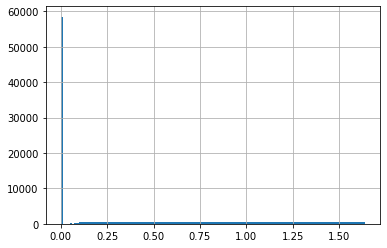

In [195]:
indirim_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.15, pasifik_df_sorted.indirim__.max()+1]
#indirim_bins = [0, 0.009, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, pasifik_df_sorted.indirim__.max()+1]
pasifik_df_sorted.indirim__.hist(bins=indirim_bins)
len(indirim_bins) , pasifik_df_sorted.indirim__.value_counts(bins=indirim_bins).sort_index()
pasifik_df_sorted['indirim__bins'] = pd.cut(pasifik_df_sorted.indirim__, indirim_bins).cat.codes

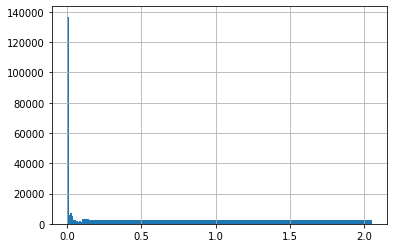

In [196]:
indirim_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.15, horizon_saha_df_sorted.indirim__.max()+1]
horizon_saha_df_sorted.indirim__.hist(bins=indirim_bins)
len(indirim_bins) , horizon_saha_df_sorted.indirim__.value_counts(bins=indirim_bins)
horizon_saha_df_sorted['indirim__bins'] = pd.cut(horizon_saha_df_sorted.indirim__, indirim_bins).cat.codes

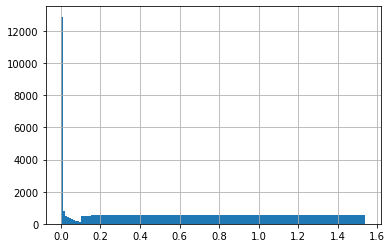

In [197]:
indirim_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.15, btt_df_sorted.indirim__.max()+1]
btt_df_sorted.indirim__.hist(bins=indirim_bins)
len(indirim_bins) , btt_df_sorted.indirim__.value_counts(bins=indirim_bins)
btt_df_sorted['indirim__bins'] = pd.cut(btt_df_sorted.indirim__, indirim_bins).cat.codes

---
# Missing Imputation
---

In [198]:
def missing_imputation(data):
    df_all = []
    data["new_adet"] = data["adet"]
    for sku in data["en_guncel_kod"].unique():
        for grup in data["grup_adi"].unique():
            test = data[(data["en_guncel_kod"] == sku) & (data["grup_adi"] == grup)]
            index_full = list(test[test["new_adet"] != 1].index)
            for idx in range(len(index_full) - 1):
                if index_full[idx+1] - index_full[idx] != 1:
                    index_na = list(range(index_full[idx]+1, index_full[idx+1]))
                    fark = test.loc[index_full[idx+1], "new_adet"] - test.loc[index_full[idx], "new_adet"]
                    bol = len(index_na)
                    ekle = fark/(bol+1)
                    for i in index_na:
                        test.loc[i, "new_adet"] = 0
                        test.loc[i, "new_adet"] += ekle+test.loc[i-1, "new_adet"]
                else:
                    pass
            df_all.append(test)
    df_all = pd.concat(df_all)
    return df_all

In [199]:
start_time = datetime.now()

In [200]:
pasifik_df_sorted = missing_imputation(pasifik_df_sorted)
horizon_saha_df_sorted = missing_imputation(horizon_saha_df_sorted)
btt_df_sorted = missing_imputation(btt_df_sorted)

In [201]:
end_time = datetime.now()
print('Missing Imputation süresi: {}'.format(end_time - start_time))

Missing Imputation süresi: 0:02:59.890515


In [202]:
pasifik_regression = pasifik_df_sorted.copy()
horizon_regression = horizon_saha_df_sorted.copy()
btt_regression = btt_df_sorted.copy()

In [203]:
pasifik_regression = pasifik_regression[pasifik_regression["new_adet"] != 1].reset_index(drop=True)
horizon_regression = horizon_regression[horizon_regression["new_adet"] != 1].reset_index(drop=True)
btt_regression = btt_regression[btt_regression["new_adet"] != 1].reset_index(drop=True)

In [204]:
def trend_seasonality_decomp(data):
    df_all = []
    for sku in data["en_guncel_kod"].unique():
        for grup in data["grup_adi"].unique():
#           print(grup, sku)
            temp_df = data[(data["en_guncel_kod"] == sku) & 
                           (data["grup_adi"] == grup)]
            if len(temp_df) > 2:
#                print(sku, grup)
                df_ts = temp_df[['new_adet','date']]
                df_ts.set_index('date',inplace=True)

                result = STL(df_ts).fit()
                temp_df['season'] = list(result.seasonal)
                temp_df['trend']  = list(result.trend)
                temp_df['residual']  = list(result.resid)
                df_all.append(temp_df)
            else:
                pass
    df_all = pd.concat(df_all)
    return df_all

In [205]:
pasifik_df_sorted.sort_values(by=["en_guncel_kod", "grup_adi", "date"], ignore_index=True, inplace=True)
horizon_saha_df_sorted.sort_values(by=["en_guncel_kod", "grup_adi", "date"], ignore_index=True, inplace=True)
btt_df_sorted.sort_values(by=["en_guncel_kod", "grup_adi", "date"], ignore_index=True, inplace=True)

btt_df_sorted.drop_duplicates(subset=["grup_adi", "en_guncel_kod", "date"], keep="first", ignore_index=True, inplace=True)
horizon_saha_df_sorted.drop_duplicates(subset=["date", "grup_adi", "en_guncel_kod"], keep="first", ignore_index=True, inplace=True)

In [206]:
pasifik_reg = pasifik_df_sorted[pasifik_df_sorted["scope"] == 3]
horizon_reg = horizon_saha_df_sorted[horizon_saha_df_sorted["scope"] == 3]
btt_reg = btt_df_sorted[btt_df_sorted["scope"] == 3]

In [207]:
start_time = datetime.now()

In [208]:
pasifik_df = trend_seasonality_decomp(pasifik_df_sorted)
horizon_df = trend_seasonality_decomp(horizon_saha_df_sorted)
btt_df = trend_seasonality_decomp(btt_df_sorted)

In [209]:
end_time = datetime.now()
print('Trend Seasonality süresi: {}'.format(end_time - start_time))

Trend Seasonality süresi: 0:03:11.481595


---
# Yeni adet flaglendi
---

In [210]:
pasifik_df["adet_flag"] = np.where(pasifik_df["adet"] - pasifik_df["new_adet"] == 0, 0, 1)
horizon_df["adet_flag"] = np.where(horizon_df["adet"] - horizon_df["new_adet"] == 0, 0, 1)
btt_df["adet_flag"] = np.where(btt_df["adet"] - btt_df["new_adet"] == 0, 0, 1)

In [211]:
pasifik_df_sorted = pasifik_df.copy()
horizon_saha_df_sorted = horizon_df.copy()
btt_df_sorted = btt_df.copy()

In [212]:
horizon_saha_df_sorted["aktivite_tipi"] = np.nan
btt_df_sorted["aktivite_tipi"] = np.nan

In [213]:
pasifik_df_sorted.rename(columns={'i̇ndirimli_raf_satis_fiyati': 'ciro_kull_i̇ade_dus',
                                  'raf_tavsiye_satis_fiyati': 'promosyon_tutari'}, inplace=True)

In [214]:
pasifik_df_sorted["Kanal"] = "pasifik"
horizon_saha_df_sorted["Kanal"] = "horizon"
btt_df_sorted["Kanal"] = "btt"

In [215]:
scope_dict = {0: "kapsam_disi", 1: "ortalama_basilacak", 2: "ts", 3: "regresyon"}

In [216]:
pasifik_df_sorted["scope_type"] = pasifik_df_sorted["scope"].map(scope_dict)
horizon_saha_df_sorted["scope_type"] = horizon_saha_df_sorted["scope"].map(scope_dict)
btt_df_sorted["scope_type"] = btt_df_sorted["scope"].map(scope_dict)

In [217]:
df_all = pd.concat([pasifik_df_sorted, horizon_saha_df_sorted, btt_df_sorted], axis=0, ignore_index=True)

---
# Aktivite Dictionary
---

In [218]:
aktivite_dict = {0:0, 'Mağaza içi/Dağılım':2, 'İn&out':5, 
                 'Çoklu Alım':8, 'Mutluluk':11, 'Kasiyer':14, 'CRM':17}

df_all.aktivite_tipi.fillna(0, inplace=True)
df_all.aktivite_tipi = df_all.aktivite_tipi.map(aktivite_dict)

In [219]:
d = datetime.now()
df_all.to_excel("../data/data_backup/all_data_{}_{}_{}_{}_{}.xlsx".format(d.year, d.month, d.day, d.minute, d.second), index=False)

---
# Datanın dışarıya aktarılması
### Fiyata Göre Sıralanmış Datanın Dışarıya Aktarılması
---

In [220]:
start_time = datetime.now()

In [221]:
try:
    df_all.drop("kanal", axis=1, inplace=True)
except:
    pass

In [222]:
#df_all = df_all[~((df_all["yil"] == 2021) & (df_all["ay"].isin([6, 7, 8, 9])))]
data_main_ = df_all.copy()
df = df_all.copy()
df2 = df_all.copy()
df3 = df2[["yil", "ay", "Kanal", "grup_adi", "urun_adi", "date", "new_adet"]]

In [223]:
end_time = datetime.now()
print('Datayı dışarıya çıkarma süresi: {}'.format(end_time - start_time))

Datayı dışarıya çıkarma süresi: 0:00:00.679005


# Eşlenik Kod ve Ürün İsim Kod kısmında düzenleme

In [224]:
urun_isim_kod = df2[["urun_adi", "en_guncel_kod"]].drop_duplicates(subset=["urun_adi", "en_guncel_kod"], ignore_index=True)
urun_isim_kod.rename(columns={"urun_adi": "urun"}, inplace=True)

In [225]:
eslenik_kod_df.rename(columns={"en_guncel_kod": "en_guncel_kod", "urun_adi_orjinal": "new_urun"}, inplace=True)
eslenik_kod_df = eslenik_kod_df[eslenik_kod_df["en_guncel_kod"] != "delist"].reset_index(drop=True)
eslenik_kod_df["en_guncel_kod"] = eslenik_kod_df["en_guncel_kod"].astype("int64")

In [226]:
indexes = []
for idx in eslenik_kod_df.index:
    if eslenik_kod_df["kod1"][idx] == eslenik_kod_df["en_guncel_kod"][idx]:
        indexes.append(idx)

eslenik_kod_df2 = eslenik_kod_df[eslenik_kod_df.index.isin(indexes)].reset_index(drop=True)
eslenik_kod_df2 = eslenik_kod_df2[["en_guncel_kod", "new_urun"]]

---
# Datanı altına kombinasyonların eklenmesi
---

In [227]:
data = df_all[(df_all["portfoy"] == 1) & (df_all["scope_type"] != "kapsam_disi")].reset_index(drop=True)
data_backup = data.copy()
sku_list = data.drop_duplicates(subset=["grup_adi", "en_guncel_kod"], keep="first", ignore_index=True)[["grup_adi", "en_guncel_kod", "Kanal"]]

In [228]:
datetime(2021, 10, 1)-relativedelta(months=4)

datetime.datetime(2021, 6, 1, 0, 0)

In [229]:
def create_enflasyon(df):
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
    if month_ == 12:
        month_ = 1
        year_+=1
    else:
        month_+=1

    enflasyon_data = df[(df["date"] >= datetime(year_, month_, 1)-relativedelta(months=4))]
    enflasyon_data = enflasyon_data[["yil", "ay", "date", "enflasyon_etkisi"]].drop_duplicates(subset=["ay", "yil", "date", "enflasyon_etkisi"], ignore_index=True)
    enflasyon_data = pd.concat([enflasyon_data]*2, ignore_index=True)
    
    for idx in range(4, len(enflasyon_data)):
        new_date = datetime(year_, month_, 1) + relativedelta(months=idx-4)
        enflasyon_data.loc[idx, "enflasyon_etkisi"] = np.nan
        enflasyon_data.loc[idx, "yil"] = new_date.year
        enflasyon_data.loc[idx, "ay"] = new_date.month
        enflasyon_data.loc[idx, "date"] = new_date
    for idx in range(4, len(enflasyon_data)):
        enflasyon_data.loc[idx, "enflasyon_etkisi"] = enflasyon_data.loc[idx-4: idx-1, "enflasyon_etkisi"].mean()
    enf_prev = data[data["date"] < datetime(year_, month_, 1)][["yil", "ay", 
                                                                "date", "enflasyon_etkisi"]].drop_duplicates(subset=["yil", "ay", 
                                                                                                                     "date", "enflasyon_etkisi"]).sort_values(by="date", ignore_index=True)
    enflasyon_final = pd.concat([enf_prev, enflasyon_data.iloc[-4:, :]], axis=0, ignore_index=True)
    return enflasyon_final

In [230]:
enflasyon_data = create_enflasyon(data)

In [231]:
enf_dict_fill = {}
for idx in range(len(enflasyon_data)):
    enf_dict_fill.update({enflasyon_data["date"][idx]: enflasyon_data["enflasyon_etkisi"][idx]})

In [232]:
start_time = datetime.now()

In [233]:
def create_comb(excels):
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
    pas_s=list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 2, 5, 8, 11, 14, 17]))
    diger_s=list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0]))
    df_all__=[]
    for i in range(len(sku_list)):
        tmp_=excels[(excels["grup_adi"] == sku_list.loc[i, "grup_adi"]) & 
                   (excels["en_guncel_kod"] == sku_list.loc[i, "en_guncel_kod"])]
        new_date = datetime(year_, month_, 1)
        if tmp_['Kanal'].values[0]=='pasifik':
            for trh in range(1, 5):
                new_date_ = new_date + relativedelta(months=trh)
                create_new = pd.DataFrame(tmp_.iloc[-1])
                create_new.loc["yil"] = new_date_.year
                create_new.loc["ay"] = new_date_.month
                create_new.loc["date"] = datetime(new_date_.year, new_date_.month, 1)
                create_new.loc["new_adet"] = np.nan
                create_new.loc["adet"] = np.nan
                create_new.loc["koli"] = np.nan
                create_new.loc["kg"] = np.nan
                create_new.loc["tl"] = np.nan
                create_new.loc["satis_var"] = np.nan
                create_new.loc["enflasyon_etkisi"] = np.nan
                create_new.loc["yarisma"] = np.nan
                create_new.loc["peak"] = 0
                create_new.loc["fiyat"] = np.nan
                create_new.loc["fiyat_gecisi"] = np.nan
                create_new.loc["pandemic"] = 1
                create_new.loc["lockdown"] = 0
                create_new.loc["season"] = np.nan
                create_new.loc["trend"] = np.nan
                tmp = pd.concat([create_new.T]*len(pas_s), ignore_index=True)
                for j in range(len(pas_s)):
                    tmp.loc[j,'indirim__bins'] = pas_s[j][0]
                    tmp.loc[j,'aktivite_tipi'] = pas_s[j][1]
                df_all__.append(tmp)
        else:
            for trh in range(1, 5):
                new_date_ = new_date + relativedelta(months=trh)
                create_new = pd.DataFrame(tmp_.iloc[-1])
                create_new.loc["yil"] = new_date_.year
                create_new.loc["ay"] = new_date_.month
                create_new.loc["date"] = datetime(new_date_.year, new_date_.month, 1)
                create_new.loc["new_adet"] = np.nan
                create_new.loc["adet"] = np.nan
                create_new.loc["koli"] = np.nan
                create_new.loc["kg"] = np.nan
                create_new.loc["tl"] = np.nan
                create_new.loc["satis_var"] = np.nan
                create_new.loc["enflasyon_etkisi"] = np.nan
                create_new.loc["yarisma"] = np.nan
                create_new.loc["peak"] = 0
                create_new.loc["fiyat"] = np.nan
                create_new.loc["fiyat_gecisi"] = np.nan
                create_new.loc["pandemic"] = 1
                create_new.loc["lockdown"] = 0
                create_new.loc["season"] = np.nan
                create_new.loc["trend"] = np.nan
                tmp = pd.concat([create_new.T]*len(diger_s), ignore_index=True)
                for k in range(len(diger_s)):
                    tmp.loc[k,'indirim__bins']=diger_s[k][0]
                    tmp.loc[k,'aktivite_tipi']=diger_s[k][1]
                df_all__.append(tmp)
    df_all__ = pd.concat(df_all__, ignore_index=True)
    return df_all__

In [234]:
all_combinations = create_comb(data)

In [235]:
all_combinations = all_combinations[['new_adet', 'yil', 'ay', 'date', 'Kanal', 'grup_adi', 'ana_kategori_adi', 
                                     'kategori_adi', 'marka_adi', 'urun_adi', 'enflasyon_etkisi',  'peak', 'indirim__bins', 
                                     'aktivite_tipi', 'lockdown', 'season', 'trend', 'scope', 'scope_type', 'portfoy']]

all_combinations["enflasyon_etkisi"] = all_combinations["date"].map(enf_dict_fill)

In [236]:
all_combinations.date.value_counts()

2021-10-01    41288
2022-01-01    41288
2021-11-01    41288
2021-12-01    41288
Name: date, dtype: int64

In [237]:
end_time = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_time - start_time))

Kodun çalışma süresi: 0:05:01.617468


In [238]:
start_time = datetime.now()

In [239]:
def create_combination_df(df_):
    """ 
    Tüm kombinasyonlar için bir dictionary içerisinde 91 tane dataframe oluşturuyor. Input olarak aldığı df'in sonuna 3 satır 
    ekleyip indirim__bins ve aktivite_tipi'ni df_indirimbins_aktivitetipi olacak şekilde giriyor. new_adet değişkenine son 3 satır için NA atıyor.  
    """

    indirim_bins_list = ['minus_one','zero','one','two','three','four','five','six','seven','eight','nine','ten','eleven']
    aktivite_tipi_list = ['zero','two','five','eight','eleven','fourteen','seventeen']
    df_names_dict = list(itertools.product(indirim_bins_list, aktivite_tipi_list))

    ind_akt = list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 2, 5, 8, 11, 14, 17]))

    df_names = []
    for idx in df_names_dict:
        df_names.append('df_' + idx[0] + '_' + idx[1])

    df_dict = {}
    for i in range(len(df_names)):
        main_data = data.copy()
        tmp = df_[(df_["aktivite_tipi"] == ind_akt[i][1]) & 
                  (df_["indirim__bins"] == ind_akt[i][0])]

        new_comb_with_main_data = pd.concat([main_data, tmp], ignore_index=True)
        new_comb_with_main_data.sort_values(by=["en_guncel_kod", "grup_adi", "date"], inplace=True, ignore_index=True)
        df_dict[df_names[i]] = new_comb_with_main_data.copy()
    return df_dict

In [240]:
all_combs_df = create_combination_df(all_combinations)

In [241]:
end_time = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_time - start_time))

Kodun çalışma süresi: 0:00:23.529227


In [242]:
start_time = datetime.now()

In [243]:
data_list = list(all_combs_df.keys())

for dfs in data_list:
    tmp = all_combs_df[dfs]
    tmp = tmp[tmp["scope_type"] == "ts"]
    tmp = tmp[["date", "new_adet", "ana_kategori_adi", "grup_adi", "Kanal", "kategori_adi", "marka_adi", "urun_adi", "aktivite_tipi",
               "enflasyon_etkisi", "indirim__bins", "lockdown", "peak", "season", "trend"]]
    tmp["enflasyon_etkisi"] = tmp["date"].map(enf_dict_fill)
    tmp["new_adet"] = tmp["new_adet"].astype("float")
    tmp["aktivite_tipi"] = tmp["aktivite_tipi"].astype("float")
    tmp["indirim__bins"] = tmp["indirim__bins"].astype("float")
    tmp["lockdown"] = tmp["lockdown"].astype("float")
    tmp["peak"] = tmp["peak"].astype("float")
    tmp["date"] = tmp["date"].apply(lambda x: (x - datetime(1960, 1, 1)).days)
    try: 
        conn.userinfo()
    except: 
        print("SWAT connections was never created or you lost the connection. Trying to create connection...")
        access_ = True
        while access_:
            try:
                conn = swat.CAS('yhtrcl-sasccnt1.yildiz.domain', 5570, username=params_["login_info"]["username"], password=params_["login_info"]["password"])
                access_ = False
                print("Accessed!")
            except:
                print("Got error. Trying to reconnect...")
                continue
    ds_table = conn.CASTable(dfs, caslib=params_["caslib_info"]["caslib_name"], replace=True)
    ds_table.table.dropTable(quiet=True)
    conn.upload(data=tmp, casout={'caslib':params_["caslib_info"]["caslib_name"], 'name':dfs, 'promote':True}, 
                importoptions={'vars':{'date':{'format': 'MMDDYY', "type": "double", "length": 10}}})

SWAT connections was never created or you lost the connection. Trying to create connection...
Accessed!
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_ZERO in caslib DSENS_T.
NOTE: The table DF_MINUS_ONE_ZERO has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_TWO in caslib DSENS_T.
NOTE: The table DF_MINUS_ONE_TWO has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_FIVE in caslib DSENS_T.
NOTE: The table DF_MINUS_ONE_FIVE has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DF_MINUS_ONE_EIGHT in caslib DSENS_T.
NOTE: The table DF_MINUS_ONE_EIGHT has been created in caslib DSENS_T from binary data uploa

In [244]:
output_data_list = [i.replace("df_", "ts_results_") for i in data_list]
input_names = pd.DataFrame({"tables": data_list})
output_names = pd.DataFrame({"tables": output_data_list})

In [245]:
ds_table = conn.CASTable("DS_COMB_INPUT_TABLE_NAMES", caslib=params_["caslib_info"]["caslib_name"], replace=True)
ds_table.table.dropTable(quiet=True)

ds_table = conn.CASTable("DS_COMB_OUTPUT_TABLE_NAMES", caslib=params_["caslib_info"]["caslib_name"], replace=True)
ds_table.table.dropTable(quiet=True)

conn.upload(data=input_names, casout={'caslib':params_["caslib_info"]["caslib_name"], 'name':'DS_COMB_INPUT_TABLE_NAMES', 'promote':True})
conn.upload(data=output_names, casout={'caslib':params_["caslib_info"]["caslib_name"], 'name':'DS_COMB_OUTPUT_TABLE_NAMES', 'promote':True})

NOTE: Cloud Analytic Services made the uploaded file available as table DS_COMB_INPUT_TABLE_NAMES in caslib DSENS_T.
NOTE: The table DS_COMB_INPUT_TABLE_NAMES has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table DS_COMB_OUTPUT_TABLE_NAMES in caslib DSENS_T.
NOTE: The table DS_COMB_OUTPUT_TABLE_NAMES has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.


[caslib]

 'DSENS_T'

[tableName]

 'DS_COMB_OUTPUT_TABLE_NAMES'

[casTable]

 CASTable('DS_COMB_OUTPUT_TABLE_NAMES', caslib='DSENS_T')

+ Elapsed: 0.111s, user: 0.0186s, sys: 0.0285s, mem: 33.9mb

In [246]:
end_time = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_time - start_time))

Kodun çalışma süresi: 0:30:02.183990


In [247]:
end_all_process = datetime.now()
print('Kodun çalışma süresi: {}'.format(end_all_process - start_all_process))

Kodun çalışma süresi: 1:42:47.138546


---
# MODELLEME KISMI
---

In [248]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

In [249]:
start_time = datetime.now()

In [250]:
tmp = df.copy()
tmp = tmp[(tmp["scope_type"] == "ts") & (tmp["portfoy"] == 1)]
tmp = tmp[["date", "new_adet", "ana_kategori_adi", "grup_adi", "Kanal", "kategori_adi", "marka_adi", "urun_adi", "aktivite_tipi",
           "enflasyon_etkisi", "indirim__bins", "lockdown", "peak", "season", "trend"]]

In [251]:
tmp = df.copy()
tmp = tmp[(tmp["scope_type"] == "ts") & (tmp["portfoy"] == 1)]
tmp = tmp[["date", "new_adet", "ana_kategori_adi", "grup_adi", "Kanal", "kategori_adi", "marka_adi", "urun_adi", "aktivite_tipi",
           "enflasyon_etkisi", "indirim__bins", "lockdown", "peak", "season", "trend"]]
tmp["new_adet"] = tmp["new_adet"].astype("float")
tmp["aktivite_tipi"] = tmp["aktivite_tipi"].astype("float")
tmp["indirim__bins"] = tmp["indirim__bins"].astype("float")
tmp["lockdown"] = tmp["lockdown"].astype("float")
tmp["peak"] = tmp["peak"].astype("float")
tmp["date"] = pd.to_datetime(tmp["date"], format="%Y-%m-%d", errors="coerce")
tmp["date"] = tmp["date"].apply(lambda x: (x - datetime(1960, 1, 1)).days)

ds_table = conn.CASTable("DF_MAIN", caslib=params_["caslib_info"]["caslib_name"], replace=True)
ds_table.table.dropTable(quiet=True)

conn.upload(data=tmp, casout={'caslib':params_["caslib_info"]["caslib_name"], 'name':"DF_MAIN", 'promote':True}, 
            importoptions={'vars':{'date':{'format': 'MMDDYY', "type": "double", "length": 10}}})

NOTE: Cloud Analytic Services made the uploaded file available as table DF_MAIN in caslib DSENS_T.
NOTE: The table DF_MAIN has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.


[caslib]

 'DSENS_T'

[tableName]

 'DF_MAIN'

[casTable]

 CASTable('DF_MAIN', caslib='DSENS_T')

+ Elapsed: 17s, user: 0.351s, sys: 0.187s, mem: 52.2mb

In [252]:
os.system("python ../pyviyatools/submit_jobdef.py -id {}".format(params_["sas_job"]["ts_job_id"]))

0

In [253]:
end_time = datetime.now()
print('SAS TS script triger süresi: {}'.format(end_time - start_time))

SAS TS script triger süresi: 0:03:51.676848


In [254]:
indirim_bins_list = ['minus_one','zero','one','two','three','four','five','six','seven','eight','nine','ten','eleven']
aktivite_tipi_list = ['zero','two','five','eight','eleven','fourteen','seventeen']
df_names_dict = list(itertools.product(indirim_bins_list, aktivite_tipi_list))

ind_akt = list(itertools.product([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],[0, 2, 5, 8, 11, 14, 17]))

df_names = []
for idx in df_names_dict:
    df_names.append('df_' + idx[0] + '_' + idx[1])

# ts kombinasyonlarını dataframe'de tutabilmek için bunu yapıyoruz.
df_ts_comb_names = [i.replace("df", "ts_results") for i in df_names]

In [255]:
start_time = datetime.now()

In [256]:
ts_comb_results = []
for dfs in df_ts_comb_names:
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
    if month_ == 12:
        month_ = 1
        year+=1
    else:
        month_+=1

    date_greater = datetime(year_, month_, 1) - relativedelta(months=1)
    date_less = datetime(year_, month_, 1) + relativedelta(months=4)
    try: 
        conn.userinfo()
    except: 
        print("SWAT bağlantısı koptu. Bağlantı tekrar kuruluyor.")
        access_ = True
        while access_:
            try:
                conn = swat.CAS('yhtrcl-sasccnt1.yildiz.domain', 5570, username=params_["login_info"]["username"], password=params_["login_info"]["password"])
                access_ = False
                print("Accessed!")
            except:
                print("Got error. Trying to reconnect...")
                continue
    outfor = pd.DataFrame(conn.CASTable(caslib=params_["caslib_info"]["caslib_name"],name=dfs).to_frame())
    outfor = outfor[["Kanal", "grup_adi", "urun_adi", "date", "ACTUAL", "PREDICT"]]
    outfor["date"] = pd.to_datetime(outfor["date"], format="%Y-%m-%d", errors="coerce")
    outfor = outfor[(outfor["date"] > date_greater) & (outfor["date"] < date_less)]
    outfor["data_from"] = dfs
    ts_comb_results.append(outfor)

In [257]:
ts_comb_results = pd.concat(ts_comb_results, ignore_index=True)

In [258]:
try: 
    conn.userinfo()
except: 
    print("SWAT bağlantısı koptu. Bağlantı tekrar kuruluyor.")
    access_ = True
    while access_:
        try:
            conn = swat.CAS('yhtrcl-sasccnt1.yildiz.domain', 5570, username=params_["login_info"]["username"], password=params_["login_info"]["password"])
            access_ = False
            print("Accessed!")
        except:
            print("Got error. Trying to reconnect...")
            continue
df_ts = pd.DataFrame(conn.CASTable(caslib=params_["caslib_info"]["caslib_name"],name="TS_RESULTS_MAIN").to_frame())

In [259]:
df_ts = df_ts[["Kanal", "grup_adi", "urun_adi", "date", "ACTUAL", "PREDICT"]]
df_ts["date"] = pd.to_datetime(df_ts["date"], format="%Y-%m-%d", errors="coerce")

In [260]:
month_ = params_["time_info_for_debugging"]["ay"]
year_ = params_["time_info_for_debugging"]["yil"]
#    month_ = datetime.now().month
#    year_ = datetime.now().year
if month_ == 12:
    month_ = 1
    year+=1
else:
    month_+=1

ytrue_all = []
yhat_all = []
sku_all = []
grp_all = []
date_all = []
mape_ts = []
sku_ts = []
grup_adi_ts = []
for sku in df_ts.urun_adi.unique():
    for grp in df_ts.grup_adi.unique():
        temp_df = df_ts[(df_ts["grup_adi"] == grp) & (df_ts["urun_adi"] == sku)]
        if len(temp_df) < 1:
            pass
        else:
            if month_ < 7:
                temp_df = temp_df[(temp_df["date"] > datetime(year_-1, month_+6, 1)) & (temp_df["date"] < datetime(year_, month_, 1)) & (temp_df["ACTUAL"] != 0)]
                ytrue = temp_df.iloc[-6:, -2:-1]
                yhat = temp_df.iloc[-6:, -1:]
                date_ = temp_df.iloc[-6:, -3:-2]
                mape_ts.append(mape(np.array(ytrue), np.array(yhat)))
                sku_ts.append(sku)
                grup_adi_ts.append(grp)

                ytrue_all.extend(list(ytrue.ACTUAL))
                yhat_all.extend(list(yhat.PREDICT))
                sku_all.extend([sku]*len(ytrue))
                grp_all.extend([grp]*len(ytrue))
                date_all.extend(list(date_.date))
            else:
                temp_df = temp_df[(temp_df["date"] > datetime(year_, month_-6, 1)) & (temp_df["date"] < datetime(year_, month_, 1)) & (temp_df["ACTUAL"] != 0)]
                ytrue = temp_df.iloc[-6:, -2:-1]
                yhat = temp_df.iloc[-6:, -1:]
                date_ = temp_df.iloc[-6:, -3:-2]
                mape_ts.append(mape(np.array(ytrue), np.array(yhat)))
                sku_ts.append(sku)
                grup_adi_ts.append(grp)

                ytrue_all.extend(list(ytrue.ACTUAL))
                yhat_all.extend(list(yhat.PREDICT))
                sku_all.extend([sku]*len(ytrue))
                grp_all.extend([grp]*len(ytrue))
                date_all.extend(list(date_.date))
ts_results =  pd.DataFrame({"grup": grup_adi_ts,
                            "urun_adi": sku_ts,
                            "mape": mape_ts})

In [261]:
ts_results["mape_bins"] = ts_results["mape"].apply(lambda x: "10'dan küçük" \
                                                   if x<10 else ("10 ile 20 arasında" \
                                                                 if x<20 else ("20 ile 30 arasında" \
                                                                               if x<30 else("30 ile 50 arasında" \
                                                                                            if x<50 else("50 ile 100 arasında" \
                                                                                                         if x<100 else "100'den büyük")))))

In [262]:
kanal_dict = {'Diğer_Pasifik': 'pasifik', 
              'MİGROS': 'pasifik', 
              'ŞOK': 'pasifik', 
              'A101': 'pasifik', 
              'BİM': 'pasifik', 
              'Diğer_Horizon': 'horizon',
              'GELENEKSEL KANAL': 'horizon', 
              'ORTA MARKET': 'horizon', 
              'POTANSİYEL MARKET': 'horizon',
              'YEREL ZİNCİR': 'horizon',
              'BTT': 'btt'}

ts_results["kanal_l"] = ts_results["grup"].map(kanal_dict)

In [263]:
ts_results_raw_data = pd.DataFrame({"grup": grp_all,
                                    "urun_adi": sku_all,
                                    "date": date_all,
                                    "ytrue": ytrue_all,
                                    "yhat": yhat_all})

In [264]:
ts_results_raw_data = ts_results_raw_data.merge(ts_results[["kanal_l", "grup"]].drop_duplicates(subset=["kanal_l", "grup"]), how="left", on="grup")
ts_list_to_reg = ts_results[ts_results["mape"] >= 30][["grup", "urun_adi"]].drop_duplicates(subset=["grup", "urun_adi"], ignore_index=True, keep="first")

---
# Regresyona girecek ürünlerin listesini burada tutuyoruz
---

# EDA
---

In [265]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d', errors="coerce")

In [266]:
df_reg = df[(df["scope"] == 3) & (df["portfoy"] == 1)]

In [267]:
try:
    cols_to_drop = ['en_guncel_kod', 'koli_i̇ci_adet', 'koli',
                    'kg', 'tl', 'adet', 'satis_var', 'promosyon_tutari',
                    'ciro_kull_i̇ade_dus', 'weekdays_ratio', 'weekend_ratio',
                    'total_holiday_ratio', 'school_day_ratio', 'school_day_brdg_n', 'school_day_brdg_ratio',
                    'ramadan_ratio', 'gozlem_sayisi', 'actual_holiday_ratio',
                    'toplam_satir', 'oran', 'baslangic_tarih', 'bitis_tarih',
                    'son_kac_ay_eksik', 'eksik_repeat_sayisi', 'adet_flag', 
                    'scope_type', 'durum']
    df_droped = df[cols_to_drop]
except:
    cols_to_drop = ['en_guncel_kod', 'koli_i̇ci_adet', 'koli',
                    'kg', 'tl', 'adet', 'satis_var', 'promosyon_tutari',
                    'ciro_kull_i̇ade_dus', 'weekdays_ratio', 'weekend_ratio',
                    'total_holiday_ratio', 'school_day_ratio', 'school_day_brdg_n', 'school_day_brdg_ratio',
                    'ramadan_ratio', 'gozlem_sayisi', 'actual_holiday_ratio',
                    'toplam_satir', 'oran', 'baslangic_tarih', 'bitis_tarih',
                    'son_kac_ay_eksik', 'eksik_repeat_sayisi', 'scope_type', 'durum']
    df_droped = df[cols_to_drop]

In [268]:
df.drop(columns=cols_to_drop, axis=1, inplace=True)
df.rename(columns={"Kanal": "kanal"}, inplace=True)
df_reg = df_reg[df_reg["portfoy"] == 1]
df_reg.drop(columns=["portfoy", "scope"], axis=1, inplace=True)

In [269]:
X_vars = ['yil', 'ay', 'date', 'Kanal', 'grup_adi', 'ana_kategori_adi', 
          'kategori_adi', 'marka_adi', 'urun_adi', 'enflasyon_etkisi', 
          'peak', 'indirim__bins', 'aktivite_tipi', 'lockdown', 'season', 'trend']

y_vars = ["new_adet"]

In [270]:
df_reg = df_reg[X_vars+y_vars]

In [271]:
df_reg["enflasyon_etkisi"].fillna(method="ffill", inplace=True)

In [272]:
ts_to_reg_df = []
for row in range(len(ts_list_to_reg)):
    tmp = df[(df["urun_adi"] == ts_list_to_reg["urun_adi"][row]) & (df["grup_adi"] == ts_list_to_reg["grup"][row])]
    ts_to_reg_df.append(tmp)
ts_to_reg_df = pd.concat(ts_to_reg_df)
ts_to_reg_df.reset_index(drop=True, inplace=True)
ts_to_reg_df.drop_duplicates(subset=ts_to_reg_df.columns.to_list(), ignore_index=True, inplace=True)

In [273]:
ts_to_reg_df.rename(columns={"kanal": "Kanal"}, inplace=True)
ts_to_reg_df = ts_to_reg_df[df_reg.columns.to_list()]

In [274]:
df_reg = pd.concat([df_reg, ts_to_reg_df], axis=0, ignore_index=True)
df_reg["enflasyon_etkisi"].fillna(method="ffill", inplace=True)

In [275]:
le_kanal = LabelEncoder()
le_grup_adi = LabelEncoder()
le_ana_kategori_adi = LabelEncoder()
le_kategori_adi = LabelEncoder()
le_marka_adi = LabelEncoder()
le_urun_adi = LabelEncoder()

df_reg["Kanal"] = le_kanal.fit_transform(df_reg["Kanal"])
df_reg["grup_adi"] = le_grup_adi.fit_transform(df_reg["grup_adi"])
df_reg["ana_kategori_adi"] = le_ana_kategori_adi.fit_transform(df_reg["ana_kategori_adi"])
df_reg["kategori_adi"] = le_kategori_adi.fit_transform(df_reg["kategori_adi"])
df_reg["marka_adi"] = le_marka_adi.fit_transform(df_reg["marka_adi"])
df_reg["urun_adi"] = le_urun_adi.fit_transform(df_reg["urun_adi"])

In [276]:
def trend_seasonality_decomp(data):
    df_all = []
    for sku in data["urun_adi"].unique():
        for grup in data["grup_adi"].unique():
            temp_df = data[(data["urun_adi"] == sku) & 
                           (data["grup_adi"] == grup)]

            if len(temp_df) > 2:
#                print(sku, grup)
                df_ts = temp_df[['new_adet','date']]
                df_ts.set_index('date',inplace=True)

                result = STL(df_ts).fit()
                temp_df['season'] = list(result.seasonal)
                temp_df['trend']  = list(result.trend)
                df_all.append(temp_df)
            else:
                pass
    df_all = pd.concat(df_all)
    return df_all

In [277]:
df_reg = trend_seasonality_decomp(df_reg)

---
# Son 3 aya seasonality ve trend eklenmesi
---

In [278]:
loop_list = df_reg.drop_duplicates(subset=["urun_adi", "grup_adi"], ignore_index=True)[["urun_adi", "grup_adi"]]

df_all = []
for idx in loop_list.index:
    test = df_reg[(df_reg["urun_adi"] == loop_list["urun_adi"][idx]) & (df_reg["grup_adi"] == loop_list["grup_adi"][idx])]
    trend_idx = test.iloc[-7:-3, :].index
    calc_df = test.loc[trend_idx, ["date", "trend"]]
    last_value = calc_df.iloc[-1, 1:].values[0]
    first_value = calc_df.iloc[0, 1:].values[0]
    add_value = (last_value - first_value)  / 4

    for index_ in test.iloc[-3:].index:
        if len(test) >= 27:
            test.loc[index_, "season"] = test.loc[index_-24, "season"]
        elif len(test) >= 15 and len(test) < 27:
            test.loc[index_, "season"] = test.loc[index_-12, "season"]
        else:
            test.loc[index_, "season"] = test.loc[list(range(index_-1, index_-7, -1)), "season"].mean()
        test.loc[index_, "trend"] = test.loc[index_-1, "trend"] + add_value
        df_all.append(test)
df_all = pd.concat(df_all)
df_all.drop_duplicates(subset=df_all.columns.to_list(), ignore_index=True, inplace=True)

df_reg = df_all.copy()
df_reg.drop(columns="date", axis=1, inplace=True)

In [279]:
X_train = []
X_test = []
y_train = []
y_test = []
for sku in df_reg.urun_adi.unique():
    for grp in df_reg.grup_adi.unique():
        temp_df = df_reg[(df_reg["urun_adi"] == sku) & (df_reg["grup_adi"] == grp)]
        temp_df.sort_values(by=["yil", "ay"], inplace=True)
        X_train.append(temp_df.iloc[:-3, :-1])
        X_test.append(temp_df.iloc[-3:, :-1])
        y_train.append(temp_df.iloc[:-3, -1:])
        y_test.append(temp_df.iloc[-3:, -1:])

In [280]:
X_train, X_test, y_train, y_test = pd.concat(X_train), pd.concat(X_test), pd.concat(y_train), pd.concat(y_test)

In [281]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15511, 15), (1071, 15), (15511, 1), (1071, 1))

---
# Regresyon
---
# Linear Regression
---

In [282]:
lm = LinearRegression()
lm.fit(X_train, y_train)
yhat_lm = lm.predict(X_test)

In [283]:
print("MAPE:", mape(np.array(y_test), yhat_lm))

MAPE: 124342.06986420412


---
# KNN
---

In [284]:
gsm_knn = KNeighborsRegressor(algorithm=params_["gridsearch_params"]["knn_params"]["algorithm"], 
                              leaf_size=params_["gridsearch_params"]["knn_params"]["leaf_size"], 
                              metric=params_["gridsearch_params"]["knn_params"]["metric"], 
                              n_neighbors=params_["gridsearch_params"]["knn_params"]["n_neighbors"], 
                              weights=params_["gridsearch_params"]["knn_params"]["weights"])
gsm_knn.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=25)

In [285]:
best_params_knn = gsm_knn.get_params()
yhat_knn = gsm_knn.predict(X_test)
print("MAPE:", mape(y_test, yhat_knn))

MAPE: new_adet    100864.628925
dtype: float64


---
# XGBoost
---

In [286]:
gsm_xgb = XGBRegressor(booster=params_["gridsearch_params"]["xgboost_params"]["booster"], 
                       colsample_bytree=params_["gridsearch_params"]["xgboost_params"]["colsample_bytree"], 
                       learning_rate=params_["gridsearch_params"]["xgboost_params"]["learning_rate"], 
                       max_depth=params_["gridsearch_params"]["xgboost_params"]["max_depth"], 
                       min_child_weight=params_["gridsearch_params"]["xgboost_params"]["min_child_weight"], 
                       objective=params_["gridsearch_params"]["xgboost_params"]["objective"], 
                       random_state=params_["gridsearch_params"]["xgboost_params"]["random_state"], 
                       subsample=params_["gridsearch_params"]["xgboost_params"]["subsample"])

gsm_xgb.fit(X_train, y_train)

[15:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.9, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=7,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=8, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=0.5, tree_method=None, validate_parameters=1,
             verbosity=None)

In [287]:
best_params_xgb = gsm_xgb.get_params()
yhat_xgb = gsm_xgb.predict(X_test)
print("MAPE:", mape(np.array(y_test), yhat_xgb))

MAPE: 744875.074324917


---
# Decision Tree
---

In [288]:
gsm_dt = DecisionTreeRegressor(criterion=params_["gridsearch_params"]["decisiontree_params"]["criterion"], 
                               max_depth=params_["gridsearch_params"]["decisiontree_params"]["max_depth"], 
                               min_samples_leaf=params_["gridsearch_params"]["decisiontree_params"]["min_samples_leaf"], 
                               min_samples_split=params_["gridsearch_params"]["decisiontree_params"]["min_samples_split"], 
                               random_state=params_["gridsearch_params"]["decisiontree_params"]["random_state"])

gsm_dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=10, min_samples_leaf=8,
                      min_samples_split=3, random_state=42)

In [289]:
best_params_dt = gsm_dt.get_params()
yhat_dt = gsm_dt.predict(X_test)
print("MAPE:", mape(np.array(y_test), yhat_dt))

MAPE: 710303.7953382271


---
# Random Forest Regressor
---

In [290]:
gsm_rf = RandomForestRegressor(criterion=params_["gridsearch_params"]["randomforest_params"]["criterion"], 
                               max_depth=params_["gridsearch_params"]["randomforest_params"]["max_depth"], 
                               min_samples_leaf=params_["gridsearch_params"]["randomforest_params"]["min_samples_leaf"], 
                               min_samples_split=params_["gridsearch_params"]["randomforest_params"]["min_samples_split"], 
                               random_state=params_["gridsearch_params"]["randomforest_params"]["random_state"])

gsm_rf.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=8, min_samples_leaf=5,
                      min_samples_split=5, random_state=42)

In [291]:
best_params_rf = gsm_rf.get_params()
yhat_rf = gsm_rf.predict(X_test)
print("MAPE:", mape(np.array(y_test), yhat_rf))

MAPE: 709052.5591357916


---
# Gradient Boosting Regressor
---

In [292]:
gsm_gb = GradientBoostingRegressor(criterion=params_["gridsearch_params"]["gradientboosting_params"]["criterion"], 
                                   learning_rate=params_["gridsearch_params"]["gradientboosting_params"]["learning_rate"], 
                                   max_depth=params_["gridsearch_params"]["gradientboosting_params"]["max_depth"], 
                                   max_features=params_["gridsearch_params"]["gradientboosting_params"]["max_features"], 
                                   min_samples_leaf=params_["gridsearch_params"]["gradientboosting_params"]["min_samples_leaf"], 
                                   min_samples_split=params_["gridsearch_params"]["gradientboosting_params"]["min_samples_split"], 
                                   n_estimators=params_["gridsearch_params"]["gradientboosting_params"]["n_estimators"], 
                                   random_state=params_["gridsearch_params"]["gradientboosting_params"]["random_state"], 
                                   subsample=params_["gridsearch_params"]["gradientboosting_params"]["subsample"])
gsm_gb.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mae', learning_rate=0.2, max_depth=5,
                          max_features='log2', min_samples_leaf=0.1,
                          min_samples_split=0.1, n_estimators=10,
                          random_state=42)

In [293]:
best_params_gb = gsm_gb.get_params()
yhat_gb = gsm_gb.predict(X_test)
print("MAPE:", mape(np.array(y_test), yhat_gb))

MAPE: 495711.26511725405


---
# Regresyon test sonuçlarının çıktılarının alınması
---

In [294]:
test_results = X_test.copy()

In [295]:
test_results["Kanal"] = le_kanal.inverse_transform(test_results["Kanal"])
test_results["grup_adi"] = le_grup_adi.inverse_transform(test_results["grup_adi"])
test_results["ana_kategori_adi"] = le_ana_kategori_adi.inverse_transform(test_results["ana_kategori_adi"])
test_results["kategori_adi"] = le_kategori_adi.inverse_transform(test_results["kategori_adi"])
test_results["marka_adi"] = le_marka_adi.inverse_transform(test_results["marka_adi"])
test_results["urun_adi"] = le_urun_adi.inverse_transform(test_results["urun_adi"])

In [296]:
test_results["linear_regression"] = yhat_lm.reshape(-1)
test_results["knn"] = yhat_knn.reshape(-1)
test_results["xgboost"] = yhat_xgb.reshape(-1)
test_results["decision_tree"] = yhat_dt.reshape(-1)
test_results["random_forest"] = yhat_rf.reshape(-1)
test_results["gradient_boosting"] = yhat_gb.reshape(-1)

In [297]:
test_results = pd.concat([test_results, y_test], axis=1)
#test_results.to_excel("../results/36_12_siparis/scores/regression_all_test_results.xlsx", index=False)

In [298]:
kanal_l = []
grup = []
urun_l = []
model_type = []
mape_l = []

for kanal in test_results.Kanal.unique():
    for grp in test_results.grup_adi.unique():
        for urun in test_results.urun_adi.unique():
            for model in test_results.columns.to_list()[-7:-1]:
                temp_df = test_results[(test_results["Kanal"] == kanal) & 
                                       (test_results["grup_adi"] == grp) & 
                                       (test_results["urun_adi"] == urun)]
                kanal_l.append(kanal)
                grup.append(grp)
                urun_l.append(urun)
                model_type.append(model)
                model_com = temp_df[[model, "new_adet"]]
                mape_l.append(mape(np.array(model_com["new_adet"]), np.array(model_com[model])))


results_by_sku = pd.DataFrame({"kanal_l": kanal_l,
                               "grup": grup,
                               "urun": urun_l,
                               "model_type": model_type,
                               "mape": mape_l})

results_by_sku.dropna(inplace=True)

In [299]:
all_params = pd.DataFrame({"models": ["KNN", "Gradient Boosting", "XGBoost", "Decision Tree", "Random Forest"],
                           "parameters": [best_params_knn, best_params_gb, best_params_xgb, best_params_dt, best_params_rf]})

In [300]:
all_params.set_index("models", inplace=True)

In [301]:
try:
    logging.basicConfig(filename='../log/gridsearchparameters.log', encoding='utf-8', level=logging.DEBUG)
    logging.debug('{}'.format(all_params.to_dict()))
except:
    logging.basicConfig(filename='../log/gridsearchparameters.log', encoding='utf-8', level=logging.DEBUG)
    logging.debug('{}'.format(all_params.to_dict()))

In [302]:
d = datetime.now()
all_params.to_excel("../log/gridsearchparameters_{}_{}_{}_{}_{}.xlsx".format(d.year, d.month, d.day, d.minute, d.second), index=False)

---
# MAPE'si en düşük modeli seçtirme
---
# ORTALAMA
## Regresyon

In [303]:
df_reg2 = df_reg.copy()

In [304]:
df_reg2["Kanal"] = le_kanal.inverse_transform(df_reg2["Kanal"])
df_reg2["grup_adi"] = le_grup_adi.inverse_transform(df_reg2["grup_adi"])
df_reg2["ana_kategori_adi"] = le_ana_kategori_adi.inverse_transform(df_reg2["ana_kategori_adi"])
df_reg2["kategori_adi"] = le_kategori_adi.inverse_transform(df_reg2["kategori_adi"])
df_reg2["marka_adi"] = le_marka_adi.inverse_transform(df_reg2["marka_adi"])
df_reg2["urun_adi"] = le_urun_adi.inverse_transform(df_reg2["urun_adi"])

In [305]:
temp_result = results_by_sku.groupby(["kanal_l", "grup", "urun"]).agg({"mape": "min"}).reset_index()
reg_winner_results = temp_result.merge(results_by_sku[["urun", "model_type", "mape"]], on=["urun", "mape"], how="left")
reg_winner_results_sku = reg_winner_results.drop_duplicates(subset=["grup", "urun"], keep="first", ignore_index=True)

In [306]:
reg_ort = df_reg2.copy()
reg_ort.sort_values(by=["urun_adi", "grup_adi", "yil", "ay"], ignore_index=True, inplace=True)
reg_ort.drop(columns=["enflasyon_etkisi", "peak", "indirim__bins", "lockdown", "season", "trend", "ana_kategori_adi", "kategori_adi", "marka_adi"], axis=1, inplace=True)
reg_ort["yhat"] = np.nan
reg_ort.rename(columns={"new_adet": "ytrue"}, inplace=True)

In [307]:
reg_ort_mape_data = []
for idx in reg_winner_results_sku.index:
    test = reg_ort[(reg_ort["grup_adi"] == reg_winner_results_sku["grup"][idx]) & 
                   (reg_ort["urun_adi"] == reg_winner_results_sku["urun"][idx])]
    start_idx = test.index.max()-2 # Son üç ayın ilk indexi. Burayı mape hesabı için kullanıyoruz.
    end_idx = test.index.max() # Son üç ayın son indexi
    if test["aktivite_tipi"].max() == 0:
        ort_hesaplama = list(test.loc[start_idx-3: end_idx-3]["ytrue"])
        for i in range(start_idx, end_idx+1):
            test.loc[i, "yhat"] = np.mean(ort_hesaplama)
            ort_hesaplama.pop(0)
            ort_hesaplama.append(test.loc[i, "yhat"])
        reg_ort_mape_data.append(test.loc[start_idx:end_idx])
    else:
        akt_df_ = list(test[test["aktivite_tipi"] != 0]["ytrue"])
        for i in range(start_idx, end_idx+1):
            test.loc[i, "yhat"] = np.mean(akt_df_)
            akt_df_.pop(0)
            akt_df_.append(test.loc[i, "yhat"])
        reg_ort_mape_data.append(test.loc[start_idx:end_idx])

In [308]:
reg_ort_mape_data = pd.concat(reg_ort_mape_data, ignore_index=True)

In [309]:
kanal_l_ = []
grup_adi_ = []
urun_adi_ = []
mape_ = []
for idx in reg_winner_results_sku.index:
    tmp = reg_ort_mape_data[(reg_ort_mape_data["grup_adi"] == reg_winner_results_sku["grup"][idx]) & 
                            (reg_ort_mape_data["urun_adi"] == reg_winner_results_sku["urun"][idx])]
    kanal_l_.append(tmp["Kanal"].unique()[0])
    grup_adi_.append(tmp["grup_adi"].unique()[0])
    urun_adi_.append(tmp["urun_adi"].unique()[0])
    mape_.append(mape(tmp["ytrue"], tmp["yhat"]))

In [310]:
reg_ort_mape_all = pd.DataFrame({"kanal_l": kanal_l_,
                                 "grup": grup_adi_,
                                 "urun": urun_adi_,
                                 "reg_ort_mape": mape_})

In [311]:
reg_ort_mape_comparison = reg_winner_results.merge(reg_ort_mape_all, how="left")
reg_ort_mape_comparison.rename(columns={"mape": "reg_mape"}, inplace=True)
reg_ort_mape_comparison.drop("model_type", axis=1, inplace=True)
reg_ort_mape_comparison["margin"] = reg_ort_mape_comparison["reg_mape"] - reg_ort_mape_comparison["reg_ort_mape"]

# Time Series

In [312]:
ts_sku_list = ts_results[["grup", "urun_adi"]]
df_ts.sort_values(by=["urun_adi", "grup_adi", "date"], inplace=True, ignore_index=True)

In [313]:
def time_series_ort_mape_data(data):
    ts_ort_mape_data = []
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    date_goes_back = datetime(year_, month_, 1) - relativedelta(months=6)
    df_ts_w_akt = df_ts.merge(df[["grup_adi", "urun_adi", "date", "aktivite_tipi"]], how="left")
    for idx in data.index:
        test = df_ts_w_akt[(df_ts_w_akt["grup_adi"] == data["grup"][idx]) & 
                           (df_ts_w_akt["urun_adi"] == data["urun_adi"][idx])]
        test.ACTUAL.fillna(0, inplace=True)
        start_idx = test[(test["date"] > date_goes_back)].iloc[0].name
        end_idx = test[(test["ACTUAL"] == 0) & (test["date"] > date_goes_back)].iloc[0].name - 1
        if test["aktivite_tipi"].max() == 0:
            ort_hesaplama = list(test.loc[start_idx-6: end_idx-6]["PREDICT"])
            for i in range(start_idx, end_idx+1):
                test.loc[i, "PREDICT"] = np.mean(ort_hesaplama)
                ort_hesaplama.pop(0)
                ort_hesaplama.append(test.loc[i, "PREDICT"])
            ts_ort_mape_data.append(test.loc[start_idx:end_idx])
        else:
            akt_df_ = list(test[test["aktivite_tipi"] != 0]["PREDICT"])
            for i in range(start_idx, end_idx+1):
                test.loc[i, "PREDICT"] = np.mean(akt_df_)
                akt_df_.pop(0)
                akt_df_.append(test.loc[i, "PREDICT"])
            ts_ort_mape_data.append(test.loc[start_idx:end_idx])
    return pd.concat(ts_ort_mape_data, ignore_index=True)

In [314]:
ts_ort_mape_data = time_series_ort_mape_data(ts_sku_list)

In [315]:
ts_ort_mape_data.rename(columns={"ACTUAL":"ytrue", "PREDICT":"yhat"}, inplace=True)

In [316]:
kanal_l_ = []
grup_adi_ = []
urun_adi_ = []
mape_ = []
for idx in ts_sku_list.index:
    tmp = ts_ort_mape_data[(ts_ort_mape_data["grup_adi"] == ts_sku_list["grup"][idx]) & 
                           (ts_ort_mape_data["urun_adi"] == ts_sku_list["urun_adi"][idx])]
    kanal_l_.append(tmp["Kanal"].unique()[0])
    grup_adi_.append(tmp["grup_adi"].unique()[0])
    urun_adi_.append(tmp["urun_adi"].unique()[0])
    mape_.append(mape(tmp["ytrue"], tmp["yhat"]))
    
ts_ort_mape = pd.DataFrame({"kanal_l": kanal_l_,
                            "grup": grup_adi_,
                            "urun": urun_adi_,
                            "ts_ort_mape": mape_})

In [317]:
ts_list_to_reg.rename(columns={"urun_adi": "urun"}, inplace=True)
ts_list_to_reg = ts_list_to_reg.merge(reg_ort_mape_comparison[["grup", "urun", "reg_mape"]], on=["grup", "urun"], how="left")
ts_results.rename(columns={"urun_adi": "urun"}, inplace=True)
ts_list_to_reg = ts_list_to_reg.merge(ts_results[["grup", "urun", "mape"]], on=["grup", "urun"], how="left")
ts_list_to_reg.rename(columns={"mape": "ts_mape"}, inplace=True)
ts_list_to_reg = ts_list_to_reg.merge(ts_ort_mape[["grup", "urun", "ts_ort_mape"]], how="left")
ts_list_to_reg.rename(columns={"ts_ort_mape": "ort_mape"}, inplace=True)
ts_list_to_reg = ts_list_to_reg[["grup", "urun", "ts_mape", "reg_mape", "ort_mape"]]

In [318]:
all_index = []
for idx in ts_list_to_reg.index:
    tmp = reg_ort_mape_comparison[(reg_ort_mape_comparison["grup"] == ts_list_to_reg["grup"][idx]) & 
                                  (reg_ort_mape_comparison["urun"] == ts_list_to_reg["urun"][idx])].index[0]
    all_index.append(tmp)

In [319]:
reg_ort_mape_comparison_exclude_ts = reg_ort_mape_comparison[~(reg_ort_mape_comparison.index.isin(all_index))]

In [320]:
ts_list_to_reg_min_mape = ts_list_to_reg.min(axis=1)

In [321]:
ts_list_to_reg_winners = []
for idx in ts_list_to_reg.index:
    temp = ts_list_to_reg[ts_list_to_reg.index.isin([idx])]
    if len(ts_list_to_reg[ts_list_to_reg["ts_mape"] == ts_list_to_reg_min_mape[idx]]) > 0:
        tmp = ts_list_to_reg[ts_list_to_reg["ts_mape"] == ts_list_to_reg_min_mape[idx]]
        tmp["winner"] = "time series"
        ts_list_to_reg_winners.append(tmp)
    elif len(ts_list_to_reg[ts_list_to_reg["reg_mape"] == ts_list_to_reg_min_mape[idx]]) > 0:
        tmp = ts_list_to_reg[ts_list_to_reg["reg_mape"] == ts_list_to_reg_min_mape[idx]]
        tmp["winner"] = "regression"
        ts_list_to_reg_winners.append(tmp)
    else:
        tmp = ts_list_to_reg[ts_list_to_reg["ort_mape"] == ts_list_to_reg_min_mape[idx]]
        tmp["winner"] = "mean"
        ts_list_to_reg_winners.append(tmp)

In [322]:
ts_list_to_reg_winners = pd.concat(ts_list_to_reg_winners, ignore_index=True)
reg_ort_mape_comparison_exclude_ts["winner"] = reg_ort_mape_comparison_exclude_ts["margin"].apply(lambda x: "regression" if x<0 else "mean")
reg_ort_mape_comparison_exclude_ts.drop("margin", axis=1, inplace=True)

In [323]:
#ts_list_to_reg_winners.to_excel("../results/36_12_siparis/from_ts_time_series_vs_regresyon_vs_ortalama.xlsx", index=False)
#reg_ort_mape_comparison_exclude_ts.to_excel("../results/36_12_siparis/from_reg_regresyon_vs_ortalama.xlsx", index=False)

In [324]:
ts_results2 = ts_results.merge(ts_list_to_reg, on=["grup", "urun"], how="left")
ts_results3 = ts_results2.copy()
ts_results3["best_mape"] = ts_results2[["mape", "ts_mape", "reg_mape", "ort_mape"]].min(axis=1)
ts_results3.drop(columns=["mape", "mape_bins", "ts_mape", "reg_mape", "ort_mape"], axis=1, inplace=True)
ts_results3.rename(columns={"best_mape": "mape"}, inplace=True)

ts_results3["mape_bins"] = ts_results3["mape"].apply(lambda x: "10'dan küçük" \
                                                     if x<10 else ("10 ile 20 arasında" \
                                                                   if x<20 else ("20 ile 30 arasında" \
                                                                                 if x<30 else("30 ile 50 arasında" \
                                                                                              if x<50 else("50 ile 100 arasında" \
                                                                                                           if x<100 else "100'den büyük")))))

reg_ort_mape_comparison_exclude_ts["best_mape"] = reg_ort_mape_comparison_exclude_ts[["reg_mape", "reg_ort_mape"]].min(axis=1)

reg_results3 = reg_ort_mape_comparison_exclude_ts.copy()
reg_results3.drop(columns=["reg_mape", "reg_ort_mape", "winner"], axis=1, inplace=True)
reg_results3.rename(columns={"best_mape": "mape"}, inplace=True)

portfoy_lst = df[["urun_adi", "grup_adi", "portfoy"]].drop_duplicates(subset=["urun_adi", "grup_adi", "portfoy"])
portfoy_lst.rename(columns={"urun_adi": "urun", "grup_adi": "grup"}, inplace=True)
ts_results3 = ts_results3.merge(portfoy_lst, how="left")
ts_results3 = ts_results3[ts_results3["portfoy"] == 1].reset_index(drop=True)
ts_results3.drop("portfoy", axis=1, inplace=True)

---
## MAPE Visualization
---
# Regression MAPE Bins
---

In [325]:
reg_results3["mape_bins"] = reg_results3["mape"].apply(lambda x: "10'dan küçük" \
                                                       if x<10 else ("10 ile 20 arasında" \
                                                                     if x<20 else ("20 ile 30 arasında" \
                                                                                   if x<30 else("30 ile 50 arasında" \
                                                                                                if x<50 else("50 ile 100 arasında" \
                                                                                                             if x<100 else "100'den büyük")))))

mape_dist = (reg_results3.mape_bins.value_counts() / len(reg_results3))*100
reorderlist = ["10'dan küçük", "10 ile 20 arasında", "20 ile 30 arasında", "30 ile 50 arasında", "50 ile 100 arasında", "100'den büyük"]
mape_dist = mape_dist.reindex(reorderlist)

btt_best_results_sku = reg_results3[reg_results3["kanal_l"] == "btt"]
pas_best_results_sku = reg_results3[reg_results3["kanal_l"] == "pasifik"]
hor_best_results_sku = reg_results3[reg_results3["kanal_l"] == "horizon"]

btt_mape_dist = (btt_best_results_sku.mape_bins.value_counts() / len(btt_best_results_sku))*100
btt_mape_dist = btt_mape_dist.reindex(reorderlist)

hor_mape_dist = (hor_best_results_sku.mape_bins.value_counts() / len(hor_best_results_sku))*100
hor_mape_dist = hor_mape_dist.reindex(reorderlist)

pas_mape_dist = (pas_best_results_sku.mape_bins.value_counts() / len(pas_best_results_sku))*100
pas_mape_dist = pas_mape_dist.reindex(reorderlist)

In [326]:
btt_mape_dist.fillna(0, inplace=True)
btt_sku_num = str(reg_results3.groupby("kanal_l").count()["grup"]["btt"])

In [327]:
hor_mape_dist.fillna(0, inplace=True)
hor_sku_num = str(reg_results3.groupby("kanal_l").count()["grup"]["horizon"])

In [328]:
pas_mape_dist.fillna(0, inplace=True)
pas_sku_num = str(reg_results3.groupby("kanal_l").count()["grup"]["pasifik"])

In [329]:
reg_all_sku_num = str(reg_results3.groupby("kanal_l").count()["grup"].sum())

In [330]:
#reg_results3.to_excel("../results/36_12_siparis/scores/reg_sku_mape_dagilimi_36_12.xlsx", index=False)

---
# Time Series MAPE Bins
---

In [331]:
ts_results3.dropna(inplace=True, axis=0)

ts_mape_dist = (ts_results3.mape_bins.value_counts() / len(ts_results3))*100
ts_mape_dist = ts_mape_dist.reindex(reorderlist)

btt_ts_results_sku = ts_results3[ts_results3["kanal_l"] == "btt"]
pas_ts_results_sku = ts_results3[ts_results3["kanal_l"] == "pasifik"]
hor_ts_results_sku = ts_results3[ts_results3["kanal_l"] == "horizon"]

btt_ts_mape_dist = (btt_ts_results_sku.mape_bins.value_counts() / len(btt_ts_results_sku))*100
btt_ts_mape_dist = btt_ts_mape_dist.reindex(reorderlist)

hor_ts_mape_dist = (hor_ts_results_sku.mape_bins.value_counts() / len(hor_ts_results_sku))*100
hor_ts_mape_dist = hor_ts_mape_dist.reindex(reorderlist)

pas_ts_mape_dist = (pas_ts_results_sku.mape_bins.value_counts() / len(pas_ts_results_sku))*100
pas_ts_mape_dist = pas_ts_mape_dist.reindex(reorderlist)

In [332]:
btt_ts_mape_dist.fillna(0, inplace=True)
btt_ts_sku_num = str(ts_results3.groupby("kanal_l").count()["grup"]["btt"])

In [333]:
hor_ts_mape_dist.fillna(0, inplace=True)
hor_ts_sku_num = str(ts_results3.groupby("kanal_l").count()["grup"]["horizon"])

In [334]:
pas_ts_mape_dist.fillna(0, inplace=True)
pas_ts_sku_num = str(ts_results3.groupby("kanal_l").count()["grup"]["pasifik"])

In [335]:
ts_all_sku_num = str(ts_results3.groupby("kanal_l").count()["grup"].sum())

In [336]:
#ts_results3.to_excel("../results/36_12_siparis/scores/ts_sku_mape_dagilimi_36_12.xlsx", index=False)

---
# Regression + Time Series MAPE Bins
---

In [337]:
reg_ts_results_sku = pd.concat([ts_results3, reg_results3], axis=0, ignore_index=True)

ts_reg_mape_dist = (reg_ts_results_sku.mape_bins.value_counts() / len(reg_ts_results_sku))*100
ts_reg_mape_dist = ts_reg_mape_dist.reindex(reorderlist)

btt_reg_ts_results_sku = reg_ts_results_sku[reg_ts_results_sku["kanal_l"] == "btt"]
pas_reg_ts_results_sku = reg_ts_results_sku[reg_ts_results_sku["kanal_l"] == "pasifik"]
hor_reg_ts_results_sku = reg_ts_results_sku[reg_ts_results_sku["kanal_l"] == "horizon"]

btt_reg_ts_mape_dist = (btt_reg_ts_results_sku.mape_bins.value_counts() / len(btt_reg_ts_results_sku))*100
btt_reg_ts_mape_dist = btt_reg_ts_mape_dist.reindex(reorderlist)

hor_reg_ts_mape_dist = (hor_reg_ts_results_sku.mape_bins.value_counts() / len(hor_reg_ts_results_sku))*100
hor_reg_ts_mape_dist = hor_reg_ts_mape_dist.reindex(reorderlist)

pas_reg_ts_mape_dist = (pas_reg_ts_results_sku.mape_bins.value_counts() / len(pas_reg_ts_results_sku))*100
pas_reg_ts_mape_dist = pas_reg_ts_mape_dist.reindex(reorderlist)

In [338]:
btt_reg_ts_mape_dist.fillna(0, inplace=True)
btt_ts_reg_sku_num = str(reg_ts_results_sku.groupby("kanal_l").count()["grup"]["btt"])

In [339]:
hor_reg_ts_mape_dist.fillna(0, inplace=True)
hor_ts_reg_sku_num = str(reg_ts_results_sku.groupby("kanal_l").count()["grup"]["horizon"])

In [340]:
pas_reg_ts_mape_dist.fillna(0, inplace=True)
pas_ts_reg_sku_num = str(reg_ts_results_sku.groupby("kanal_l").count()["grup"]["pasifik"])

In [341]:
reg_ts_mape_dist = (reg_ts_results_sku.mape_bins.value_counts() / len(reg_ts_results_sku))*100
reg_ts_mape_dist = reg_ts_mape_dist.reindex(reorderlist)
ts_reg_all_sku_num = str(reg_ts_results_sku.groupby("kanal_l").count()["grup"].sum())

In [342]:
ts_results4 = ts_results3.merge(ts_list_to_reg_winners[["grup", "urun", "winner"]], how="left")
ts_results4.winner.fillna("time series", inplace=True)
reg_results4 = reg_results3.merge(reg_ort_mape_comparison_exclude_ts[["kanal_l", "grup", "urun", "winner"]], how="left")
ts_results4 = ts_results4[reg_results4.columns.to_list()]

ts_results4["data_from"] = "time series"
reg_results4["data_from"] = "regression"
all_results4 = pd.concat([ts_results4, reg_results4], axis=0, ignore_index=True)

reg_final_test_results = []
for idx in reg_winner_results_sku.index:
    tmp = test_results[(test_results["urun_adi"] == reg_winner_results_sku["urun"][idx]) &
                       (test_results["grup_adi"] == reg_winner_results_sku["grup"][idx])][["Kanal", 
                                                                                           "grup_adi", 
                                                                                           "urun_adi", 
                                                                                           "yil", 
                                                                                           "ay", 
                                                                                           "new_adet", 
                                                                                           reg_winner_results_sku["model_type"][idx]]].rename(columns={"Kanal": "kanal",
                                                                                                                                                      "grup_adi": "grup",
                                                                                                                                                      "urun_adi": "urun",
                                                                                                                                                      "new_adet": "ytrue",
                                                                                                                                                      reg_winner_results_sku["model_type"][idx]: "yhat"})
    reg_final_test_results.append(tmp)
reg_final_test_results = pd.concat(reg_final_test_results, ignore_index=True)

In [343]:
reg_final_test_results["date"] = reg_final_test_results["yil"].astype(str) + "-" + reg_final_test_results["ay"].astype(str) + "-01"
reg_final_test_results["date"] = pd.to_datetime(reg_final_test_results["date"], format="%Y-%m-%d", errors="coerce")

reg_final_raw_prediction = []
for idx in reg_winner_results_sku.index:
    tmp = df_reg2[(df_reg2["urun_adi"] == reg_winner_results_sku["urun"][idx]) &
                  (df_reg2["grup_adi"] == reg_winner_results_sku["grup"][idx])][["Kanal", 
                                                                                 "grup_adi", 
                                                                                 "urun_adi", 
                                                                                 "yil", 
                                                                                 "ay", 
                                                                                 "new_adet"]].rename(columns={"Kanal": "kanal",
                                                                                                              "grup_adi": "grup",
                                                                                                              "urun_adi": "urun",
                                                                                                              "new_adet": "ytrue"})
    reg_final_raw_prediction.append(tmp)
reg_final_raw_prediction = pd.concat(reg_final_raw_prediction, ignore_index=True)

In [344]:
reg_final_raw_prediction["date"] = reg_final_raw_prediction["yil"].astype(str) + "-" + reg_final_raw_prediction["ay"].astype(str) + "-01"
reg_final_raw_prediction["date"] = pd.to_datetime(reg_final_raw_prediction["date"], format="%Y-%m-%d", errors="coerce")

reg_final_raw_prediction = reg_final_raw_prediction.merge(reg_final_test_results, how="left")
reg_final_raw_prediction.drop(columns=["yil", "ay"], axis=1, inplace=True)
reg_final_raw_prediction = reg_final_raw_prediction[["kanal", "grup", "urun", "date", "ytrue", "yhat"]]

reg_ort_mape_data.rename(columns={"Kanal": "kanal", "grup_adi": "grup", "urun_adi": "urun"}, inplace=True)
ts_ort_mape_data.rename(columns={"Kanal": "kanal", "grup_adi": "grup", "urun_adi": "urun"}, inplace=True)

reg_ort_mape_data["date"] = reg_ort_mape_data["yil"].astype(str) + "-" + reg_ort_mape_data["ay"].astype(str) + "-01"
reg_ort_mape_data["date"] = pd.to_datetime(reg_ort_mape_data["date"], format="%Y-%m-%d", errors="coerce")

reg_ort_mape_data.drop(columns=["yil", "ay"], axis=1, inplace=True)
reg_ort_mape_data = reg_ort_mape_data[ts_ort_mape_data.columns.to_list()]

reg_ort_mape_data["data_from"] = "regression"
ts_ort_mape_data["data_from"] = "time series"
all_test_ort_mape_data = pd.concat([reg_ort_mape_data, ts_ort_mape_data], axis=0, ignore_index=True)

df3_ort_raw_data = df3.copy()

In [345]:
df3_ort_raw_data.rename(columns={"Kanal": "kanal", "grup_adi": "grup", "urun_adi": "urun", "new_adet": "ytrue"}, inplace=True)
df3_ort_raw_data["date"] = pd.to_datetime(df3_ort_raw_data["date"], format="%Y-%m-%d", errors="coerce")

In [346]:
df4_ort_raw_data_reg = df3_ort_raw_data.merge(reg_ort_mape_data[["kanal", "grup", "urun", "date", "yhat"]], on=["kanal", "grup", "urun", "date"], how="left")
df4_ort_raw_data_ts = df3_ort_raw_data.merge(ts_ort_mape_data[["kanal", "grup", "urun", "date", "yhat"]], on=["kanal", "grup", "urun", "date"], how="left")

df4_ort_raw_data_ts.drop(["yil", "ay"], axis=1, inplace=True)
df4_ort_raw_data_reg.drop(["yil", "ay"], axis=1, inplace=True)

In [347]:
all_data = []
for idx in all_results4.index:
    if all_results4["winner"][idx] == "time series":
        tmp_df = df_ts[(df_ts["urun_adi"] == all_results4["urun"][idx]) & 
                       (df_ts["urun_adi"] == all_results4["urun"][idx])]
        tmp_df.rename(columns={"Kanal": "kanal",
                              "grup_adi": "grup",
                              "urun_adi": "urun",
                              "ACTUAL": "ytrue",
                              "PREDICT": "yhat"}, inplace=True)
        tmp_df["data_from"] = "time series"
        all_data.append(tmp_df)
    elif all_results4["winner"][idx] == "regression":
        tmp_df = reg_final_raw_prediction[(reg_final_raw_prediction["urun"] == all_results4["urun"][idx]) & 
                                          (reg_final_raw_prediction["grup"] == all_results4["grup"][idx])]
        tmp_df["data_from"] = "regression"
        all_data.append(tmp_df)
    else:
        if all_results4["data_from"][idx] == "time series":
            tmp_df = df4_ort_raw_data_ts[(df4_ort_raw_data_ts["urun"] == all_results4["urun"][idx]) & 
                                         (df4_ort_raw_data_ts["grup"] == all_results4["grup"][idx])]
            tmp_df["data_from"] = "mean"
            all_data.append(tmp_df)
        else:
            tmp_df = df4_ort_raw_data_reg[(df4_ort_raw_data_reg["urun"] == all_results4["urun"][idx]) & 
                                         (df4_ort_raw_data_reg["grup"] == all_results4["grup"][idx])]
            tmp_df["data_from"] = "mean"
            all_data.append(tmp_df)

In [348]:
all_data = pd.concat(all_data, ignore_index=True)
all_data["yhat"] = np.abs(all_data["yhat"])

In [349]:
#all_data.to_excel("../results/36_12_siparis/final_predictions.xlsx", index=False)

# Regresyondan Gelen Kısım

In [350]:
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

lm = LinearRegression()
lm.fit(X, Y)

gsm_knn = KNeighborsRegressor(algorithm=params_["gridsearch_params"]["knn_params"]["algorithm"], 
                              leaf_size=params_["gridsearch_params"]["knn_params"]["leaf_size"], 
                              metric=params_["gridsearch_params"]["knn_params"]["metric"], 
                              n_neighbors=params_["gridsearch_params"]["knn_params"]["n_neighbors"], 
                              weights=params_["gridsearch_params"]["knn_params"]["weights"])
gsm_knn.fit(X, Y)

gsm_xgb = XGBRegressor(booster=params_["gridsearch_params"]["xgboost_params"]["booster"], 
                       colsample_bytree=params_["gridsearch_params"]["xgboost_params"]["colsample_bytree"], 
                       learning_rate=params_["gridsearch_params"]["xgboost_params"]["learning_rate"], 
                       max_depth=params_["gridsearch_params"]["xgboost_params"]["max_depth"], 
                       min_child_weight=params_["gridsearch_params"]["xgboost_params"]["min_child_weight"], 
                       objective=params_["gridsearch_params"]["xgboost_params"]["objective"], 
                       random_state=params_["gridsearch_params"]["xgboost_params"]["random_state"], 
                       subsample=params_["gridsearch_params"]["xgboost_params"]["subsample"])

gsm_xgb.fit(X, Y)

gsm_dt = DecisionTreeRegressor(criterion=params_["gridsearch_params"]["decisiontree_params"]["criterion"], 
                               max_depth=params_["gridsearch_params"]["decisiontree_params"]["max_depth"], 
                               min_samples_leaf=params_["gridsearch_params"]["decisiontree_params"]["min_samples_leaf"], 
                               min_samples_split=params_["gridsearch_params"]["decisiontree_params"]["min_samples_split"], 
                               random_state=params_["gridsearch_params"]["decisiontree_params"]["random_state"])

gsm_dt.fit(X, Y)

gsm_rf = RandomForestRegressor(criterion=params_["gridsearch_params"]["randomforest_params"]["criterion"], 
                               max_depth=params_["gridsearch_params"]["randomforest_params"]["max_depth"], 
                               min_samples_leaf=params_["gridsearch_params"]["randomforest_params"]["min_samples_leaf"], 
                               min_samples_split=params_["gridsearch_params"]["randomforest_params"]["min_samples_split"], 
                               random_state=params_["gridsearch_params"]["randomforest_params"]["random_state"])

gsm_rf.fit(X, Y)

gsm_gb = GradientBoostingRegressor(criterion=params_["gridsearch_params"]["gradientboosting_params"]["criterion"], 
                                   learning_rate=params_["gridsearch_params"]["gradientboosting_params"]["learning_rate"], 
                                   max_depth=params_["gridsearch_params"]["gradientboosting_params"]["max_depth"], 
                                   max_features=params_["gridsearch_params"]["gradientboosting_params"]["max_features"], 
                                   min_samples_leaf=params_["gridsearch_params"]["gradientboosting_params"]["min_samples_leaf"], 
                                   min_samples_split=params_["gridsearch_params"]["gradientboosting_params"]["min_samples_split"], 
                                   n_estimators=params_["gridsearch_params"]["gradientboosting_params"]["n_estimators"], 
                                   random_state=params_["gridsearch_params"]["gradientboosting_params"]["random_state"], 
                                   subsample=params_["gridsearch_params"]["gradientboosting_params"]["subsample"])
gsm_gb.fit(X, Y)

[15:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GradientBoostingRegressor(criterion='mae', learning_rate=0.2, max_depth=5,
                          max_features='log2', min_samples_leaf=0.1,
                          min_samples_split=0.1, n_estimators=10,
                          random_state=42)

In [351]:
from_regression_reg_june = all_results4[(all_results4["data_from"] == "regression") & (all_results4["winner"] == "regression")]
from_regression_mean_june = all_results4[(all_results4["data_from"] == "regression") & (all_results4["winner"] == "mean")]

june_reg_sku = from_regression_reg_june.merge(reg_winner_results.drop("mape", axis=1), how="left")[["kanal_l", "grup", "urun", "data_from", "winner"]]

In [352]:
june_reg_sku = june_reg_sku.merge(urun_isim_kod, on="urun")

In [353]:
june_reg_sku_winner_algorithms = june_reg_sku.copy()
june_reg_sku_winner_algorithms.rename(columns={"kanal_l": "Kanal", "grup": "grup_adi", "urun": "urun_adi"}, inplace=True)
june_reg_sku_winner_algorithms.drop("en_guncel_kod", axis=1, inplace=True)

In [354]:
df_reg2["date"] = pd.to_datetime(df_reg2["yil"].astype(str) + "-" + df_reg2["ay"].astype(str) + "-01", format="%Y-%m-%d", errors="coerce")

In [355]:
def create_trend_seasonality(data__):
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    for idx in data__.index:
        tmp = df_reg2[(df_reg2["grup_adi"] == data__["grup_adi"][idx]) & 
                      (df_reg2["urun_adi"] == data__["urun_adi"][idx])]
        
        trend_index = tmp.iloc[-4:, :].index
        calc_df = tmp.loc[trend_index, ["date", "trend"]]
        last_value = calc_df.iloc[-1, 1:].values[0]
        first_value = calc_df.iloc[0, 1:].values[0]
        add_value = (last_value - first_value)  / 4
        
        addition_value = last_value
        index_max = tmp.index.max()
        for trh_trend in range(1, 5):
            addition_value += add_value
            new_date = datetime(year_, month_, 1) + relativedelta(months=trh_trend)
            index_ = list(all_combinations[(all_combinations["yil"] == new_date.year) & 
                                           (all_combinations["ay"] == new_date.month) & 
                                           (all_combinations["grup_adi"] == data__["grup_adi"][idx]) & 
                                           (all_combinations["urun_adi"] == data__["urun_adi"][idx])].index)
            all_combinations.loc[index_, "trend"] = addition_value
            if len(tmp) >= 26:
                all_combinations.loc[index_, "season"] = tmp.loc[index_max-23, "season"]
            elif len(tmp) >= 12 and len(tmp) < 24:
                all_combinations.loc[index_, "season"] = tmp.loc[index_max-11, "season"]
            else:
                season_ = list(tmp.season[-6:])
                season_value = np.mean(season_)
                all_combinations.loc[index_, "season"] = season_value
                season_.pop(0)
                season_.append(season_value)
            index_max += 1
    return all_combinations

In [356]:
june_reg_sku = create_trend_seasonality(df_reg2.drop_duplicates(subset=["grup_adi", "urun_adi"], ignore_index=True)[["grup_adi", "urun_adi"]])

In [357]:
june_reg_sku = june_reg_sku[~(june_reg_sku.season.isna())]

In [358]:
june_reg_sku["season"] = june_reg_sku["season"].astype(float)
june_reg_sku["trend"] = june_reg_sku["trend"].astype(float)

In [359]:
june_reg_sku_backup = june_reg_sku.copy()

In [360]:
june_reg_sku.rename(columns={"kanal_l": "Kanal", "grup": "grup_adi", "urun": "urun_adi", "enflasyon": "enflasyon_etkisi"}, inplace=True)
june_reg_sku = june_reg_sku[X_train.columns.to_list()]
june_reg_sku_backup = june_reg_sku.copy()
june_reg_sku = june_reg_sku.merge(reg_winner_results[["kanal_l", "grup", "urun", "model_type"]], left_on=["Kanal", "grup_adi", "urun_adi"], right_on=["kanal_l", "grup", "urun"], how="left")
june_reg_sku["Kanal"] = le_kanal.transform(june_reg_sku["Kanal"])
june_reg_sku["grup_adi"] = le_grup_adi.transform(june_reg_sku["grup_adi"])
june_reg_sku["ana_kategori_adi"] = le_ana_kategori_adi.transform(june_reg_sku["ana_kategori_adi"])
june_reg_sku["kategori_adi"] = le_kategori_adi.transform(june_reg_sku["kategori_adi"])
june_reg_sku["marka_adi"] = le_marka_adi.transform(june_reg_sku["marka_adi"])
june_reg_sku["urun_adi"] = le_urun_adi.transform(june_reg_sku["urun_adi"])
june_reg_sku.drop(["kanal_l", "grup", "urun"], axis=1, inplace=True)

In [361]:
june_reg_sku_winners = june_reg_sku.copy()
june_reg_sku_winners["Kanal"] = le_kanal.inverse_transform(june_reg_sku_winners["Kanal"])
june_reg_sku_winners["grup_adi"] = le_grup_adi.inverse_transform(june_reg_sku_winners["grup_adi"])
june_reg_sku_winners["ana_kategori_adi"] = le_ana_kategori_adi.inverse_transform(june_reg_sku_winners["ana_kategori_adi"])
june_reg_sku_winners["kategori_adi"] = le_kategori_adi.inverse_transform(june_reg_sku_winners["kategori_adi"])
june_reg_sku_winners["marka_adi"] = le_marka_adi.inverse_transform(june_reg_sku_winners["marka_adi"])
june_reg_sku_winners["urun_adi"] = le_urun_adi.inverse_transform(june_reg_sku_winners["urun_adi"])

In [362]:
june_reg_sku_winners = june_reg_sku_winners[["Kanal", "grup_adi", "urun_adi", "model_type"]].drop_duplicates(subset=["Kanal", "grup_adi", "urun_adi", "model_type"], ignore_index=True)

In [363]:
def get_prediction(data):
    yhat_results = []
    for idx in data.index:
        tmp_df = pd.DataFrame(data.loc[idx]).T
        model_type = data["model_type"][idx]
        for x in data.columns:
            tmp_df[x] = tmp_df[x].astype(data[x].dtypes.name)
        if model_type == "linear_regression":
            yhat = lm.predict(tmp_df.drop("model_type", axis=1))
            yhat_results.append(yhat[0][0])
        elif model_type == "knn":
            yhat = gsm_knn.predict(tmp_df.drop("model_type", axis=1))
            yhat_results.append(yhat[0][0])
        elif model_type == "xgboost":
            yhat = gsm_xgb.predict(tmp_df.drop("model_type", axis=1))
            yhat_results.append(yhat[0])
        elif model_type == "decision_tree":
            yhat = gsm_dt.predict(tmp_df.drop("model_type", axis=1))
            yhat_results.append(yhat[0])
        elif model_type == "random_forest":
            yhat = gsm_rf.predict(tmp_df.drop("model_type", axis=1))
            yhat_results.append(yhat[0])
        else:
            yhat = gsm_gb.predict(tmp_df.drop("model_type", axis=1))
            yhat_results.append(yhat[0])
    return yhat_results

In [364]:
june_reg_sku["yil"] = june_reg_sku["yil"].astype("int16")
june_reg_sku["ay"] = june_reg_sku["ay"].astype("int8")

june_reg_sku["peak"] = june_reg_sku["peak"].astype("int8")
june_reg_sku["indirim__bins"] = june_reg_sku["indirim__bins"].astype("int8")

june_reg_sku["aktivite_tipi"] = june_reg_sku["aktivite_tipi"].astype("int8")
june_reg_sku["lockdown"] = june_reg_sku["lockdown"].astype("int8")

In [365]:
june_reg_sku["yhat"] = get_prediction(june_reg_sku)

In [366]:
june_reg_sku["Kanal"] = le_kanal.inverse_transform(june_reg_sku["Kanal"])
june_reg_sku["grup_adi"] = le_grup_adi.inverse_transform(june_reg_sku["grup_adi"])
june_reg_sku["ana_kategori_adi"] = le_ana_kategori_adi.inverse_transform(june_reg_sku["ana_kategori_adi"])
june_reg_sku["kategori_adi"] = le_kategori_adi.inverse_transform(june_reg_sku["kategori_adi"])
june_reg_sku["marka_adi"] = le_marka_adi.inverse_transform(june_reg_sku["marka_adi"])
june_reg_sku["urun_adi"] = le_urun_adi.inverse_transform(june_reg_sku["urun_adi"])

In [367]:
june_reg_sku["yhat"] = np.abs(june_reg_sku["yhat"])

In [368]:
june_reg_sku = june_reg_sku.merge(june_reg_sku_winner_algorithms, how="left")

In [369]:
#june_reg_sku.to_excel("../results/36_12_siparis/regresyondan_gelen_modeller.xlsx", index=False)

---
# Ortalama Prediction
---

In [370]:
df4_ort_raw_data_reg = df4_ort_raw_data_reg.merge(df[["grup_adi", "urun_adi", "date", "aktivite_tipi", "indirim__bins"]].rename(columns={"grup_adi": "grup", "urun_adi": "urun"}))

In [371]:
def mean_prediction(data):
    final_df = []
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    for idx in data.index:
        tmp = df4_ort_raw_data_reg[(df4_ort_raw_data_reg["grup"] == data["grup"][idx]) & 
                                   (df4_ort_raw_data_reg["urun"] == data["urun"][idx])]
        grup_ = data["grup"][idx]
        urun_ = data["urun"][idx]

        if tmp["aktivite_tipi"].max() == 0:
            ytrue_ = list(tmp.iloc[-3:, -4:-3].ytrue)
        
        else:
            ytrue_index = tmp[tmp["aktivite_tipi"] != 0].index
            ytrue_ = list(tmp.loc[ytrue_index, "ytrue"])
        
        for trh_trend in range(1, 5):
            new_date = datetime(year_, month_, 1) + relativedelta(months=trh_trend)
            yprediction = np.mean(ytrue_)
            if len(ytrue_) >= 3:
                ytrue_.pop(0)
                ytrue_.append(yprediction)
            else:
                ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [new_date],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)
            

    final_df = pd.concat(final_df, ignore_index=True)    
    return final_df

In [372]:
from_regression_mean_june_backup = from_regression_mean_june.copy()
from_regression_mean_june_winner_algorithms = from_regression_mean_june.copy()

In [373]:
from_regression_mean_june_winner_algorithms.rename(columns={"kanal_l": "Kanal", "grup": "grup_adi", "urun": "urun_adi"}, inplace=True)

In [374]:
june_reg_mean_sku = mean_prediction(from_regression_mean_june)

In [375]:
# SADECE SÜTUN İSMİ İÇİN KULLANIYORUM
june_reg_mean_sku2 = june_reg_mean_sku.copy()
june_reg_mean_sku2.rename(columns={"urun": "urun_adi", "grup": "grup_adi"}, inplace=True)
june_reg_mean_sku2.drop("kanal", axis=1, inplace=True)

In [376]:
june_reg_mean_sku_with_combs = []
for idx in june_reg_mean_sku2.index:
    tmp = all_combinations[(all_combinations["grup_adi"] == june_reg_mean_sku2["grup_adi"][idx]) & 
                           (all_combinations["grup_adi"] == june_reg_mean_sku2["grup_adi"][idx])]
    tmp = tmp.merge(june_reg_mean_sku2, how="left", on=["grup_adi", "urun_adi", "date"])
#    tmp = tmp[["Kanal", "grup_adi", "urun_adi", "date", "ytrue", "yhat"]]
    june_reg_mean_sku_with_combs.append(tmp)
june_reg_mean_sku_with_combs = pd.concat(june_reg_mean_sku_with_combs, ignore_index=True)

In [377]:
june_reg_mean_sku_with_combs = june_reg_mean_sku_with_combs[~(june_reg_mean_sku_with_combs["yhat"].isna())].reset_index(drop=True)
june_reg_mean_sku_with_combs = june_reg_mean_sku_with_combs.merge(from_regression_mean_june_winner_algorithms, how="left")
june_reg_mean_sku_with_combs["model_type"] = np.nan
june_reg_mean_sku_with_combs = june_reg_mean_sku_with_combs[june_reg_sku.columns.to_list()]

In [378]:
june_reg_sku["date"] = june_reg_sku["yil"].astype(str) + "-" + june_reg_sku["ay"].astype(str) + "-01"
june_reg_sku["date"] = pd.to_datetime(june_reg_sku["date"], format="%Y-%m-%d", errors="coerce")
june_reg_sku["ytrue"] = np.nan

In [379]:
june_reg_mean_sku_with_combs["date"] = june_reg_mean_sku_with_combs["yil"].astype(str) + "-" + june_reg_mean_sku_with_combs["ay"].astype(str) + "-01"
june_reg_mean_sku_with_combs["date"] = pd.to_datetime(june_reg_mean_sku_with_combs["date"], format="%Y-%m-%d", errors="coerce")
june_reg_mean_sku_with_combs["ytrue"] = np.nan

In [380]:
ana_kat_marka_df = df2[["grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi", "urun_adi"]].drop_duplicates(subset=["grup_adi", 
                                                                                                                          "ana_kategori_adi", 
                                                                                                                          "kategori_adi", 
                                                                                                                          "marka_adi", 
                                                                                                                          "urun_adi"], ignore_index=True)

ana_kat_marka_df.rename(columns={"grup_adi": "grup", "urun_adi": "urun"}, inplace=True)

In [381]:
aktli_options = june_reg_mean_sku_with_combs.drop_duplicates(subset=["aktivite_tipi", "indirim__bins"])[["indirim__bins", "aktivite_tipi"]]
aktli_options = aktli_options[aktli_options["aktivite_tipi"] != 0].reset_index(drop=True)

aktsiz_options = june_reg_mean_sku_with_combs.drop_duplicates(subset=["aktivite_tipi", "indirim__bins"])[["indirim__bins", "aktivite_tipi"]]
aktsiz_options = aktsiz_options[aktsiz_options["aktivite_tipi"] == 0].reset_index(drop=True)

# Geçmişte aktivitesi olmayan ve prediction'da aktivite uygulanmış skular için çarpılaracak katsayıların olduğu dataframe'in okunması. Katsayısı 1'in altında olanlar 1 yapıldı.

In [382]:
katsayi_df = pd.read_excel(params_["files"]["ort_katsayi_file"], sheet_name="katsayi")
katsayi_df["katsayi"] = katsayi_df["katsayi"].apply(lambda x: 1 if x < 1 else x)
katsayi_df["kac_kati"] = katsayi_df["kac_kati"].apply(lambda x: 1 if x < 1 else x)

In [383]:
def mean_prediction_comb(data__, data_main, relevant_data):
    """
    data__ = Unique SKU & Grup isimlerinin yer aldığı dataframe
    
    data_main = Kombinasyonların alındığı ilgili data. Örn: Regresyon için june_reg_mean_sku_with_combs
    
    relevant_data = Kombinasyonların alındığı ilgili datanın geçmişi. Refere edilen data verilir. 
    Örn: Regresyon içinse df4_ort_raw_data_reg, Time Series içinse df4_ort_raw_data_ts
    """
    final_df = []
    for idx in data__.index:

#        tmp = june_reg_mean_sku_with_combs[(june_reg_mean_sku_with_combs["grup_adi"] == data__["grup_adi"][idx]) & 
#                                           (june_reg_mean_sku_with_combs["urun_adi"] == data__["urun_adi"][idx])]
#        tmp.drop_duplicates(inplace=True)
        tmp = data_main[(data_main["grup_adi"] == data__["grup"][idx]) & 
                        (data_main["urun_adi"] == data__["urun"][idx])]
        tmp.drop_duplicates(inplace=True)

#        tmp_relevant = df4_ort_raw_data_reg[(df4_ort_raw_data_reg["grup"] == relevant_data["grup"][idx]) & 
#                                            (df4_ort_raw_data_reg["urun"] == relevant_data["urun"][idx])]

#         YUKARIDAKİ COMMENTLİ YERLER ÖRNEK DATALARI İFADE EDİYOR. ORADAN KOPYA ÇEK.

        tmp_relevant = relevant_data[(relevant_data["grup"] == data__["grup"][idx]) & 
                                     (relevant_data["urun"] == data__["urun"][idx])]
    # eğer kanal horizon veya btt ise
        if tmp["Kanal"].unique()[0] == "horizon" or tmp["Kanal"].unique()[0] == "btt":
            # indirim olmayan case için çalışıyoruz.
            tmp_indsiz = tmp[tmp["indirim__bins"] == -1]
            # indirim uygulanmamış historik datanın son üç gözlemini liste için alıyoruz.
            ort_list = list(tmp_relevant[tmp_relevant["indirim__bins"] == -1].iloc[-3:, :].ytrue)
            # filtrelenmiş datanın indekslerini dönüyoruz. 4 aylık prediction olacağı için 4 indexte de dönüyoruz.
            for index_ in tmp_indsiz.index:
                # aşağıda ort_list içindeki değerlerin ortalamasını alıyoruz. ilkini düşürüp hesaplanan değeri yine listeye ekliyoruz. moving average olmuş oluyor.
                tmp_indsiz.loc[index_, "yhat"] = np.mean(ort_list)
                ort_list.pop(0)
                ort_list.append(tmp_indsiz.loc[index_, "yhat"])
            # tüm indexleri dönünce final_df'e append ediyoruz.
            final_df.append(tmp_indsiz)
            
            # indirim uygulamak istenmesi durumundaki case'ler için çalışıyoruz.
            tmp_indli = tmp[tmp["indirim__bins"] != -1]
            # eğer indirim uygulanmak istenirse geçmişinde indirim var mı yok mu buna bakmamız gerekiyor. Var ise
            if tmp_relevant["indirim__bins"].max() > -1:
                for i in tmp_indli.indirim__bins.unique():
                    # elimizde toplam 13 tip indirim var. her indirim tipi için 4 gözlem var. o yüzden her bir indirim tipi için döngü olması gerekiyor.
                    # ayrıca historik datada sadece indirim uygulanmış gözlemleri alıyoruz. bunların da son 3 ayını ele alıyoruz.
                    ort_list = list(tmp_relevant[tmp_relevant["indirim__bins"] != -1].ytrue)
                    tmp_indli_specific = tmp_indli[tmp_indli["indirim__bins"] == i] # spesifik indirim tipi filtrelendi. elimizde 4 gözlem var.
                    for index_ in tmp_indli_specific.index:
                        tmp_indli_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        if len(ort_list) >= 3:
                            # eğer historik datada 3 ve daha fazla indirim uygulanmışsa ilk satırı uçurup yeni hesaplanan değeri append ediyoruz. moving average elde edilmiş oluyor.
                            ort_list.pop(0)
                            ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                        else:
                            # eğer historik datada 3'ten az indirim uygulanmışsa, ilk satırı silmiyoruz. böylelikle 3 değer elde edilene kadar devam ediyor.
                            ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                    final_df.append(tmp_indli_specific)
            else:
                # eğer indirim uygulanmak istenirse ve geçmişte ilgili sku için herhangi bir indirim uygulanmamışsa;
                for i in tmp_indli.indirim__bins.unique():
                    # indirim uygulanmamış tüm geçmişi alıyoruz ve sadece son 3 ayını elimizde tutuyoruz.
                    ort_list = list(tmp_relevant[tmp_relevant["indirim__bins"] == -1].iloc[-3:, :].ytrue)
                    tmp_indli_specific = tmp_indli[tmp_indli["indirim__bins"] == i]
                    for index_ in tmp_indli_specific.index:
                        tmp_indli_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        ort_list.pop(0)
                        ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                    # elde edilen predictionları ilgili kategorinin değişimi ile çarpıyoruz. böylelikle indirim etkisini yakalamış olma ihtimalimiz artıyor.
                    try:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_indli_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_indli_specific["kategori_adi"].unique()[0]) & 
                                                 (katsayi_df["indirim_tipi"] == tmp_indli_specific["indirim_yuzdesi"].unique()[0])].kac_kati.values[0]
                    except:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_indli_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_indli_specific["kategori_adi"].unique()[0])].katsayi.values[0]
                    tmp_indli_specific["yhat"] *= tmp_katsayi
                    final_df.append(tmp_indli_specific)
        else:
            tmp_aktsiz = tmp[tmp["aktivite_tipi"] == 0]
            for i in aktsiz_options.index:
                ort_list = list(tmp_relevant[tmp_relevant["aktivite_tipi"] == 0].iloc[-3:, :].ytrue)
                tmp_aktsiz_specific = tmp_aktsiz[(tmp_aktsiz["aktivite_tipi"] == aktsiz_options["aktivite_tipi"][i]) & (tmp_aktsiz["indirim__bins"] == aktsiz_options["indirim__bins"][i])]
                for index_ in tmp_aktsiz_specific.index:
                    tmp_aktsiz_specific.loc[index_, "yhat"] = np.mean(ort_list)
                    ort_list.pop(0)
                    ort_list.append(tmp_aktsiz_specific.loc[index_, "yhat"])
                final_df.append(tmp_aktsiz_specific)

            tmp_aktli = tmp[tmp["aktivite_tipi"] != 0]
            if tmp_relevant["aktivite_tipi"].max() > 0:
                for i in aktli_options.index:
                    ort_list = list(tmp_relevant[tmp_relevant["aktivite_tipi"] != 0].ytrue)
                    tmp_akt_specific = tmp_aktli[(tmp_aktli["aktivite_tipi"] == aktli_options["aktivite_tipi"][i]) & (tmp_aktli["indirim__bins"] == aktli_options["indirim__bins"][i])]
                    for index_ in tmp_akt_specific.index:
                        tmp_akt_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        if len(ort_list) >= 3:
                            ort_list.pop(0)
                            ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                        else:
                            ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                    final_df.append(tmp_akt_specific)
            else:
                for i in aktli_options.index:
                    ort_list = list(tmp_relevant[tmp_relevant["aktivite_tipi"] == 0].iloc[-3:, :].ytrue)
                    tmp_akt_specific = tmp_aktli[(tmp_aktli["aktivite_tipi"] == aktli_options["aktivite_tipi"][i]) & (tmp_aktli["indirim__bins"] == aktli_options["indirim__bins"][i])]
                    for index_ in tmp_akt_specific.index:
                        tmp_akt_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        ort_list.pop(0)
                        ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                    try:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_akt_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_akt_specific["kategori_adi"].unique()[0]) & 
                                                 (katsayi_df["indirim_tipi"] == tmp_akt_specific["aktivite_tipi"].unique()[0])].kac_kati.values[0]
                    except:
                        try:
                            tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_akt_specific["Kanal"].unique()[0]) & 
                                                     (katsayi_df["kategori_adi"] == tmp_akt_specific["kategori_adi"].unique()[0])].katsayi.values[0]
                        except:
                            tmp_katsayi = 1
                    tmp_akt_specific["yhat"] *= tmp_katsayi
                    final_df.append(tmp_akt_specific)
    final_df = pd.concat(final_df, ignore_index=True)
    return final_df

In [384]:
june_reg_mean_sku_with_combs = mean_prediction_comb(from_regression_mean_june, june_reg_mean_sku_with_combs, df4_ort_raw_data_reg)

## Time Series'ten gelen kısım

In [385]:
from_ts_reg_june = all_results4[(all_results4["data_from"] == "time series") & (all_results4["winner"] == "regression")]
from_ts_mean_june = all_results4[(all_results4["data_from"] == "time series") & (all_results4["winner"] == "mean")]

june_ts_reg_sku = from_ts_reg_june.merge(reg_winner_results.drop("mape", axis=1), how="left")[["kanal_l", "grup", "urun", "model_type"]]
june_ts_reg_sku = june_ts_reg_sku.merge(urun_isim_kod, on="urun", how="left")

In [386]:
from_ts_reg_june_winner_algorithms = from_ts_reg_june.copy()
from_ts_mean_june_winner_algorithms = from_ts_mean_june.copy()
from_ts_reg_june_winner_algorithms.rename(columns={"kanal_l": "Kanal", "grup": "grup_adi", "urun": "urun_adi"}, inplace=True)
from_ts_mean_june_winner_algorithms.rename(columns={"kanal_l": "Kanal", "grup": "grup_adi", "urun": "urun_adi"}, inplace=True)

In [387]:
june_ts_reg_sku = create_trend_seasonality(june_ts_reg_sku.rename(columns={"grup": "grup_adi", "urun": "urun_adi"}))
june_ts_reg_sku = june_ts_reg_sku[~(june_ts_reg_sku["season"].isna())]

In [388]:
june_ts_reg_sku.rename(columns={"kanal_l": "Kanal", "grup": "grup_adi", "urun": "urun_adi", "enflasyon": "enflasyon_etkisi"}, inplace=True)
june_ts_reg_sku_backup = june_ts_reg_sku.copy()
june_ts_reg_sku = june_ts_reg_sku.merge(reg_winner_results[["kanal_l", "grup", "urun", "model_type"]], left_on=["Kanal", "grup_adi", "urun_adi"], right_on=["kanal_l", "grup", "urun"], how="left")

In [389]:
from_ts_reg_june_winners = june_ts_reg_sku[["Kanal", "grup_adi", "urun_adi", "model_type"]].drop_duplicates(subset=["Kanal", "grup_adi", "urun_adi", "model_type"], ignore_index=True)

In [390]:
june_ts_reg_sku["season"] = june_ts_reg_sku["season"].astype(float)
june_ts_reg_sku["trend"] = june_ts_reg_sku["trend"].astype(float)

june_ts_reg_sku = june_ts_reg_sku[X_train.columns.to_list() + ["model_type"]]

In [391]:
june_ts_reg_sku["Kanal"] = le_kanal.transform(june_ts_reg_sku["Kanal"])
june_ts_reg_sku["grup_adi"] = le_grup_adi.transform(june_ts_reg_sku["grup_adi"])
june_ts_reg_sku["ana_kategori_adi"] = le_ana_kategori_adi.transform(june_ts_reg_sku["ana_kategori_adi"])
june_ts_reg_sku["kategori_adi"] = le_kategori_adi.transform(june_ts_reg_sku["kategori_adi"])
june_ts_reg_sku["marka_adi"] = le_marka_adi.transform(june_ts_reg_sku["marka_adi"])
june_ts_reg_sku["urun_adi"] = le_urun_adi.transform(june_ts_reg_sku["urun_adi"])

In [392]:
june_ts_reg_sku["yil"] = june_ts_reg_sku["yil"].astype("int16")
june_ts_reg_sku["ay"] = june_ts_reg_sku["ay"].astype("int16")
june_ts_reg_sku["peak"] = june_ts_reg_sku["peak"].astype("int8")
june_ts_reg_sku["indirim__bins"] = june_ts_reg_sku["indirim__bins"].astype("int8")
june_ts_reg_sku["aktivite_tipi"] = june_ts_reg_sku["aktivite_tipi"].astype("int8")
june_ts_reg_sku["lockdown"] = june_ts_reg_sku["lockdown"].astype("int8")

In [393]:
june_ts_reg_sku["yhat"] = get_prediction(june_ts_reg_sku)

In [394]:
june_ts_reg_sku["Kanal"] = le_kanal.inverse_transform(june_ts_reg_sku["Kanal"])
june_ts_reg_sku["grup_adi"] = le_grup_adi.inverse_transform(june_ts_reg_sku["grup_adi"])
june_ts_reg_sku["ana_kategori_adi"] = le_ana_kategori_adi.inverse_transform(june_ts_reg_sku["ana_kategori_adi"])
june_ts_reg_sku["kategori_adi"] = le_kategori_adi.inverse_transform(june_ts_reg_sku["kategori_adi"])
june_ts_reg_sku["marka_adi"] = le_marka_adi.inverse_transform(june_ts_reg_sku["marka_adi"])
june_ts_reg_sku["urun_adi"] = le_urun_adi.inverse_transform(june_ts_reg_sku["urun_adi"])
june_ts_reg_sku["yhat"] = np.abs(june_ts_reg_sku["yhat"])

In [395]:
june_ts_reg_sku = june_ts_reg_sku.merge(from_ts_reg_june_winner_algorithms, how="left")
june_ts_reg_sku = june_ts_reg_sku[~(june_ts_reg_sku["mape"].isna())].reset_index(drop=True)

In [396]:
#june_ts_reg_sku.to_excel("../results/36_12_siparis/time_seriesten_gelen_modeller.xlsx", index=False)

In [397]:
june_ts_reg_sku["date"] = june_ts_reg_sku["yil"].astype(str) + "-" + june_ts_reg_sku["ay"].astype(str) + "-01"
june_ts_reg_sku["date"] = pd.to_datetime(june_ts_reg_sku["date"], format="%Y-%m-%d", errors="coerce")
june_ts_reg_sku["ytrue"] = np.nan

In [398]:
june_ts_reg_sku = june_ts_reg_sku[june_reg_sku.columns.to_list()]

In [399]:
june_ts_mean_sku_backup = from_ts_mean_june.copy()

In [400]:
def ts_mean_prediction(data):
    final_df = []
    month_ = params_["time_info_for_debugging"]["ay"] 
    year_ = params_["time_info_for_debugging"]["yil"]
#    month_ = datetime.now().month 
#    year_ = datetime.now().year
    if month_ == 12:
        month_ = 1
        year+=1
    else:
        month_+=1

    for idx in data.index:
        tmp = df4_ort_raw_data_ts[(df4_ort_raw_data_ts["grup"] == data["grup"][idx]) & 
                                  (df4_ort_raw_data_ts["urun"] == data["urun"][idx])]
        grup_ = data["grup"][idx]
        urun_ = data["urun"][idx]
        ytrue_ = list(tmp.iloc[-6:, -2:-1].ytrue)
                
        if month_ == 10:
            
            date_1 = datetime(year_, month_, 1)
            date_2 = datetime(year_, month_+1, 1)
            date_3 = datetime(year_, month_+2, 1)
            date_4 = datetime(year_+1, 2, 1)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_1],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_2],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)

            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_3],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            final_df.append(new_df)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_4],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})

            final_df.append(new_df)


        elif month_ == 11:
            
            date_1 = datetime(year_, month_, 1)
            date_2 = datetime(year_, month_+1, 1)
            date_3 = datetime(year_+1, 1, 1)
            date_4 = datetime(year_+1, 2, 1)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_1],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_2],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)

            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_3],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            final_df.append(new_df)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_4],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})

            final_df.append(new_df)
            
        elif month_ == 12:
            
            date_1 = datetime(year_, month_, 1)
            date_2 = datetime(year_+1, 1, 1)
            date_3 = datetime(year_+1, 2, 1)
            date_4 = datetime(year_+1, 3, 1)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_1],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_2],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_3],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_4],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
                          
            final_df.append(new_df)

        else:
            
            date_1 = datetime(year_, month_, 1)
            date_2 = datetime(year_, month_+1, 1)
            date_3 = datetime(year_, month_+2, 1)
            date_4 = datetime(year_, month_+3, 1)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
                          
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_1],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)

            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
            
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_2],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)
                                      
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
                        
                          
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_3],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)
            
            yprediction = np.mean(ytrue_)
            ytrue_.pop(0)
            ytrue_.append(yprediction)
                          
            new_df = pd.DataFrame({"kanal": np.nan,
                                   "grup": [grup_],
                                   "urun": [urun_],
                                   "date": [date_4],
                                   "ytrue": np.nan,
                                   "yhat": yprediction})
            
            final_df.append(new_df)
    final_df = pd.concat(final_df, ignore_index=True)    
    return final_df

In [401]:
june_ts_mean_sku = ts_mean_prediction(from_ts_mean_june)

In [402]:
# SADECE SÜTUN İSMİ İÇİN KULLANIYORUM
june_ts_mean_sku2 = june_ts_mean_sku.copy()
june_ts_mean_sku2.rename(columns={"urun": "urun_adi", "grup": "grup_adi"}, inplace=True)
june_ts_mean_sku2.drop("kanal", axis=1, inplace=True)

In [403]:
june_ts_mean_sku_with_combs = []
for idx in june_ts_mean_sku2.index:
    tmp = all_combinations[(all_combinations["grup_adi"] == june_ts_mean_sku2["grup_adi"][idx]) & 
                           (all_combinations["grup_adi"] == june_ts_mean_sku2["grup_adi"][idx])]
    tmp = tmp.merge(june_ts_mean_sku2, how="left", on=["grup_adi", "urun_adi", "date"])
    june_ts_mean_sku_with_combs.append(tmp)
june_ts_mean_sku_with_combs = pd.concat(june_ts_mean_sku_with_combs, ignore_index=True)
june_ts_mean_sku_with_combs = june_ts_mean_sku_with_combs[~(june_ts_mean_sku_with_combs["yhat"].isna())].reset_index(drop=True)

In [404]:
june_ts_mean_sku_with_combs = june_ts_mean_sku_with_combs.merge(from_ts_mean_june_winner_algorithms, how="left")

In [405]:
june_ts_mean_sku_with_combs["model_type"] = np.nan
june_ts_mean_sku_with_combs = june_ts_mean_sku_with_combs[june_reg_sku.columns.to_list()]
june_ts_mean_sku_with_combs["date"] = june_ts_mean_sku_with_combs["yil"].astype(str) + "-" + june_ts_mean_sku_with_combs["ay"].astype(str) + "-01"
june_ts_mean_sku_with_combs["date"] = pd.to_datetime(june_ts_mean_sku_with_combs["date"], format="%Y-%m-%d", errors="coerce")
june_ts_mean_sku_with_combs["ytrue"] = np.nan

In [406]:
df4_ort_raw_data_ts = df4_ort_raw_data_ts.merge(df[["grup_adi", "urun_adi", "date", "aktivite_tipi", "indirim__bins"]].rename(columns={"grup_adi": "grup", "urun_adi": "urun"}))

In [407]:
june_ts_mean_sku_with_combs = mean_prediction_comb(from_ts_mean_june, june_ts_mean_sku_with_combs, df4_ort_raw_data_ts)

In [408]:
all_data4 = all_data.copy()
all_data4_sku_list = all_data4[["grup", "urun"]].drop_duplicates(subset=["grup", "urun"]).reset_index(drop=True)

data_before_2021 = []
for idx in all_data4_sku_list.index:
    tmp = all_data[(all_data["grup"] == all_data4_sku_list["grup"][idx]) & 
                   (all_data["urun"] == all_data4_sku_list["urun"][idx]) & 
                   (all_data["date"] < (datetime(params_["time_info_for_debugging"]["yil"], 1, 1)))]
    data_before_2021.append(tmp)
data_before_2021 = pd.concat(data_before_2021, ignore_index=True)

In [409]:
data_before_2021.rename(columns={"kanal": "Kanal", "grup": "grup_adi", "urun": "urun_adi"}, inplace=True)

# Kapsam Ortalama Kısmı

In [410]:
df_ort_history = data_main_.copy()
df_ort_history = data_main_[(data_main_["portfoy"] == 1) & (data_main_["scope"] == 1)]
df_ort_history.rename(columns={"adet": "ytrue"}, inplace=True)
df_ort_sku = df_ort_history.drop_duplicates(subset=["grup_adi", "urun_adi"], ignore_index=True)[["grup_adi", "urun_adi"]]

In [411]:
df_ort_combinations = []
for idx in df_ort_sku.index:
    tmp_ort = all_combinations[(all_combinations["grup_adi"] == df_ort_sku["grup_adi"][idx]) & 
                               (all_combinations["urun_adi"] == df_ort_sku["urun_adi"][idx])]
    df_ort_combinations.append(tmp_ort)
df_ort_combinations = pd.concat(df_ort_combinations, ignore_index=True)

In [412]:
df_ort_combinations["yhat"], df_ort_combinations["ytrue"] = np.nan, np.nan

In [413]:
def average_calculation(data__, data_main, relevant_data):
    """
    data__ = Unique SKU & Grup isimlerinin yer aldığı dataframe

    data_main = Tüm kombinasyonların yer aldığı ilgili data.

    relevant_data = Kombinasyonların alındığı ilgili datanın geçmişi. Refere edilen data verilir. 
    Örn: Regresyon içinse df4_ort_raw_data_reg, Time Series içinse df4_ort_raw_data_ts
    """
    final_df = []
    for idx in data__.index:

        tmp = data_main[(data_main["grup_adi"] == data__["grup_adi"][idx]) & 
                        (data_main["urun_adi"] == data__["urun_adi"][idx])]
        tmp.drop_duplicates(inplace=True)
        tmp_relevant = relevant_data[(relevant_data["grup_adi"] == data__["grup_adi"][idx]) & 
                                     (relevant_data["urun_adi"] == data__["urun_adi"][idx])]
    # eğer kanal horizon veya btt ise
        if tmp["Kanal"].unique()[0] == "horizon" or tmp["Kanal"].unique()[0] == "btt":
            # indirim olmayan case için çalışıyoruz.
            tmp_indsiz = tmp[tmp["indirim__bins"] == -1]
            # indirim uygulanmamış historik datanın son üç gözlemini liste için alıyoruz.
            ort_list = list(tmp_relevant[tmp_relevant["indirim__bins"] == -1].iloc[-4:, :].ytrue)
            # filtrelenmiş datanın indekslerini dönüyoruz. 4 aylık prediction olacağı için 4 indexte de dönüyoruz.
            for index_ in tmp_indsiz.index:
                # aşağıda ort_list içindeki değerlerin ortalamasını alıyoruz. ilkini düşürüp hesaplanan değeri yine listeye ekliyoruz. moving average olmuş oluyor.
                tmp_indsiz.loc[index_, "yhat"] = np.mean(ort_list)
                if len(ort_list) >= 3:
                    ort_list.pop(0)
                    ort_list.append(tmp_indsiz.loc[index_, "yhat"])
                else:
                    ort_list.append(tmp_indsiz.loc[index_, "yhat"])
            # tüm indexleri dönünce final_df'e append ediyoruz.
            final_df.append(tmp_indsiz)

            # indirim uygulamak istenmesi durumundaki case'ler için çalışıyoruz.
            tmp_indli = tmp[tmp["indirim__bins"] != -1]
            # eğer indirim uygulanmak istenirse geçmişinde indirim var mı yok mu buna bakmamız gerekiyor. Var ise
            if tmp_relevant["indirim__bins"].max() > -1:
                for i in tmp_indli.indirim__bins.unique():
                    # elimizde toplam 13 tip indirim var. her indirim tipi için 4 gözlem var. o yüzden her bir indirim tipi için döngü olması gerekiyor.
                    # ayrıca historik datada sadece indirim uygulanmış gözlemleri alıyoruz. bunların da son 3 ayını ele alıyoruz.
                    ort_list = list(tmp_relevant[tmp_relevant["indirim__bins"] != -1].ytrue)
                    tmp_indli_specific = tmp_indli[tmp_indli["indirim__bins"] == i] # spesifik indirim tipi filtrelendi. elimizde 4 gözlem var.
                    for index_ in tmp_indli_specific.index:
                        tmp_indli_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        if len(ort_list) >= 3:
                            # eğer historik datada 3 ve daha fazla indirim uygulanmışsa ilk satırı uçurup yeni hesaplanan değeri append ediyoruz. moving average elde edilmiş oluyor.
                            ort_list.pop(0)
                            ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                        else:
                            # eğer historik datada 3'ten az indirim uygulanmışsa, ilk satırı silmiyoruz. böylelikle 3 değer elde edilene kadar devam ediyor.
                            ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                    final_df.append(tmp_indli_specific)
            else:
                # eğer indirim uygulanmak istenirse ve geçmişte ilgili sku için herhangi bir indirim uygulanmamışsa;
                for i in tmp_indli.indirim__bins.unique():
                    # indirim uygulanmamış tüm geçmişi alıyoruz ve sadece son 3 ayını elimizde tutuyoruz.
                    ort_list = list(tmp_relevant[tmp_relevant["indirim__bins"] == -1].iloc[-4:, :].ytrue)
                    tmp_indli_specific = tmp_indli[tmp_indli["indirim__bins"] == i]
                    for index_ in tmp_indli_specific.index:
                        tmp_indli_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        if len(ort_list) >= 3:
                            ort_list.pop(0)
                            ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                        else:
                            ort_list.append(tmp_indli_specific.loc[index_, "yhat"])
                    # elde edilen predictionları ilgili kategorinin değişimi ile çarpıyoruz. böylelikle indirim etkisini yakalamış olma ihtimalimiz artıyor.
                    try:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_indli_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_indli_specific["kategori_adi"].unique()[0]) & 
                                                 (katsayi_df["indirim_tipi"] == tmp_indli_specific["indirim_yuzdesi"].unique()[0])].kac_kati.values[0]
                    except:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_indli_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_indli_specific["kategori_adi"].unique()[0])].katsayi.values[0]
                    tmp_indli_specific["yhat"] *= tmp_katsayi
                    final_df.append(tmp_indli_specific)
        else:
            tmp_aktsiz = tmp[tmp["aktivite_tipi"] == 0]
            for i in aktsiz_options.index:
                ort_list = list(tmp_relevant[tmp_relevant["aktivite_tipi"] == 0].iloc[-4:, :].ytrue)
                tmp_aktsiz_specific = tmp_aktsiz[(tmp_aktsiz["aktivite_tipi"] == aktsiz_options["aktivite_tipi"][i]) & (tmp_aktsiz["indirim__bins"] == aktsiz_options["indirim__bins"][i])]
                for index_ in tmp_aktsiz_specific.index:
                    tmp_aktsiz_specific.loc[index_, "yhat"] = np.mean(ort_list)
                    if len(ort_list) >= 3:
                        ort_list.pop(0)
                        ort_list.append(tmp_aktsiz_specific.loc[index_, "yhat"])
                    else:
                        ort_list.append(tmp_aktsiz_specific.loc[index_, "yhat"])
                final_df.append(tmp_aktsiz_specific)

            tmp_aktli = tmp[tmp["aktivite_tipi"] != 0]
            if tmp_relevant["aktivite_tipi"].max() > 0:
                for i in aktli_options.index:
                    ort_list = list(tmp_relevant[tmp_relevant["aktivite_tipi"] != 0].ytrue)
                    tmp_akt_specific = tmp_aktli[(tmp_aktli["aktivite_tipi"] == aktli_options["aktivite_tipi"][i]) & (tmp_aktli["indirim__bins"] == aktli_options["indirim__bins"][i])]
                    for index_ in tmp_akt_specific.index:
                        tmp_akt_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        if len(ort_list) >= 3:
                            ort_list.pop(0)
                            ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                        else:
                            ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                    final_df.append(tmp_akt_specific)
            else:
                for i in aktli_options.index:
                    ort_list = list(tmp_relevant[tmp_relevant["aktivite_tipi"] == 0].iloc[-4:, :].ytrue)
                    tmp_akt_specific = tmp_aktli[(tmp_aktli["aktivite_tipi"] == aktli_options["aktivite_tipi"][i]) & (tmp_aktli["indirim__bins"] == aktli_options["indirim__bins"][i])]
                    for index_ in tmp_akt_specific.index:
                        tmp_akt_specific.loc[index_, "yhat"] = np.mean(ort_list)
                        if len(ort_list) >= 3:
                            ort_list.pop(0)
                            ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                        else:
                            ort_list.append(tmp_akt_specific.loc[index_, "yhat"])
                    try:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_akt_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_akt_specific["kategori_adi"].unique()[0]) & 
                                                 (katsayi_df["indirim_tipi"] == tmp_akt_specific["aktivite_tipi"].unique()[0])].kac_kati.values[0]
                    except:
                        tmp_katsayi = katsayi_df[(katsayi_df["Kanal"] == tmp_akt_specific["Kanal"].unique()[0]) & 
                                                 (katsayi_df["kategori_adi"] == tmp_akt_specific["kategori_adi"].unique()[0])].katsayi.values[0]
                    tmp_akt_specific["yhat"] *= tmp_katsayi
                    final_df.append(tmp_akt_specific)
    final_df = pd.concat(final_df, ignore_index=True)
    return final_df

In [414]:
df_ort_combinations = average_calculation(df_ort_sku, df_ort_combinations, df_ort_history)

In [415]:
month_ = params_["time_info_for_debugging"]["ay"] 
year_ = params_["time_info_for_debugging"]["yil"]

if month_ == 12:
    month_ = 1
    year_+=1
else:
    month_+=1
new_date = datetime(year_, month_, 1)

all_data4.rename(columns={"kanal": "Kanal", "grup": "grup_adi", "urun": "urun_adi"}, inplace=True)
all_data4 = all_data4[(all_data4["date"] > new_date - relativedelta(month=6)) & (all_data4["date"] < new_date)]

In [416]:
comb1 = june_ts_mean_sku_with_combs[["grup_adi", "urun_adi", "winner", "data_from"]].drop_duplicates(subset=["grup_adi", "urun_adi"])
comb2 = june_ts_reg_sku[["grup_adi", "urun_adi", "winner", "data_from"]].drop_duplicates(subset=["grup_adi", "urun_adi"])
comb3 = june_reg_sku[["grup_adi", "urun_adi", "winner", "data_from"]].drop_duplicates(subset=["grup_adi", "urun_adi"])
comb4 = june_reg_mean_sku_with_combs[["grup_adi", "urun_adi", "winner", "data_from"]].drop_duplicates(subset=["grup_adi", "urun_adi"])
all_comb_for_winners = pd.concat([comb1, comb2, comb3, comb4], ignore_index=True)

In [417]:
all_comb_for_winners.drop("data_from", axis=1, inplace=True)

In [418]:
data_before_2021 = data_before_2021.merge(data[["yil", "ay", "grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi", "urun_adi", "enflasyon_etkisi",
                                                "peak", "indirim__bins", "aktivite_tipi", "lockdown", "season", "trend", "date"]], how="left", on=["grup_adi", "urun_adi", "date"])

data_before_2021["model_type"] = np.nan

In [419]:
data_before_2021 = data_before_2021.merge(all_comb_for_winners, how="left")

In [420]:
data_before_2021 = data_before_2021[june_ts_mean_sku_with_combs.columns.to_list()]

In [421]:
all_data4 = all_data4.merge(data[["yil", "ay", "grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi", "urun_adi", "enflasyon_etkisi",
                                  "peak", "indirim__bins", "aktivite_tipi", "lockdown", "season", "trend", "date"]], how="left", on=["grup_adi", "urun_adi", "date"])

all_data4 = all_data4.merge(all_comb_for_winners, how="left")
all_data4["model_type"] = np.nan

In [422]:
all_data4 = all_data4[june_ts_mean_sku_with_combs.columns.to_list()]

In [423]:
final_data_with_june = pd.concat([data_before_2021, all_data4, june_reg_mean_sku_with_combs, june_reg_sku, june_ts_reg_sku, june_ts_mean_sku_with_combs], axis=0, ignore_index=True)

In [424]:
kanal_dict = {'Diğer_Horizon': "horizon",
              'ORTA MARKET': "horizon",
              'POTANSİYEL MARKET': "horizon",
              'YEREL ZİNCİR': "horizon",
              'GELENEKSEL KANAL': "horizon",
              'A101': "pasifik",
              'BTT': "btt",
              'Diğer_Pasifik': "pasifik",
              'MİGROS': "pasifik",
              'ŞOK': "pasifik",
              'BİM': "pasifik"}

from_ts_june = all_results4[(all_results4["data_from"] == "time series") & (all_results4["winner"] == "time series")]
from_ts_june = from_ts_june[["grup", "urun"]].drop_duplicates(subset=["grup", "urun"]).reset_index(drop=True)

In [425]:
winner_algorthms_ = all_results4.copy()

In [426]:
winner_algorthms_.rename(columns={"kanal_l": "kanal",
                                  "grup": "grup_adi",
                                  "urun": "urun_adi",
                                  "winner": "winner"}, inplace=True)

# Hangi SKU & Grup hangi algoritmadan geldi? Bu dataframe dönüyor. Regresyon ise, hangi winner modelden geldi? Bu ikisini veriyor

In [427]:
df_ort_sku["kanal"] = df_ort_sku["grup_adi"].map(kanal_dict)
df_ort_sku["mape"], df_ort_sku["mape_bins"] = 0, 0

In [428]:
df_ort_winner = df_ort_sku.copy()
df_ort_winner = df_ort_winner[["kanal", "grup_adi", "urun_adi", "mape", "mape_bins"]]
df_ort_winner.rename(columns={"grup": "grup_adi",
                              "urun": "urun_adi"}, inplace=True)
df_ort_winner["winner"] = "mean"
df_ort_winner["data_from"] = "mean"

In [429]:
winner_algorthms_ = pd.concat([winner_algorthms_, df_ort_winner], axis=0, ignore_index=True)

all_reg_winners = pd.concat([from_ts_reg_june_winners, june_reg_sku_winners], ignore_index=True)
all_reg_winners.rename(columns={"Kanal": "kanal"}, inplace=True)

winner_algorthms_ = winner_algorthms_.merge(all_reg_winners, on=["kanal", "grup_adi", "urun_adi"], how="left")
urun_isim_kod2 = urun_isim_kod.copy()
urun_isim_kod2.rename(columns={"urun": "urun_adi"}, inplace=True)
winner_algorthms_ = winner_algorthms_.merge(urun_isim_kod2, on="urun_adi", how="left")

In [430]:
winner_algorthms_ = winner_algorthms_.drop_duplicates(ignore_index=True)

In [431]:
winner_algorthms_[["kanal", "grup_adi", "urun_adi", "winner", "model_type"]].to_excel("../results/36_12_siparis/sku_bazinda_winners.xlsx", index=False)

In [432]:
final_data_with_june_backup = final_data_with_june.copy()

In [433]:
final_data_with_june.drop(columns=["winner", "data_from"], axis=1, inplace=True)
winner_algorthms_ = winner_algorthms_.drop_duplicates(subset=["grup_adi", "urun_adi"], keep="first", ignore_index=True)
winner_algorthms_2 = winner_algorthms_[["grup_adi", "urun_adi", "winner", "data_from"]]

In [434]:
final_data_with_june = final_data_with_june.merge(winner_algorthms_2, how="left")
final_data_with_june.drop_duplicates(ignore_index=True, inplace=True)

---
# Time Series Kombinasyon Sonuçlarını Alıyoruz
---

In [435]:
indirim_dictionary = {'MINUS': -1,
                       'eight': 8,
                       'eleven': 11,
                       'five': 5,
                       'four': 4,
                       'minus': -1,
                       'nine': 9,
                       'one': 1,
                       'seven': 7,
                       'six': 6,
                       'ten': 10,
                       'three': 3,
                       'two': 2,
                       'zero': 0}

aktivite_dictionary = {'FIVE': 5,
                       'TWO': 2,
                       'ZERO': 0,
                       'eight': 8,
                       'eleven': 11,
                       'five': 5,
                       'fourteen': 14,
                       'seventeen': 17,
                       'two': 2,
                       'zero': 0}

In [436]:
ts_comb_results_backup = ts_comb_results.copy()
ts_comb_results["data_from"] = ts_comb_results["data_from"].apply(lambda x: x.replace("_01_09_2021", ""))

In [437]:
from_ts_june_comb_all = []
for idx in from_ts_june.index:
    tmp = ts_comb_results[(ts_comb_results["urun_adi"] == from_ts_june["urun"][idx]) & 
                          (ts_comb_results["grup_adi"] == from_ts_june["grup"][idx])]
    tmp["indirim__bins"] = tmp["data_from"].apply(lambda x: indirim_dictionary[x.split("_")[2]])
    tmp["aktivite_tipi"] = tmp["data_from"].apply(lambda x: aktivite_dictionary[x.split("_")[-1]])
    from_ts_june_comb_all.append(tmp)

In [438]:
from_ts_june_comb_all = pd.concat(from_ts_june_comb_all, ignore_index=True)
from_ts_june_comb_all.rename(columns={"ACTUAL": "ytrue", "PREDICT": "yhat"}, inplace=True)
from_ts_june_comb_all.drop("data_from", axis=1, inplace=True)

In [439]:
all_combinations.indirim__bins = all_combinations.indirim__bins.astype("int64")

try:
    all_combinations.trend = all_combinations.trend.astype("int64")
except:
    all_combinations.trend.fillna(0, inplace=True)
    all_combinations.trend = all_combinations.trend.astype("int64")


try:
    all_combinations.season = all_combinations.season.astype("int64")
except:
    all_combinations.season.fillna(0, inplace=True)
    all_combinations.season = all_combinations.season.astype("int64")

all_combinations.aktivite_tipi = all_combinations.aktivite_tipi.astype("int64")

In [440]:
from_ts_june_comb_all = from_ts_june_comb_all.merge(all_combinations[["grup_adi", "urun_adi", "date", 'ana_kategori_adi', 'ay', 
                                                                      'enflasyon_etkisi', 'kategori_adi', 'lockdown', 'marka_adi', 
                                                                      'peak', 'season', 'trend', 'yil', "indirim__bins", "aktivite_tipi"]], 
                                                    how="left", 
                                                    on=["grup_adi", "urun_adi", "date", "indirim__bins", "aktivite_tipi"])

In [441]:
from_ts_june_comb_all = from_ts_june_comb_all[~(from_ts_june_comb_all["ana_kategori_adi"].isna())].reset_index(drop=True)
from_ts_june_comb_all["model_type"] = np.nan

In [442]:
from_ts_june_comb_all["data_from"] = "time series"
from_ts_june_comb_all["winner"] = "time series"

In [443]:
from_ts_june_comb_all = from_ts_june_comb_all[final_data_with_june.columns.to_list()]

In [444]:
month_ = params_["time_info_for_debugging"]["ay"] 
year_ = params_["time_info_for_debugging"]["yil"]
new_date = datetime(year_, month_, 1)

idx_to_delete = final_data_with_june[(final_data_with_june["date"] > new_date) & (final_data_with_june["winner"] == "time series")].index
final_data_with_june = final_data_with_june[~(final_data_with_june.index.isin(idx_to_delete))].reset_index(drop=True)

In [445]:
final_data_with_june_backup = final_data_with_june.copy()
final_data_with_june = pd.concat([final_data_with_june, from_ts_june_comb_all], axis=0, ignore_index=True)
final_data_with_june.sort_values(by=["Kanal", "urun_adi", "grup_adi", "date"], ascending=[True]*4, ignore_index=True, inplace=True)

In [446]:
portfoy_lst.rename(columns={"urun": "urun_adi", "grup": "grup_adi"}, inplace=True)

In [447]:
portfoy_sku = df2[["grup_adi", "urun_adi", "portfoy"]].drop_duplicates(subset=["grup_adi", "urun_adi", "portfoy"]).reset_index(drop=True)
final_data_with_june = final_data_with_june.merge(portfoy_lst, how="left")
final_data_with_june = final_data_with_june[final_data_with_june["portfoy"] == 1].reset_index(drop=True)
final_data_with_june2 = final_data_with_june.drop_duplicates(subset=final_data_with_june.columns.to_list(), keep="first", ignore_index=True)

In [448]:
final_data_with_june2.shape

(221402, 22)

In [449]:
reg_ts_results_sku.rename(columns={"grup": "grup_adi", "urun": "urun_adi", "kanal_l": "Kanal"}, inplace=True)

In [450]:
koli_ici_adet = df2[["grup_adi", "urun_adi", "koli_i̇ci_adet"]].drop_duplicates(subset=["grup_adi", "urun_adi"], keep="first", ignore_index=True)

final_data_with_june3 = final_data_with_june2.merge(koli_ici_adet, how="left")
final_data_with_june3["koli"] = final_data_with_june3["yhat"] / final_data_with_june3["koli_i̇ci_adet"]
final_data_with_june_backup = final_data_with_june3.copy()
final_data_with_june3 = final_data_with_june3.merge(reg_ts_results_sku[["grup_adi", "urun_adi", "mape"]], how="left")
final_data_with_june4 = final_data_with_june3.copy()
final_data_with_june4["yhat"] = np.abs(final_data_with_june4["yhat"])
final_data_with_june4["mape_for_lower_upper_bound"] = final_data_with_june4["mape"].apply(lambda x: 100 if x>100 else x)
final_data_with_june4["lower"] = final_data_with_june4["yhat"] - ((final_data_with_june4["mape_for_lower_upper_bound"]/100)*final_data_with_june4["yhat"])
final_data_with_june4["upper"] = final_data_with_june4["yhat"] + ((final_data_with_june4["mape_for_lower_upper_bound"]/100)*final_data_with_june4["yhat"])

In [451]:
final_data_with_june4.shape

(221402, 28)

In [452]:
try:
    kontrol = final_data_with_june4[["grup_adi", "urun_adi", "data_from"]].drop_duplicates()
    kontrol = kontrol.groupby(["grup_adi", "urun_adi"]).count().reset_index()
    k = kontrol[kontrol["data_from"] != 1]

    kntrl = []
    for i in k.index:
        kntrl.append(all_results4[(all_results4["grup"] == k["grup"][i]) & 
                                  (all_results4["urun"] == k["urun"][i])])
    kntrl = pd.concat(kntrl, ignore_index=True)

    delete_index = []
    for idx in kntrl.index:
        tmp = list(final_data_with_june4[(final_data_with_june4["grup"] == kntrl["grup"][idx]) & 
                                         (final_data_with_june4["urun"] == kntrl["urun"][idx]) & 
                                         (final_data_with_june4["data_from"] == kntrl["data_from"][idx])].index)
        delete_index.extend(tmp)
except:
    pass

In [453]:
final_data_with_june5 = final_data_with_june4.copy()
#final_data_with_june5 = final_data_with_june4[~(final_data_with_june4.index.isin(delete_index))].reset_index(drop=True)

In [454]:
df_ort_with_comb = df_ort_combinations.copy()

In [455]:
#df_ort_with_comb["model_type"] = np.nan
df_ort_with_comb = df_ort_with_comb.merge(koli_ici_adet, how="left")

In [456]:
df_ort_with_comb["upper"] = df_ort_with_comb["yhat"]
df_ort_with_comb["lower"] = df_ort_with_comb["yhat"]
df_ort_with_comb["koli"] = df_ort_with_comb["koli_i̇ci_adet"] * df_ort_with_comb["yhat"]
df_ort_with_comb["mape_for_lower_upper_bound"] = 1
df_ort_with_comb["winner"] = "mean"
df_ort_with_comb["mape"] = 0
df_ort_with_comb["model_type"] = np.nan
df_ort_with_comb["data_from"] = "mean"

In [457]:
try:
    df_ort_with_comb = df_ort_with_comb[final_data_with_june5.columns.to_list()]
except:
    df_ort_with_comb["portfoy"] = 1
    df_ort_with_comb = df_ort_with_comb[final_data_with_june5.columns.to_list()]

In [458]:
final_data_with_june6  = pd.concat([final_data_with_june5, df_ort_with_comb], axis=0, ignore_index=True)

In [459]:
final_data_with_june6.drop(columns=["winner", "data_from"], axis=1, inplace=True)

In [460]:
final_data_with_june6 = final_data_with_june6.merge(winner_algorthms_2, how="left")

In [461]:
urun_isim_kod = df2[["urun_adi", "en_guncel_kod"]].drop_duplicates(subset=["urun_adi", "en_guncel_kod"], ignore_index=True)

In [462]:
final_data_with_june6 = final_data_with_june6.merge(urun_isim_kod, how="left", on="urun_adi")

koli_ici_adet2 = df2[["grup_adi", "en_guncel_kod", "koli_i̇ci_adet"]].drop_duplicates(subset=["grup_adi", "en_guncel_kod"], keep="first", ignore_index=True)

In [463]:
final_data_with_june7 = final_data_with_june6.copy()
final_data_with_june7 = final_data_with_june7.merge(eslenik_kod_df2, on=["en_guncel_kod"], how="left")
final_data_with_june7["new_urun"].fillna(final_data_with_june7["urun_adi"], inplace=True)

In [464]:
fiyat_unique_btt = fiyat_unique[fiyat_unique["kanal"] == "horizon"]
fiyat_unique = pd.concat([fiyat_unique, fiyat_unique_btt], axis=0, ignore_index=True)

In [465]:
try:fiyat_unique.drop("fiyat_gecisi", axis=1, inplace=True)
except: pass

In [466]:
fiyat_unique.rename(columns={"fiyat": "tl_unit", "tl": "tl_unit", "kg": "kg_unit"}, inplace=True)

In [467]:
kg_tl_unit = fiyat_unique.merge(koli_birim_agirlik[["en_guncel_kod", "kg"]], how="left")
kg_tl_unit.drop_duplicates(subset=["en_guncel_kod", "kanal"], keep="last", inplace=True, ignore_index=True)
kg_tl_unit.rename(columns={"kg": "kg_unit", "fiyat": "tl_unit"}, inplace=True)
try:
    kg_tl_unit.drop("fiyat_gecisi", axis=1, inplace=True)
except:
    pass

In [468]:
kanal_isimleri = {'pasifik': 'PASİFİK', 'horizon': 'HORİZON', 'btt': 'BTT'}
kg_tl_unit["kanal"] = kg_tl_unit["kanal"].map(kanal_isimleri)
kg_tl_unit.drop(columns=["date"], axis=1, inplace=True)

In [469]:
df_all_raw_version = df_all2.copy()

In [470]:
koli_df = df_all_raw_version.drop_duplicates(subset=["En Güncel Kod"], keep="last", ignore_index=True)[["En Güncel Kod", "Koli İçi Adet"]]
koli_df.rename(columns={"En Güncel Kod": "en_guncel_kod", "Koli İçi Adet": "koli_ici_adet"}, inplace=True)

In [471]:
final_data_with_june8 = final_data_with_june7.copy()

In [472]:
final_data_with_june8.drop(["koli", "koli_i̇ci_adet", "urun_adi", "portfoy"], axis=1, inplace=True)
#final_data_with_june8 = final_data_with_june8[final_data_with_june8["date"] != datetime(2021, 7, 1)].reset_index(drop=True)
final_data_with_june8 = final_data_with_june8.merge(koli_df, how="left", on=["en_guncel_kod"])

In [473]:
final_data_with_june8.rename(columns={"Koli İçi Adet": "koli_i̇ci_adet"}, inplace=True)
try:
    final_data_with_june8["koli"] = final_data_with_june8["yhat"] / final_data_with_june8["koli_i̇ci_adet"]
except:
    final_data_with_june8["koli"] = final_data_with_june8["yhat"] / final_data_with_june8["koli_ici_adet"]

In [474]:
def data_to_share_with_business_unit(data):
    DF = data.copy()
    month_ = params_["time_info_for_debugging"]["ay"]
    year_ = params_["time_info_for_debugging"]["yil"]
#    month_ = datetime.now().month
#    year_ = datetime.now().year
    if month_ == 8:
        DF = DF[DF["date"] < datetime(year_+1, 1, 1)]
    elif month_ == 9:
        DF = DF[DF["date"] < datetime(year_+1, 2, 1)]
    elif month_ == 10:
        DF = DF[DF["date"] < datetime(year_+1, 3, 1)]
    elif month_ == 11:
        DF = DF[DF["date"] < datetime(year_+1, 4, 1)]
    elif month_ == 12:
        DF = DF[DF["date"] < datetime(year_+1, 5, 1)]
    else:
        DF = DF[DF["date"] < datetime(year_, month_+5, 1)]
    return DF

In [475]:
final_data_with_june9 = data_to_share_with_business_unit(final_data_with_june8)
final_data_with_june_shared_bu = final_data_with_june9.copy()
final_data_with_june_shared_bu["margin"] = np.abs(final_data_with_june_shared_bu["ytrue"] - final_data_with_june_shared_bu["yhat"])
final_data_with_june_shared_bu.drop(["margin", "mape_for_lower_upper_bound"], axis=1, inplace=True)

In [476]:
is_birimi_col_dict = {"kanal": "Kanal", 
                      "grup_adi": "Grup Adı",
                      "date": "Tarih",
                      "ytrue": "Gerçekleşen Satış",
                      "yhat": "Tahmin",
                      "mape": "MAPE",
                      "lower": "Tahmin Alt Sınır",
                      "upper": "Tahmin Üst Sınır",
                      "en_guncel_kod": "En Güncel Kod",
                      "new_urun": "Ürün Adı",
                      "koli_ici_adet": "Koli İçi Adet (Tahminde Kullanılan)",
                      "koli_i̇ci_adet": "Koli İçi Adet (Tahminde Kullanılan)",
                      "koli": "Tahmin Koli",
                      "ana_kategori_adi": "Ana Kategori Adı",
                      "kategori_adi": "Kategori Adı",
                      "marka_adi": "Marka Adı",
                      "indirim__bins": "İndirim Yüzdesi",
                      "aktivite_tipi": "Aktivite Tipi",
                      "winner": "Tahmin Edilme Yöntemi",
                      "data_from": "Datanın Etiketlendiği Algoritma"}

final_data_with_june_shared_bu.rename(columns=is_birimi_col_dict, inplace=True)

final_data_with_june_shared_bu2 = final_data_with_june_shared_bu.copy()

In [477]:
final_data_with_june_shared_bu2 = final_data_with_june_shared_bu2[["Tarih", "Kanal", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "Marka Adı", 
                                                                   "Ürün Adı", "En Güncel Kod", "Gerçekleşen Satış", "Tahmin", "Tahmin Alt Sınır", 
                                                                   "Tahmin Üst Sınır", "Koli İçi Adet (Tahminde Kullanılan)", "Tahmin Koli", "MAPE", 
                                                                   "İndirim Yüzdesi", "Aktivite Tipi", "Tahmin Edilme Yöntemi", "Datanın Etiketlendiği Algoritma"]]

In [478]:
koli_df_history = df2[["grup_adi", "en_guncel_kod", "date", "koli", "koli_i̇ci_adet"]].drop_duplicates(subset=["grup_adi", "en_guncel_kod", "date", "koli", "koli_i̇ci_adet"], ignore_index=True)
koli_df_history.rename(columns={"grup_adi": "Grup Adı",
                               "en_guncel_kod": "En Güncel Kod",
                               "date": "Tarih",
                               "koli": "Gerçekleşen Koli",
                               "koli_i̇ci_adet": "Koli İçi Adet (Gerçekleşen Satıştaki)"}, inplace=True)

koli_df_history["Tarih"] = pd.to_datetime(koli_df_history["Tarih"], format="%Y-%m-%d", errors="coerce")

In [479]:
final_data_with_june_shared_bu2 = final_data_with_june_shared_bu2.merge(koli_df_history, how="left", on=["Tarih", "Grup Adı", "En Güncel Kod"])

In [480]:
final_data_with_june_shared_bu2 = final_data_with_june_shared_bu2[["Tarih", "Kanal", "Grup Adı", "Ana Kategori Adı", "Kategori Adı", "Marka Adı", 
                                                                   "Ürün Adı", "En Güncel Kod", "Gerçekleşen Satış", "Tahmin", "Tahmin Alt Sınır", 
                                                                   "Tahmin Üst Sınır", "Koli İçi Adet (Tahminde Kullanılan)", "Tahmin Koli", "MAPE",
                                                                   "Koli İçi Adet (Gerçekleşen Satıştaki)", "Gerçekleşen Koli", "İndirim Yüzdesi", 
                                                                   "Aktivite Tipi", "Tahmin Edilme Yöntemi", "Datanın Etiketlendiği Algoritma"]]

final_data_with_june_shared_bu2["Tahmin Koli"] = np.ceil(final_data_with_june_shared_bu2["Tahmin Koli"])
final_data_with_june_shared_bu2.sort_values(by=["En Güncel Kod", "Grup Adı", "Tarih"], ignore_index=True, inplace=True)

final_data_with_june_shared_bu2.rename(columns={"Gerçekleşen Satış": "Gerçekleşen Satış Adet",
                                               "Tahmin": "Tahmin Adet",
                                               "Tahmin Alt Sınır": "Tahmin Adet (Alt Sınır)",
                                               "Tahmin Üst Sınır": "Tahmin Adet (Üst Sınır)",
                                               "Koli İçi Adet (Tahminde Kullanılan)": "Koli İçi Adet"}, inplace=True)

final_data_with_june_shared_bu2.drop("Koli İçi Adet (Gerçekleşen Satıştaki)", axis=1 ,inplace=True)

In [481]:
df_all2_backup = df_all2.copy()
#### TÜM GEÇMİŞ DATANIN OLDUĞU EXCEL'LERDEN OKUNUP İŞLEM YAPILAN DATANIN BACKUP'I

In [482]:
try:
    df_all2 = df_all2[["Date", "Grup adı", "En Güncel Kod", "Koli", "Adet"]]
except:
    df_all2 = df_all2[["Date", "Grup Adı", "En Güncel Kod", "Koli", "Adet"]]
    df_all2.rename(columns={"Grup Adı": "Grup adı"}, inplace=True)

In [483]:
final_data_with_june_shared_bu3 = final_data_with_june_shared_bu2.copy()

In [484]:
df_all2.rename(columns={"Date": "Tarih", "Grup adı": "Grup Adı"}, inplace=True)

cols_order = final_data_with_june_shared_bu3.columns.to_list()
final_data_with_june_shared_bu3.drop(columns=["Gerçekleşen Satış Adet", "Gerçekleşen Koli"], axis=1, inplace=True)

final_data_with_june_shared_bu4 = final_data_with_june_shared_bu3.merge(df_all2, on=["Tarih", "Grup Adı", "En Güncel Kod"], how="left")
final_data_with_june_shared_bu4.rename(columns={"Koli": "Gerçekleşen Koli", "Adet": "Gerçekleşen Satış Adet"}, inplace=True)
final_data_with_june_shared_bu4 = final_data_with_june_shared_bu4[cols_order]
#final_data_with_june_shared_bu4.to_excel("../results/36_12_siparis/Demand Sensing Satış Tahmin Datası (4 aylık).xlsx", index=False)

In [485]:
month_ = params_["time_info_for_debugging"]["ay"] 
year_ = params_["time_info_for_debugging"]["yil"]

if month_ == 12:
    month_ = 1
    year_+=1
else:
    month_+=1
new_date = datetime(year_, month_, 1)

final_data_with_june_shared_with_akt = final_data_with_june_shared_bu4.copy()
final_data_with_june_shared_with_akt = final_data_with_june_shared_with_akt[final_data_with_june_shared_with_akt["Tarih"] >= new_date].reset_index(drop=True)

In [486]:
aktivite_dict_reverse = {0: "Yok",
                         2: 'Mağaza içi/Dağılım',
                         5: 'In&Out',
                         8: 'Çoklu Alım',
                         11: 'Mutluluk',
                         14: 'Kasiyer',
                         17: 'CRM'}

indirim_reverse = {-1: "0",
                   0: "%0 - %1",
                   1: "%1 - %2",
                   2: "%2 - %3",
                   3: "%3 - %4",
                   4: "%4 - %5",
                   5: "%5 - %6",
                   6: "%6 - %7",
                   7: "%7 - %8",
                   8: "%8 - %9",
                   9: "%9 - %10",
                   10: "%10 - %15",
                   11: "%15 - max"}

In [487]:
final_data_with_june_shared_with_akt["İndirim Yüzdesi"] = final_data_with_june_shared_with_akt["İndirim Yüzdesi"].map(indirim_reverse)
final_data_with_june_shared_with_akt["Aktivite Tipi"] = final_data_with_june_shared_with_akt["Aktivite Tipi"].map(aktivite_dict_reverse)

In [488]:
final_data_with_june_shared_with_akt2 = final_data_with_june_shared_with_akt.copy()

In [489]:
urun_isim_kod3 = df2[["grup_adi", "urun_adi", "en_guncel_kod"]].drop_duplicates(subset=["grup_adi", "urun_adi", "en_guncel_kod"], ignore_index=True)
urun_isim_kod3.rename(columns={"grup_adi": "Grup Adı"}, inplace=True)
urun_isim_kod3.rename(columns={"urun": "urun_adi", "en_guncel_kod": "En Güncel Kod"}, inplace=True)

In [490]:
final_data_with_june_shared_with_akt4 = final_data_with_june_shared_with_akt2.copy()

# SADECE PREDICTIONLAR

In [491]:
final_data_with_june_sadece_predictionlar = final_data_with_june_shared_with_akt4.copy()

In [492]:
date_threshold = datetime(params_["time_info_for_debugging"]["yil"], params_["time_info_for_debugging"]["ay"], 1)
#date_threshold = datetime.now()

In [493]:
idx_to_delete = list(final_data_with_june_sadece_predictionlar[(final_data_with_june_sadece_predictionlar["Tarih"] > date_threshold) & 
                                                               (final_data_with_june_sadece_predictionlar["Tarih"] < date_threshold + relativedelta(months=5))].index)
final_data_with_june_sadece_predictionlar = final_data_with_june_sadece_predictionlar[(final_data_with_june_sadece_predictionlar.index.isin(idx_to_delete))].reset_index(drop=True)

In [494]:
final_data_with_june_sadece_predictionlar['Tahmin Sapması'] = np.abs(final_data_with_june_sadece_predictionlar['Tahmin Koli'] - 
                                                                     final_data_with_june_sadece_predictionlar['Gerçekleşen Koli'])/final_data_with_june_sadece_predictionlar['Tahmin Koli']

In [495]:
final_data_with_june_sadece_predictionlar2 = final_data_with_june_sadece_predictionlar.copy()

In [496]:
sutun_isimleri = {'Tarih':'tarih',
                  'Kanal': 'kanal',
                  'Grup Adı': 'grup_adi',
                  'Ana Kategori Adı': 'ana_kategori_adi',
                  'Kategori Adı': 'kategori_adi',
                  'Marka Adı': 'marka_adi',
                  'Ürün Adı': 'urun_adi',
                  'En Güncel Kod': 'en_guncel_kod',
                  'Gerçekleşen Satış Adet': 'gerceklesen_satis_adedi',
                  'Tahmin Adet': 'tahmin_adet',
                  'Tahmin Adet (Alt Sınır)': 'tahmin_ust_sinir',
                  'Tahmin Adet (Üst Sınır)': 'tahmin_alt_sinir',
                  'Koli İçi Adet': 'koli_ici_adet',
                  'Tahmin Koli': 'tahmin_koli',
                  'Gerçekleşen Koli': 'gerceklesen_koli',
                  'İndirim Yüzdesi': 'indirim_yuzdesi',
                  'Aktivite Tipi': 'aktivite_tipi',
                  'Tahmin Edilme Yöntemi': 'tahmin_edilme_yontemi',
                  'Datanın Etiketlendiği Algoritma': 'datanin_etiketlendigi_algoritma',
                  'MAPE': 'mape',
                  'Tahmin Sapması': "tahmin_sapmasi"}

In [497]:
final_data_with_june_sadece_predictionlar2.rename(columns=sutun_isimleri, inplace=True)

In [498]:
final_data_with_june_sadece_predictionlar2["kanal"] = final_data_with_june_sadece_predictionlar2["kanal"].map(kanal_isimleri)

In [499]:
final_data_with_june_sadece_predictionlar2 = final_data_with_june_sadece_predictionlar2.merge(kg_tl_unit, how="left")

In [500]:
final_data_with_june_sadece_predictionlar2["kg"] = final_data_with_june_sadece_predictionlar2["tahmin_koli"] * final_data_with_june_sadece_predictionlar2["kg_unit"]
final_data_with_june_sadece_predictionlar2["tl"] = final_data_with_june_sadece_predictionlar2["tahmin_koli"] * final_data_with_june_sadece_predictionlar2["tl_unit"]

final_data_with_june_sadece_predictionlar2["mape_for_lower_upper_bound"] = final_data_with_june_sadece_predictionlar2["mape"].apply(lambda x: 100 if x>100 else x)
final_data_with_june_sadece_predictionlar2["tahmin_koli_alt_sinir"] = final_data_with_june_sadece_predictionlar2["tahmin_koli"] - ((final_data_with_june_sadece_predictionlar2["mape_for_lower_upper_bound"]/100)*final_data_with_june_sadece_predictionlar2["tahmin_koli"])
final_data_with_june_sadece_predictionlar2["tahmin_koli_ust_sinir"] = final_data_with_june_sadece_predictionlar2["tahmin_koli"] + ((final_data_with_june_sadece_predictionlar2["mape_for_lower_upper_bound"]/100)*final_data_with_june_sadece_predictionlar2["tahmin_koli"])

final_data_with_june_sadece_predictionlar2.drop(columns=["mape_for_lower_upper_bound"], axis=1, inplace=True)

In [501]:
for col in final_data_with_june_sadece_predictionlar2.select_dtypes(exclude=["datetime64[ns]", "object"]).columns:
    try:
        if col == "kg":
            final_data_with_june_sadece_predictionlar2[col] = np.round(final_data_with_june_sadece_predictionlar2[col], 3)
        elif col == "tl":
            final_data_with_june_sadece_predictionlar2[col] = np.round(final_data_with_june_sadece_predictionlar2[col], 2)
        else:
            final_data_with_june_sadece_predictionlar2[col] = np.round(final_data_with_june_sadece_predictionlar2[col])
            final_data_with_june_sadece_predictionlar2[col].fillna(0, inplace=True)
            final_data_with_june_sadece_predictionlar2[col] = final_data_with_june_sadece_predictionlar2[col].astype(int)
    except:
        pass

# TÜM GRUPLAR TÜM MARKALAR vs yap

In [502]:
final_data_with_june_sadece_predictionlar3 = final_data_with_june_sadece_predictionlar2.copy()

In [503]:
final_data_with_june_sadece_predictionlar3.rename(columns={"datanin_etiketlendigi_algoritma": "datanin_etiketlendigi_algorit"}, inplace=True)

In [504]:
final_data_with_june_sadece_predictionlar3["from"] = "row"

In [505]:
kanal_all = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
kanal_all["grup_adi"] = "TÜM GRUPLAR"
kanal_all["ana_kategori_adi"] = "TÜM ANA KATEGORİLER"
kanal_all["kategori_adi"] = "TÜM KATEGORİLER"
kanal_all["marka_adi"] = "TÜM MARKALAR"
kanal_all["en_guncel_kod"] = "TÜM SKULAR"
kanal_all["urun_adi"] = "TÜM ÜRÜNLER"
kanal_all["tahmin_edilme_yontemi"] = "N/A"
kanal_all["datanin_etiketlendigi_algorit"] = "N/A"
#kanal_all["aktivite_etkisi"] = "Var"

In [506]:
kanal_all["from"] = "kanal_all"

In [507]:
grup_all = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
grup_all["ana_kategori_adi"] = "TÜM ANA KATEGORİLER"
grup_all["kategori_adi"] = "TÜM KATEGORİLER"
grup_all["marka_adi"] = "TÜM MARKALAR"
grup_all["en_guncel_kod"] = "TÜM SKULAR"
grup_all["urun_adi"] = "TÜM ÜRÜNLER"
grup_all["tahmin_edilme_yontemi"] = "N/A"
grup_all["datanin_etiketlendigi_algorit"] = "N/A"
#grup_all["aktivite_etkisi"] = "Var"

In [508]:
grup_all["from"] = "grup_all"

In [509]:
kontrol = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).agg({"kategori_adi": "nunique"}).reset_index()
idx_delete = kontrol[kontrol["kategori_adi"] == 1].index

In [510]:
ana_kategori_all = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
ana_kategori_all["kategori_adi"] = "TÜM KATEGORİLER"
ana_kategori_all["marka_adi"] = "TÜM MARKALAR"
ana_kategori_all["en_guncel_kod"] = "TÜM SKULAR"
ana_kategori_all["urun_adi"] = "TÜM ÜRÜNLER"
ana_kategori_all["tahmin_edilme_yontemi"] = "N/A"
ana_kategori_all["datanin_etiketlendigi_algorit"] = "N/A"
#ana_kategori_all["aktivite_etkisi"] = "Var"

In [511]:
ana_kategori_all = ana_kategori_all[~(ana_kategori_all.index.isin(idx_delete))]
ana_kategori_all["from"] = "ana_kategori_all"

In [512]:
kontrol = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", 
                                                              "kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).agg({"marka_adi": "nunique"}).reset_index()
idx_delete = kontrol[kontrol["marka_adi"] == 1].index

In [513]:
kategori_all = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", 
                                                                   "kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()

kategori_all["marka_adi"] = "TÜM MARKALAR"
kategori_all["en_guncel_kod"] = "TÜM SKULAR"
kategori_all["urun_adi"] = "TÜM ÜRÜNLER"
kategori_all["tahmin_edilme_yontemi"] = "N/A"
kategori_all["datanin_etiketlendigi_algorit"] = "N/A"
#kategori_all["aktivite_etkisi"] = "Var"

In [514]:
kategori_all = kategori_all[~(kategori_all.index.isin(idx_delete))]
kategori_all["from"] = "kategori_all"

In [515]:
kontrol = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", 
                                                              "kategori_adi", "marka_adi", "indirim_yuzdesi", "aktivite_tipi"]).agg({"en_guncel_kod": "nunique"}).reset_index()
idx_delete = kontrol[kontrol["en_guncel_kod"] == 1].index

In [516]:
marka_all = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", 
                                                                "kategori_adi", "marka_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()

marka_all["en_guncel_kod"] = "TÜM SKULAR"
marka_all["urun_adi"] = "TÜM ÜRÜNLER"
marka_all["tahmin_edilme_yontemi"] = "N/A"
marka_all["datanin_etiketlendigi_algorit"] = "N/A"
#marka_all["aktivite_etkisi"] = "Var"

In [517]:
marka_all = marka_all[~(marka_all.index.isin(idx_delete))]
marka_all["from"] = "marka_all"

# Hiyerarşik detay kırılımları ile

In [518]:
grup_detail = []
for idx in final_data_with_june_sadece_predictionlar3.grup_adi.unique():
    tmp = final_data_with_june_sadece_predictionlar3[final_data_with_june_sadece_predictionlar3["grup_adi"] == idx]
    tmp = tmp.groupby(["tarih", "kanal", "grup_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
    tmp["ana_kategori_adi"] = "TÜM ANA KATEGORİLER"
    tmp["kategori_adi"] = "TÜM KATEGORİLER"
    tmp["marka_adi"] = "TÜM MARKALAR"
    tmp["en_guncel_kod"] = "TÜM SKULAR"
    tmp["urun_adi"] = "TÜM ÜRÜNLER"
    tmp["tahmin_edilme_yontemi"] = "N/A"
    tmp["datanin_etiketlendigi_algorit"] = "N/A"
#    tmp["aktivite_etkisi"] = "Var"
    grup_detail.append(tmp)
grup_detail = pd.concat(grup_detail, ignore_index=True)

In [519]:
grup_detail["from"] = "grup_detail"

In [520]:
ana_kategori_detail = []
for idx in final_data_with_june_sadece_predictionlar3.ana_kategori_adi.unique():
    tmp = final_data_with_june_sadece_predictionlar3[final_data_with_june_sadece_predictionlar3["ana_kategori_adi"] == idx]
    kontrol = tmp.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).agg({"kategori_adi": "nunique"}).reset_index().kategori_adi.unique()[0]
    tmp = tmp.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
    if kontrol == 1:
        pass
    else:
        tmp["kategori_adi"] = "TÜM KATEGORİLER"
        tmp["marka_adi"] = "TÜM MARKALAR"
        tmp["en_guncel_kod"] = "TÜM SKULAR"
        tmp["urun_adi"] = "TÜM ÜRÜNLER"
        tmp["tahmin_edilme_yontemi"] = "N/A"
        tmp["datanin_etiketlendigi_algorit"] = "N/A"
#        tmp["aktivite_etkisi"] = "Var"
        ana_kategori_detail.append(tmp)
ana_kategori_detail = pd.concat(ana_kategori_detail, ignore_index=True)

In [521]:
ana_kategori_detail["from"] = "ana_kategori_detail"

In [522]:
liste = final_data_with_june_sadece_predictionlar3.drop_duplicates(subset=["kanal", "grup_adi", "ana_kategori_adi", "kategori_adi"])[["kanal", "grup_adi", "ana_kategori_adi", "kategori_adi"]].reset_index(drop=True)
kategori_detail = []
for idx in liste.index:
    tmp = final_data_with_june_sadece_predictionlar3[(final_data_with_june_sadece_predictionlar3["kanal"] == liste["kanal"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["grup_adi"] == liste["grup_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["ana_kategori_adi"] == liste["ana_kategori_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["kategori_adi"] == liste["kategori_adi"][idx])]
    kontrol = len(tmp["marka_adi"].unique())
    if kontrol == 1:
        pass
    else:
        tmp = tmp.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", "kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
        tmp["marka_adi"] = "TÜM MARKALAR"
        tmp["en_guncel_kod"] = "TÜM SKULAR"
        tmp["urun_adi"] = "TÜM ÜRÜNLER"
        tmp["tahmin_edilme_yontemi"] = "N/A"
        tmp["datanin_etiketlendigi_algorit"] = "N/A"
#        tmp["aktivite_etkisi"] = "Var"
        kategori_detail.append(tmp)
kategori_detail = pd.concat(kategori_detail, ignore_index=True)

In [523]:
kategori_detail["from"] = "kategori_detail"

In [524]:
liste = final_data_with_june_sadece_predictionlar3.drop_duplicates(subset=["kanal", "grup_adi", "ana_kategori_adi", 
                                                                           "kategori_adi", "marka_adi"])[["kanal", "grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi"]].reset_index(drop=True)
marka_detail = []
for idx in liste.index:
    tmp = final_data_with_june_sadece_predictionlar3[(final_data_with_june_sadece_predictionlar3["kanal"] == liste["kanal"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["grup_adi"] == liste["grup_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["ana_kategori_adi"] == liste["ana_kategori_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["kategori_adi"] == liste["kategori_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["marka_adi"] == liste["marka_adi"][idx])]
    kontrol = len(tmp["en_guncel_kod"].unique())
    if kontrol == 1:
        pass
    else:
        tmp = tmp.groupby(["tarih", "kanal", "grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
        tmp["en_guncel_kod"] = "TÜM SKULAR"
        tmp["urun_adi"] = "TÜM ÜRÜNLER"
        tmp["tahmin_edilme_yontemi"] = "N/A"
        tmp["datanin_etiketlendigi_algorit"] = "N/A"
#        tmp["aktivite_etkisi"] = "Var"
        marka_detail.append(tmp)
marka_detail = pd.concat(marka_detail, ignore_index=True)

In [525]:
marka_detail["from"] = "marka_detail"

In [526]:
tum_gruplar_ana_kategori = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "ana_kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
tum_gruplar_ana_kategori["grup_adi"] = "TÜM GRUPLAR"
tum_gruplar_ana_kategori["kategori_adi"] = "TÜM KATEGORİLER"
tum_gruplar_ana_kategori["marka_adi"] = "TÜM MARKALAR"
tum_gruplar_ana_kategori["en_guncel_kod"] = "TÜM SKULAR"
tum_gruplar_ana_kategori["urun_adi"] = "TÜM ÜRÜNLER"
tum_gruplar_ana_kategori["tahmin_edilme_yontemi"] = "N/A"
tum_gruplar_ana_kategori["datanin_etiketlendigi_algorit"] = "N/A"
#tum_gruplar_ana_kategori["aktivite_etkisi"] = "Var"

In [527]:
tum_gruplar_ana_kategori["from"] = "tum_gruplar_ana_kategori"

In [528]:
tum_gruplar_kategori = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "ana_kategori_adi", "kategori_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
tum_gruplar_kategori["grup_adi"] = "TÜM GRUPLAR"
tum_gruplar_kategori["marka_adi"] = "TÜM MARKALAR"
tum_gruplar_kategori["en_guncel_kod"] = "TÜM SKULAR"
tum_gruplar_kategori["urun_adi"] = "TÜM ÜRÜNLER"
tum_gruplar_kategori["tahmin_edilme_yontemi"] = "N/A"
tum_gruplar_kategori["datanin_etiketlendigi_algorit"] = "N/A"
#tum_gruplar_kategori["aktivite_etkisi"] = "Var"

In [529]:
tum_gruplar_kategori["from"] = "tum_gruplar_kategori"

In [530]:
liste = final_data_with_june_sadece_predictionlar3.drop_duplicates(subset=["kanal", "ana_kategori_adi", 
                                                                           "kategori_adi", "marka_adi"])[["kanal", "ana_kategori_adi", 
                                                                                                          "kategori_adi", "marka_adi"]].reset_index(drop=True)

In [531]:
tum_gruplar_marka = []
for idx in liste.index:
    tmp = final_data_with_june_sadece_predictionlar3[(final_data_with_june_sadece_predictionlar3["kanal"] == liste["kanal"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["ana_kategori_adi"] == liste["ana_kategori_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["kategori_adi"] == liste["kategori_adi"][idx]) & 
                                                     (final_data_with_june_sadece_predictionlar3["marka_adi"] == liste["marka_adi"][idx])]
    kontrol = len(tmp["en_guncel_kod"].unique())
    if kontrol == 1:
        pass
    else:
        tmp = tmp.groupby(["tarih", "kanal", "ana_kategori_adi", "kategori_adi", "marka_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
        tmp["grup_adi"] = "TÜM GRUPLAR"
        tmp["en_guncel_kod"] = "TÜM SKULAR"
        tmp["urun_adi"] = "TÜM ÜRÜNLER"
        tmp["tahmin_edilme_yontemi"] = "N/A"
        tmp["datanin_etiketlendigi_algorit"] = "N/A"
#        tmp["aktivite_etkisi"] = "Var"
        tum_gruplar_marka.append(tmp)
tum_gruplar_marka = pd.concat(tum_gruplar_marka, ignore_index=True)

In [532]:
tum_gruplar_marka["from"] = "tum_gruplar_marka"

In [533]:
tum_gruplar_en_guncel_kod = final_data_with_june_sadece_predictionlar3.groupby(["tarih", "kanal", "ana_kategori_adi", "kategori_adi", "marka_adi", "en_guncel_kod", "urun_adi", "indirim_yuzdesi", "aktivite_tipi"]).sum().reset_index()
tum_gruplar_en_guncel_kod["grup_adi"] = "TÜM GRUPLAR"
tum_gruplar_en_guncel_kod["tahmin_edilme_yontemi"] = "N/A"
tum_gruplar_en_guncel_kod["datanin_etiketlendigi_algorit"] = "N/A"
#tum_gruplar_en_guncel_kod["aktivite_etkisi"] = "Var"

In [534]:
tum_gruplar_en_guncel_kod["from"] = "tum_gruplar_en_guncel_kod"

In [535]:
chk = final_data_with_june_sadece_predictionlar3.groupby(["grup_adi", "en_guncel_kod", "tarih", "indirim_yuzdesi", "aktivite_tipi"]).count().reset_index()
kntrl = chk[chk["kanal"] > 1].drop_duplicates(subset=["grup_adi", "en_guncel_kod", "tarih", "indirim_yuzdesi", "aktivite_tipi"])

In [536]:
urun_adi__ = []
grup_adi__ = []
data_from__ = []
winner__ = []
idx_to_delete = []
for index_ in kntrl.index:
    tmp = final_data_with_june_sadece_predictionlar3[(final_data_with_june_sadece_predictionlar3["en_guncel_kod"] == kntrl["en_guncel_kod"][index_]) &
                                                     (final_data_with_june_sadece_predictionlar3["grup_adi"] == kntrl["grup_adi"][index_]) & 
                                                     (final_data_with_june_sadece_predictionlar3["tarih"] == kntrl["tarih"][index_]) & 
                                                     (final_data_with_june_sadece_predictionlar3["indirim_yuzdesi"] == kntrl["indirim_yuzdesi"][index_]) & 
                                                     (final_data_with_june_sadece_predictionlar3["aktivite_tipi"] == kntrl["aktivite_tipi"][index_])]
    try:
        tmp["datanin_etiketlendigi_algoritma"]
        if tmp["datanin_etiketlendigi_algoritma"].unique()[0] == "time series" and tmp["tahmin_edilme_yontemi"].unique()[0] == "mean":
            idx_to_delete.extend(tmp.iloc[0:1].index)
        elif tmp["datanin_etiketlendigi_algoritma"].unique()[0] == "regression" and tmp["tahmin_edilme_yontemi"].unique()[0] == "mean":
            idx_to_delete.extend(tmp.iloc[-1:].index)
        else:
            pass
    except KeyError:
        if tmp["datanin_etiketlendigi_algorit"].unique()[0] == "time series" and tmp["tahmin_edilme_yontemi"].unique()[0] == "mean":
            idx_to_delete.extend(tmp.iloc[0:1].index)
        elif tmp["datanin_etiketlendigi_algorit"].unique()[0] == "regression" and tmp["tahmin_edilme_yontemi"].unique()[0] == "mean":
            idx_to_delete.extend(tmp.iloc[-1:].index)
        else:
            pass        
#    urun_adi__.extend(tmp["urun_adi"].values)
#    grup_adi__.extend(tmp["grup_adi"].values)
#    data_from__.extend(tmp["datanin_etiketlendigi_algoritma"].values)
#    winner__.extend(tmp["tahmin_edilme_yontemi"].values)

In [537]:
final_data_with_june_sadece_predictionlar3 = final_data_with_june_sadece_predictionlar3[~(final_data_with_june_sadece_predictionlar3.index.isin(idx_to_delete))]

In [538]:
chk = final_data_with_june_sadece_predictionlar3.groupby(["grup_adi", "en_guncel_kod", "tarih", "indirim_yuzdesi", "aktivite_tipi"]).count().reset_index()

In [539]:
kntrl = chk[chk["kanal"] > 1].drop_duplicates(subset=["grup_adi", "en_guncel_kod"])

In [540]:
try:
    final_data_with_june_sadece_predictionlar3.drop("date", axis=1, inplace=True)
except:
    pass

In [541]:
kanal_all = kanal_all[final_data_with_june_sadece_predictionlar3.columns.to_list()]
grup_all = grup_all[final_data_with_june_sadece_predictionlar3.columns.to_list()]
ana_kategori_all = ana_kategori_all[final_data_with_june_sadece_predictionlar3.columns.to_list()]
kategori_all = kategori_all[final_data_with_june_sadece_predictionlar3.columns.to_list()]
marka_all = marka_all[final_data_with_june_sadece_predictionlar3.columns.to_list()]
grup_detail = grup_detail[final_data_with_june_sadece_predictionlar3.columns.to_list()]
ana_kategori_detail = ana_kategori_detail[final_data_with_june_sadece_predictionlar3.columns.to_list()]
kategori_detail = kategori_detail[final_data_with_june_sadece_predictionlar3.columns.to_list()]
marka_detail = marka_detail[final_data_with_june_sadece_predictionlar3.columns.to_list()]
tum_gruplar_ana_kategori = tum_gruplar_ana_kategori[final_data_with_june_sadece_predictionlar3.columns.to_list()]
tum_gruplar_kategori = tum_gruplar_kategori[final_data_with_june_sadece_predictionlar3.columns.to_list()]
tum_gruplar_marka = tum_gruplar_marka[final_data_with_june_sadece_predictionlar3.columns.to_list()]
tum_gruplar_en_guncel_kod = tum_gruplar_en_guncel_kod[final_data_with_june_sadece_predictionlar3.columns.to_list()]

In [542]:
final_data_with_june_sadece_predictionlar4 = pd.concat([final_data_with_june_sadece_predictionlar3,
                                                        kanal_all,
                                                        grup_all,
                                                        ana_kategori_all,
                                                        kategori_all,
                                                        marka_all,
                                                        grup_detail,
                                                        ana_kategori_detail,
                                                        kategori_detail,
                                                        marka_detail,
                                                        tum_gruplar_ana_kategori,
                                                        tum_gruplar_kategori,
                                                        tum_gruplar_marka,
                                                        tum_gruplar_en_guncel_kod], axis=0, ignore_index=True)

In [543]:
final_data_with_june_sadece_predictionlar4.drop_duplicates(subset=final_data_with_june_sadece_predictionlar4.columns.to_list(), 
                                                           ignore_index=True, 
                                                           inplace=True)

In [544]:
final_data_with_june_sadece_predictionlar4.columns = [i[:-2] if len(i) > 30 else i for i in final_data_with_june_sadece_predictionlar4.columns]
final_data_with_june_sadece_predictionlar4["en_guncel_kod"] = final_data_with_june_sadece_predictionlar4["en_guncel_kod"].apply(lambda x: "TÜM SKULAR" if x == "TÜM SKU'LAR" else x)

In [545]:
month_ = params_["time_info_for_debugging"]["ay"] 
year_ = params_["time_info_for_debugging"]["yil"]

if month_ == 12:
    month_ = 1
    year_+=1
else:
    month_+=1

date_threshold = datetime(year_, month_, 1)
#date_threshold = datetime(params_["time_info_for_debugging"]["yil"], params_["time_info_for_debugging"]["ay"], 1) + relativedelta(momths=1)

In [546]:
historic_data = final_data_with_june_shared_bu4[final_data_with_june_shared_bu4["Tarih"] < date_threshold].reset_index(drop=True)
grup_and_sku_list = final_data_with_june_sadece_predictionlar4.drop_duplicates(subset=["grup_adi", "en_guncel_kod"], ignore_index=True)[["grup_adi", "en_guncel_kod"]]
grup_and_sku_list = grup_and_sku_list[grup_and_sku_list["en_guncel_kod"] != "TÜM SKULAR"].reset_index(drop=True)

sas_raporu_icin_data = final_data_with_june_shared_bu4.copy()
sas_raporu_icin_data_raw = sas_raporu_icin_data[(sas_raporu_icin_data["Tarih"] < date_threshold)]
sas_raporu_icin_data_comb = sas_raporu_icin_data[(sas_raporu_icin_data["Tarih"] >= date_threshold)]

In [547]:
final_data_with_june_sadece_predictionlar4["aktivite_tipi"] = final_data_with_june_sadece_predictionlar4["aktivite_tipi"].apply(lambda x: "In-out" if x=="In&Out" else x)

In [548]:
final_data_with_june_sadece_predictionlar4.columns = [i[:-2] if len(i) > 30 else i for i in final_data_with_june_sadece_predictionlar4.columns]
final_data_with_june_sadece_predictionlar4["en_guncel_kod"] = final_data_with_june_sadece_predictionlar4["en_guncel_kod"].apply(lambda x: "TÜM SKULAR" if x == "TÜM SKU'LAR" else x)

In [549]:
try:
    final_data_with_june_sadece_predictionlar4.drop("aktivite_etkisi", axis=1, inplace=True)
except:
    pass
grup_and_sku_list = final_data_with_june_sadece_predictionlar4.drop_duplicates(subset=["grup_adi", "en_guncel_kod"], ignore_index=True)[["grup_adi", "en_guncel_kod"]]
final_data_with_june_sadece_predictionlar4["aktivite_etkisi"] = np.nan
for idx in grup_and_sku_list.index:
    akt = historic_data[(historic_data["Grup Adı"] == grup_and_sku_list["grup_adi"][idx]) & 
                        (historic_data["En Güncel Kod"] == grup_and_sku_list["en_guncel_kod"][idx])]["Aktivite Tipi"].unique()
    ind = historic_data[(historic_data["Grup Adı"] == grup_and_sku_list["grup_adi"][idx]) & 
                        (historic_data["En Güncel Kod"] == grup_and_sku_list["en_guncel_kod"][idx])]["İndirim Yüzdesi"].unique()
    indexes = final_data_with_june_sadece_predictionlar4[(final_data_with_june_sadece_predictionlar4["grup_adi"] == grup_and_sku_list["grup_adi"][idx]) & 
                                                         (final_data_with_june_sadece_predictionlar4["en_guncel_kod"] == grup_and_sku_list["en_guncel_kod"][idx])].index
    if (len(akt) == 1 and len(ind) == 1) and (akt[0] == 0 and ind[0] == -1):
        final_data_with_june_sadece_predictionlar4.loc[list(indexes), "aktivite_etkisi"] = "Yok"
    else:
        final_data_with_june_sadece_predictionlar4.loc[list(indexes), "aktivite_etkisi"] = "Var"
final_data_with_june_sadece_predictionlar4.aktivite_etkisi.fillna("Var", inplace=True)

In [550]:
final_data_with_june_sadece_predictionlar4["aktivite_tipi"] = final_data_with_june_sadece_predictionlar4["aktivite_tipi"].apply(lambda x: "In-out" if x=="In&Out" else x)

In [551]:
try:
    final_data_with_june_sadece_predictionlar4.drop(columns="from", axis=1, inplace=True)
except:
    pass

In [552]:
final_data_with_june_sadece_predictionlar4["en_guncel_kod"] = final_data_with_june_sadece_predictionlar4["en_guncel_kod"].apply(lambda x: int(x) if "T" not in str(x) else x)

In [553]:
try: 
    conn.userinfo()
except: 
    print("SWAT bağlantısı koptu. Bağlantı tekrar kuruluyor.")
    access_ = True
    while access_:
        try:
            conn = swat.CAS('yhtrcl-sasccnt1.yildiz.domain', 5570, username=params_["login_info"]["username"], password=params_["login_info"]["password"])
            access_ = False
            print("Bağlantı kuruldu!")
        except:
            print("Beklenmedik bir hata oluştu. Bağlantı tekrar kuruluyor...")
            continue
ds_table = conn.CASTable("DEMAND_SENSING_RESULTS", caslib=params_["caslib_info"]["caslib_name"], replace=True)
ds_table.table.dropTable(quiet=True)
conn.upload(data=final_data_with_june_sadece_predictionlar4, 
            casout={'caslib':params_["caslib_info"]["caslib_name"], 'name':"DEMAND_SENSING_RESULTS", 'promote':True})

NOTE: Cloud Analytic Services made the uploaded file available as table DEMAND_SENSING_RESULTS in caslib DSENS_T.
NOTE: The table DEMAND_SENSING_RESULTS has been created in caslib DSENS_T from binary data uploaded to Cloud Analytic Services.


[caslib]

 'DSENS_T'

[tableName]

 'DEMAND_SENSING_RESULTS'

[casTable]

 CASTable('DEMAND_SENSING_RESULTS', caslib='DSENS_T')

+ Elapsed: 136s, user: 3.54s, sys: 1.2s, mem: 82.7mb

In [554]:
os.system("python ../pyviyatools/submit_jobdef.py -id {}".format(params_["sas_job"]["dw_upload_job_id"]))

0

# Historik dataya ihtiyaç duyulursa

# Sonuçları aktivitelere göre filtrelemek için aşağıdaki kod bloklarını kullanıyoruz
---

In [661]:
historic_data_new = data_main_.copy()

In [662]:
historic_data_new = historic_data_new[["date", "Kanal", "grup_adi", "ana_kategori_adi", "kategori_adi", "marka_adi", "urun_adi", 
                                       "en_guncel_kod", "adet", "koli_i̇ci_adet", "koli", "indirim__bins", "aktivite_tipi"]]

In [663]:
historic_data_new["Tahmin Adet"], historic_data_new["Tahmin Adet (Alt Sınır)"], historic_data_new["Tahmin Adet (Üst Sınır)"], historic_data_new["Tahmin Edilme Yöntemi"], historic_data_new["Datanın Etiketlendiği Algoritma"] = np.nan, np.nan, np.nan, np.nan, np.nan

In [664]:
historic_data_new["Tahmin Koli"], historic_data_new["MAPE"] = np.nan, np.nan

In [665]:
historic_data_new.rename(columns={"date": "Tarih",
                                  "grup_adi": "Grup Adı",
                                  "ana_kategori_adi": "Ana Kategori Adı",
                                  "kategori_adi": "Kategori Adı",
                                  "marka_adi": "Marka Adı",
                                  "urun_adi": "Ürün Adı",
                                  "en_guncel_kod": "En Güncel Kod",
                                  "adet": "Gerçekleşen Satış Adet",
                                  "koli_i̇ci_adet": "Koli İçi Adet",
                                  "koli": "Gerçekleşen Koli",
                                  "indirim__bins": "İndirim Yüzdesi",
                                  "aktivite_tipi": "Aktivite Tipi"}, inplace=True)

In [668]:
historic_data_new = historic_data_new[historic_data.columns.to_list()]

In [670]:
historic_data_new.to_csv("../data/_historic_data_for_graph_v2.csv", index=False)